In [ ]:
pd.set_option('display.max_rows', 500)

# The Neurogenomics Database: temporal profiles
Author:  Nienke Mekkes <br>
Date: 11-10-2022. <br>
Correspond: n.j.mekkes@umcg.nl <br>

## Script: temporal profiles of clinical disease trajectories

### Input files:
-pickle/excel file with (filtered) predictions <br>
-general information
-attribute groupings file 




#### Minimal requirements

In [64]:
# %pip install statannotations
# %pip install statsmodels
# %pip install openpyxl
# %pip install scikit-survival

### PATHS

In [1]:
path_to_predictions = "/home/jupyter-n.mekkes@gmail.com-f6d87/clinical_history/final_predictions/ALL_clinical_trajectories_dictionary_2023-08-14.pkl"
output_path = "/home/jupyter-n.mekkes@gmail.com-f6d87/clinical_history/final_predictions/figures"
general_information = "/home/jupyter-n.mekkes@gmail.com-f6d87/clinical_history/input_data/General_information_11-08-2023.xlsx"


### IMPORTS

In [2]:
from statannotations.Annotator import Annotator
import statsmodels.stats.multitest as smt
import matplotlib.pyplot as plt
import scipy.stats
# import statsmodels.stats.multitest as smt
import pandas as pd
import seaborn as sns
import numpy as np
import scipy
import os
from scipy.stats import mannwhitneyu, normaltest
import pickle
import pandas
import numpy
import seaborn as sns
import xlsxwriter
import matplotlib
import matplotlib.patheffects as PathEffects
from itertools import chain
from helper_functions import table_selector
from scipy import stats
from sksurv.nonparametric import kaplan_meier_estimator
pandas.set_option('display.max_rows', 100)

In [3]:
# %pip install scikit_posthocs

In [4]:
# if not os.path.exists(output_path):
#     print('Creating output folder....')
#     os.makedirs(output_path)

In [5]:
with open(path_to_predictions,"rb") as file:
    predictions_pickle = pickle.load(file)

## concat all dicts together into dataframe
d = []
for i,j in zip(predictions_pickle,predictions_pickle.values()):
    k = pd.DataFrame.from_dict(j,orient="index")
    k["DonorID"] = i
    k['Age'] = k.index
    d.append(k)
predictions_df =pd.concat(d, ignore_index=True)

print(f"there are {len(list(predictions_df['DonorID'].unique()))} unique donor IDs")
print(predictions_df.shape)
display(predictions_df.head())

there are 3043 unique donor IDs
(29679, 90)


neuropathological_diagnosis  age_at_death  Year sex  Muscular_Weakness  \
0                         TUM            42    -9   F                  0   
1                         TUM            42  1975   F                  0   
2                         TUM            42  1978   F                  0   
3                         TUM            42  1980   F                  0   
4                         TUM            42  1981   F                  0   

   Spasticity  Hyperreflexia_and_oth_reflexes  Fasciculations  \
0           0                               0               0   
1           0                               0               0   
2           0                               0               0   
3           0                               0               0   
4           0                               0               0   

   Positive_sensory_symptoms  Negative_sensory_symptoms  ...  Fatigue  \
0                          0                          0  ...        0   
1                          0                          0  ...        0   
2                          0                          0  ...        0   
3                          0                          0  ...        0   
4                          0                          0  ...        0   

   Declined_deteriorated_health  Cachexia  Weight_loss  Reduces_oral_intake  \
0                             0         0            0                    0   
1                             0         0            0                    0   
2                             0         0            0                    0   
3                             0         0            0                    0   
4                             0         0            0                    0   

   Help_in_ADL  Day_care  Admission_to_nursing_home       DonorID  Age  
0            0         0                          0  NBB 1982-016   -9  
1            0         0                          0  NBB 1982-016   35  
2            0         0                          0  NBB 1982-016   38  
3            0         0                          0  NBB 1982-016   40  
4            0         0                          0  NBB 1982-016   41  

[5 rows x 90 columns]

#### change to 'paper diagnosis' by using the general information. remove specified donors to be excluded
the paper has some differences in how we call certain diagnoses. we also remove some donors (e.g. < 21 years) and change the diagnosis of some TRANS donors.

In [6]:
general_information_df = pd.read_excel(general_information, engine='openpyxl', sheet_name="Sheet1")
# # display(general_information_df)
donors_to_remove = list(general_information_df[general_information_df['paper diagnosis']=='exclude'].DonorID)
predictions_df = predictions_df[~predictions_df['DonorID'].isin(donors_to_remove)]
print(f"there are {len(list(predictions_df['DonorID'].unique()))} unique donor IDs")
print(len(donors_to_remove))
predictions_df['neuropathological_diagnosis'] = predictions_df['DonorID'].map(general_information_df.set_index('DonorID')['paper diagnosis'])
display(predictions_df.head())
print(sorted(predictions_df['neuropathological_diagnosis'].unique()))
print(f"there are {len(list(predictions_df['DonorID'].unique()))} unique donor IDs")

there are 3043 unique donor IDs
258


neuropathological_diagnosis  age_at_death  Year sex  Muscular_Weakness  \
0                         TUM            42    -9   F                  0   
1                         TUM            42  1975   F                  0   
2                         TUM            42  1978   F                  0   
3                         TUM            42  1980   F                  0   
4                         TUM            42  1981   F                  0   

   Spasticity  Hyperreflexia_and_oth_reflexes  Fasciculations  \
0           0                               0               0   
1           0                               0               0   
2           0                               0               0   
3           0                               0               0   
4           0                               0               0   

   Positive_sensory_symptoms  Negative_sensory_symptoms  ...  Fatigue  \
0                          0                          0  ...        0   
1                          0                          0  ...        0   
2                          0                          0  ...        0   
3                          0                          0  ...        0   
4                          0                          0  ...        0   

   Declined_deteriorated_health  Cachexia  Weight_loss  Reduces_oral_intake  \
0                             0         0            0                    0   
1                             0         0            0                    0   
2                             0         0            0                    0   
3                             0         0            0                    0   
4                             0         0            0                    0   

   Help_in_ADL  Day_care  Admission_to_nursing_home       DonorID  Age  
0            0         0                          0  NBB 1982-016   -9  
1            0         0                          0  NBB 1982-016   35  
2            0         0                          0  NBB 1982-016   38  
3            0         0                          0  NBB 1982-016   40  
4            0         0                          0  NBB 1982-016   41  

[5 rows x 90 columns]

['AD', 'AD,CA', 'AD,DLB', 'AD,ENCEPHA,VE', 'AD,ILBD', 'ALEX', 'ATAXIA,ADCA', 'ATAXIA,FA', 'ATAXIA,FXTAS', 'ATAXIA,SCA', 'BINSW', 'CA', 'CBD', 'CJD', 'COHA', 'CON', 'CVA', 'DAI', 'DEM,CVA', 'DEM,ENCEPHA,VE', 'DEM,SICC', 'DEM,SICC,AGD', 'DEM,SICC,CA', 'DEM,SICC,ILBD', 'DLB', 'DLB,SICC', 'DOWN', 'DYSTO', 'ENCE', 'ENCEPHA,PML', 'ENCEPHA,VE', 'EPI', 'FAHR', 'FRAGX', 'FTD,FTD-FUS', 'FTD,FTD-TAU,TAU', 'FTD,FTD-TDP,MND', 'FTD,FTD-TDP-A,PROG', 'FTD,FTD-TDP-B,C9ORF72', 'FTD,FTD-TDP-C', 'FTD,FTD-TDP_undefined', 'FTD,FTD-UPS', 'FTD,PID', 'FTD_undefined', 'GUIL', 'HD', 'HIP', 'HIV', 'HMSN', 'HSP', 'ILBD', 'IS', 'KLIN', 'LDA', 'LD_other', 'MEDIS', 'MEN', 'MND,ALS', 'MND_other', 'MS,AD', 'MS,MS-PP', 'MS,MS-RR', 'MS,MS-SP', 'MSA', 'MS_undefined', 'NCSD', 'NHL', 'NIG', 'NMO', 'PAL', 'PCAD', 'PD', 'PD,AD', 'PD,ATPD', 'PDD', 'POLY_other', 'PSP', 'PSYCH,ADHD', 'PSYCH,ASD', 'PSYCH,BP', 'PSYCH,MDD', 'PSYCH,NARCO', 'PSYCH,OCD', 'PSYCH,PTSD', 'PSYCH,SCZ', 'PSYCH,SCZ,AD', 'PSYCH_other', 'PWS', 'SEP', 'SICC,ILB

In [7]:
# ## by explicitly naming the 'non-attributes', we can easily extract all attribute names
# non_attribute_columns = ['DonorID','Year','age_at_death','sex',
#                         'neuropathological_diagnosis','Age'] #'birthyear',,'death_year','year_before_death','sex',
# attributes = [col for col in predictions_df.columns if col not in non_attribute_columns]
# # display(attributes)
# print(f"there are {predictions_df.shape[0]} rows and {len(attributes)} attributes")
# print(f"there are {len(list(predictions_df['DonorID'].unique()))} unique donor IDs")


## temporal, count, survival plots

In [8]:
## for the temporal and survival plots, we remove the predictions with unknown ages
predictions_df_temporal = predictions_df[predictions_df.Age != -9]
predictions_df_temporal

neuropathological_diagnosis  age_at_death  Year sex  Muscular_Weakness  \
1                             TUM            42  1975   F                  0   
2                             TUM            42  1978   F                  0   
3                             TUM            42  1980   F                  0   
4                             TUM            42  1981   F                  0   
6                     PSYCH_other            36  1973   F                  0   
...                           ...           ...   ...  ..                ...   
29674                         CON            81  2019   F                  1   
29675                         CON            81  2020   F                  0   
29676                     FTD,PID            71  2014   M                  0   
29677                     FTD,PID            71  2016   M                  0   
29678                     FTD,PID            71  2020   M                  0   

       Spasticity  Hyperreflexia_and_oth_reflexes  Fasciculations  \
1               0                               0               0   
2               0                               0               0   
3               0                               0               0   
4               0                               0               0   
6               0                               0               0   
...           ...                             ...             ...   
29674           0                               0               0   
29675           0                               0               0   
29676           0                               0               0   
29677           0                               0               0   
29678           0                               0               0   

       Positive_sensory_symptoms  Negative_sensory_symptoms  ...  Fatigue  \
1                              0                          0  ...        0   
2                              0                          0  ...        0   
3                              0                          0  ...        0   
4                              0                          0  ...        0   
6                              0                          0  ...        0   
...                          ...                        ...  ...      ...   
29674                          1                          0  ...        1   
29675                          0                          0  ...        0   
29676                          0                          0  ...        0   
29677                          0                          0  ...        0   
29678                          0                          0  ...        0   

       Declined_deteriorated_health  Cachexia  Weight_loss  \
1                                 0         0            0   
2                                 0         0            0   
3                                 0         0            0   
4                                 0         0            0   
6                                 0         0            0   
...                             ...       ...          ...   
29674                             0         0            0   
29675                             0         0            0   
29676                             1         0            0   
29677                             0         0            0   
29678                             0         0            0   

       Reduces_oral_intake  Help_in_ADL  Day_care  Admission_to_nursing_home  \
1                        0            0         0                          0   
2                        0            0         0                          0   
3                        0            0         0                          0   
4                        0            0         0                          0   
6                        0            0         0                          0   
...                    ...          ...       ...                 

In [9]:
def heatmappable(duos, fdrs, order):
    hm_rows = [[duo[0], duo[1], fdr, get_tempstar(fdr)] for duo, fdr in zip(duos, fdrs)]
    hm_df = pd.DataFrame(hm_rows, columns=['A', 'B', 'C', 'D'])
    hm_df['C'] = round(-1 * np.log10(hm_df['C']))
    mirror = hm_df.copy()[['B', 'A', 'C', 'D']]
    mirror.columns = ['A', 'B', 'C', 'D']
    hm_df = hm_df.append(mirror, ignore_index=True)
    
    hm_matrix = hm_df.pivot(index='A', columns='B', values='C')
    star_matrix = hm_df.pivot(index='A', columns='B', values='D')
    
    A = hm_matrix.index.tolist()
    B = hm_matrix.columns.tolist()
    missing_columns = list(set(A) - set(B))
    hm_matrix = hm_matrix.reindex(order).reindex(order, axis=1)
    star_matrix = star_matrix.reindex(order).reindex(order, axis=1)
    star_matrix.columns = star_matrix.columns.to_flat_index()
    
    for i in missing_columns:
        hm_matrix[i] = np.nan
        star_matrix[i] = np.nan
    
    inds = star_matrix.index.tolist()
    cols = star_matrix.columns.tolist()
    hm_array = hm_matrix.values
    
    return inds, cols, star_matrix, hm_array, hm_matrix

def get_tempstar(fdr):
    if fdr <= 1e-10:
        return '*****'
    elif fdr <= 1e-8:
        return '****'
    elif fdr <= 1e-6:
        return '***'
    elif fdr <= 1e-4:
        return '**'
    elif fdr <= 1e-2:
        return '*'
    else:
        return ''


In [10]:
def plot_itself(prs_df, mean_order, pairs, FDR_pvalues, output_path, tdc_dic, xrange, figid, plot_type, j, w, h, heatmap=True):
    plt.figure(figsize=(w, h), dpi=500)

    if plot_type == 'temporal':
        xtitle = 'Age'
        orientation = 'h'
        xlim = 0
        ylim = None
    elif plot_type == 'counts':
        xtitle = 'Count'
        orientation = 'v' if heatmap is False else 'h'
        xlim = None
        ylim = 0
    elif plot_type == 'survival':
        xtitle = f"Survival in Year"#{j}"
        orientation = 'h'
        xlim = 0
        ylim = None

    if heatmap is False:
        ax1 = plt.axes()
        sns.violinplot(data=prs_df,
                       orient=orientation,
                       ax=ax1,
                       linewidth=1.5,
                       palette=tdc_dic,
                       scale='count',
                       order=mean_order
                       )

        Pvalue_format_star = [(1e-2, "*"), (1e-4, "**"), (1e-6, "***"), (1e-8, "****"), (1e-10, "*****")]
        if len(pairs) > 0:
            # Add annotations
            annotator = Annotator(ax1, pairs, data=prs_df, order=mean_order, orient=orientation)
            annotator.set_pvalues(FDR_pvalues)
            annotator.configure(text_format='star', loc='inside', line_height=0.01,
                                text_offset=-5, pvalue_thresholds=Pvalue_format_star)
            annotator.annotate(line_offset_to_group=0.2, line_offset=0)
        ax1.set_xlim(xlim, None)
        ax1.set_ylim(ylim, None)
    elif heatmap is True:
        fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 1.5]}, figsize=(w, h), dpi=500)
        sns.violinplot(data=prs_df,
                       orient=orientation,
                       ax=ax1,
                       linewidth=1,
                       palette=tdc_dic,
                       scale='count',
                       order=mean_order
                       )
        indices, cols, star_matrix, hm_array, hm_matrix = heatmappable(pairs, FDR_pvalues, mean_order)
        blues_r = matplotlib.cm.get_cmap('Blues_r')
        im = ax2.imshow(hm_array, cmap='Blues', vmin=0, vmax=10, aspect="auto")
        fig.colorbar(im, ax=ax2, shrink=0.5)
        ax2.axes.get_yaxis().set_visible(False)
        ax2.set_xticks(np.arange(len(mean_order)))
        ax2.set_xticklabels(mean_order, fontsize=8, minor=False, rotation=90)

        for i in range(len(indices)):
            for z in range(len(cols)):
                value = hm_matrix.iloc[i, z]
                if pd.isnull(value):
                    text = ax2.text(z, i, "NaN", ha="center", va="center",
                                    color="black", fontsize=8)
                else:
                    if str(star_matrix.iloc[i, z]) == 'nan':
                        text_color = "w"
                    elif star_matrix.iloc[i, z] in ['*', '**', '***', '****', '*****']:
                        text_color = "darkorange"
                    else:
                        text_color = "black"
                    text = ax2.text(z, i, round(value), ha="center", va="center",
                                    color=text_color, fontsize=8)
                    if text_color == "darkorange":
                        text.set_path_effects([PathEffects.withStroke(linewidth=0.5, foreground='black')])


        ax2.set_title("significance map")
        ax2.xaxis.tick_top()
        ax1.set_xlim(0, xrange)
    ax1.spines["right"].set_color("none")
    ax1.spines["top"].set_color("none")
    ax1.set_xlabel(xtitle, fontsize=12)
    ax1.set_title(j, fontsize=12)

    # fig.tight_layout()
    plt.subplots_adjust(wspace=0)
    plt.tick_params(bottom=True, left=True)

    fig_path = f"{output_path}/temporal/{figid}"
    os.makedirs(fig_path, exist_ok=True)
    plt.savefig(f"{fig_path}/{j}_{plot_type}.png", bbox_inches='tight')
    plt.savefig(f"{fig_path}/{j}_{plot_type}.pdf", bbox_inches='tight')
    plt.show()
    plt.close()


In [11]:
import random

def sexy_sampler(selected_donors, diagnoses):
    tussen = selected_donors[['neuropathological_diagnosis', 'sex', 'DonorID']].drop_duplicates()
    
    overview_sex1 = tussen.groupby(["neuropathological_diagnosis", "sex"]).size().reset_index(name="observations") 
    overview_sex = overview_sex1.loc[overview_sex1.groupby('neuropathological_diagnosis').observations.idxmin()]

    appended_data = []
    
    for i in diagnoses:
        pattern = r'(?<!\S)' + i + r'(?!\S)'
        count_MF = overview_sex1.neuropathological_diagnosis.str.count(pattern).sum()
        
        if count_MF == 2:
            df = selected_donors[selected_donors['neuropathological_diagnosis'] == i]
            sampler = overview_sex[overview_sex['neuropathological_diagnosis'] == i]
            
            if sampler['sex'].item() == 'F':
                current, opposite = 'F', 'M'
            elif sampler['sex'].item() == 'M':
                current, opposite = 'M', 'F'

            n = sampler['observations'].item()
            df_opposite = df[df['sex'] == opposite]
            opposite_list = list(df_opposite['DonorID'].unique())
            random.seed(0)
            sampled_list = random.sample(opposite_list, n)
            df_opposite = df_opposite[df_opposite['DonorID'].isin(sampled_list)]
            df_current = df[df['sex'] == current]
            df_new = pd.concat([df_opposite, df_current], ignore_index=True)
            appended_data.append(df_new)
            print('\n')
        else:
            print(f"After subsampling, {i} no longer has both male and female donors")

    appended_data = pd.concat(appended_data)
    return appended_data


In [12]:
def kaplanplot(prs_df, diag_list, j, output_path, figid, tdc_dic, w, h, xrange):
    plt.figure(figsize=(w, h), dpi=500)
    prs_df['DonorID'] = prs_df.index
    long_df = pd.melt(prs_df, id_vars='DonorID', value_vars=diag_list, var_name='diagnosis', value_name=f"years_after_first_{j}")
    long_df['event'] = True
    long_df = long_df.dropna()

    for value, group in long_df.groupby("diagnosis"):
        time_s, survival_prob = kaplan_meier_estimator(group["event"], group[f"years_after_first_{j}"])
        plt.step(time_s, survival_prob, where="post",
                 label="%s (n = %d)" % (value, len(group)), color=tdc_dic[value])

    plt.ylabel("est. probability of survival $\hat{S}(t)$")
    plt.xlabel("time in years")
    plt.legend(bbox_to_anchor=(1.3, 1), loc='upper right', ncol=1)
    plt.xlim([0, xrange])
    plt.title("Survival after - %s" % j)

    fig_path2 = f"{output_path}/km/{figid}"
    if not os.path.exists(fig_path2):
        print('Creating output folder....')
        os.makedirs(fig_path2)
        print(fig_path2)

    plt.savefig(f"{fig_path2}/{j}_km.png", bbox_inches='tight')
    plt.savefig(f"{fig_path2}/{j}_km.pdf", bbox_inches='tight')
    plt.show()
    plt.close()


In [13]:
## TO DO; subsampling
def density_plots(density_df,tdc_dic,j,output_path,figid,overview,w,h,xrange):

#     fig, (ax1) = plt.subplots(1, 1,figsize=(15, 1))
    sns.set(style="white", font_scale=1.5)
    donor_subset = overview.groupby(['neuropathological_diagnosis'])['donors'].sum()
    ##NORMALIZED - RANDOM STEKKPROEF PER 100 donoren 
    sampling_nr = 100

    subsampled_dict = {}
    for i in density_df.columns:
        temp = density_df[i]
        ## aantal jaartallen (==observaties) gedeeld door aantal donoren met diagnose, * 100
        ## e.g. voor MS zijn er 50 observaties van 10 mensen, is 5 per persoon. dus bij 100 mensen zou je er 500 verwachten
        nr_observations_for_100_donors = round(temp.count()/donor_subset[i] * sampling_nr)
        normalized_years_with_traits = random.choices(temp[temp.notna()], k=nr_observations_for_100_donors)
        subsampled_dict[i] = normalized_years_with_traits
        display(f"for {i}, for {sampling_nr} donors we random select {nr_observations_for_100_donors} observations")
        
    subsampled_df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in subsampled_dict.items() ]))
    # display(subsampled_df.head())
    p = sns.displot(subsampled_df,
                kind='kde',
                height = h,
                aspect=w/h,
                warn_singular=False,
                legend = False,
                palette=tdc_dic)

    #PLOT TEXT 
    Y_axis_max = plt.axis()[3]
    mean_diagnosis_dic = {} 
    nr_observations_dic = {} 

    inflation_factor = 1.1 

    ##Obtain information 
    for diagnosis in density_df.columns:
        if diagnosis in subsampled_dict.keys():
            mean_diagnosis_dic[diagnosis] = numpy.median(subsampled_dict[diagnosis])
            nr_observations_dic[diagnosis] = len(subsampled_dict[diagnosis])

    max_observations = max(numpy.max(nr_observations_dic.values()))

    ##PLOTTING The labels
    for diagnosis in subsampled_dict.keys():
        #print(mean_diagnosis_dic[diagnosis])
        if ~numpy.isnan(mean_diagnosis_dic[diagnosis]):
            # add text annotation
            plt.text(mean_diagnosis_dic[diagnosis], Y_axis_max/(max_observations * inflation_factor) *  nr_observations_dic[diagnosis], 
                     diagnosis, horizontalalignment='center', color=table_diagnosis_colors_dic[diagnosis], fontsize=20)#size='medium', 

    p.fig.set_dpi(500)
    ##PLOT SETTINGS 
    plt.tick_params(bottom=True, left=True)
    plt.title(j, fontsize=20)
    plt.xlabel("Age")
    plt.xlim(0, xrange)
    fig_path2 = f"{output_path}/line/{figid}"
    if not os.path.exists(fig_path2):
        print('Creating output folder....')
        os.makedirs(fig_path2)
        print(fig_path2)
    
    plt.savefig(f"{fig_path2}/{j}_line.png",bbox_inches='tight')
    plt.savefig(f"{fig_path2}/{j}_line.pdf",bbox_inches='tight')
    print(f"{fig_path2}/{j}_line.png")
    plt.show()
    plt.close()

In [14]:
def tiny_print(sel_don2, j):
    df2 = sel_don2[[j,'DonorID','sex','neuropathological_diagnosis','Age']].groupby(['DonorID','sex','neuropathological_diagnosis'])[j].sum().reset_index(name=f"observations_{j}")
    display_df = df2.drop_duplicates().groupby(["neuropathological_diagnosis", "sex"])[f"observations_{j}"].sum()#.size().reset_index(name="observations") ## nice, shows discrepancy
    display_df2 = df2.drop_duplicates().groupby(["neuropathological_diagnosis", "sex"]).size().reset_index(name="donors") ## nice, shows discrepancy
    overview = pd.merge(display_df, display_df2, left_on=["neuropathological_diagnosis", "sex"], right_on=["neuropathological_diagnosis", "sex"])
    return overview
    
        

In [15]:
pd.set_option('display.max_columns', 500)

### plotting

In [16]:
##ASSIGN COLORS TO THE DIAGNOSIS
table_diagnosis_colors_dic = {} 
table_diagnosis_colors_dic['CON'] = (0.5490196078431373, 0.42745098039215684, 0.19215686274509805)
table_diagnosis_colors_dic['AD']  = (0.38823529411764707, 0.4745098039215686, 0.2235294117647059)
table_diagnosis_colors_dic['VD']  = (0.9058823529411765, 0.796078431372549, 0.5803921568627451)
table_diagnosis_colors_dic['FTD'] = (0.7098039215686275, 0.8117647058823529, 0.4196078431372549)
table_diagnosis_colors_dic['MND'] = (0.807843137254902, 0.8588235294117647, 0.611764705882353)
table_diagnosis_colors_dic['PD']  = (0.2235294117647059, 0.23137254901960785, 0.4745098039215686)
table_diagnosis_colors_dic['PDD'] = (0.4196078431372549, 0.43137254901960786, 0.8117647058823529)
table_diagnosis_colors_dic['DLB']  = (0.611764705882353, 0.6196078431372549, 0.8705882352941177)
table_diagnosis_colors_dic['PSP']  = (0.5176470588235295, 0.23529411764705882, 0.2235294117647059)
table_diagnosis_colors_dic['ATAXIA']  = (0.6784313725490196, 0.28627450980392155, 0.2901960784313726)
table_diagnosis_colors_dic['MS']  = (0.8392156862745098, 0.3803921568627451, 0.4196078431372549)
table_diagnosis_colors_dic['MSA']  = (0.9058823529411765, 0.5882352941176471, 0.611764705882353)
table_diagnosis_colors_dic['MD']  = (0.4823529411764706, 0.2549019607843137, 0.45098039215686275)
table_diagnosis_colors_dic['BP']  = (0.6470588235294118, 0.3176470588235294, 0.5803921568627451)
table_diagnosis_colors_dic['SCZ'] = (0.8705882352941177, 0.6196078431372549, 0.8392156862745098)

# # ##Select the rows from general info belonging to donors of interest
# table_of_choice = 'table1_p'


# # ## temporal, sup4b
# selected_donors,diagnoses = table_selector(table_of_choice,predictions_df_temporal)


In [17]:
def obtain_P_values(diag_order, att, stats_df, heatmap=False):
    ## run by for example: pairs, FDR_pvalues = obtain_P_values(mean_order,symptom, plot_df, heatmap=heatmap)
    ## diag_order = all diagnoses of interest, in order
    ## att = symptom of interest, e.g. 'Dementia'
    ## stats_df = df used. in the case of temporal; a df with disorders as columns and ages as observations. note, multiple ages from single donors.
    ## heatmap=False, whether a accompanying heatmap should be made
    
    P_value_list = []
    pairs = []
    FRD_Pvalue_cutoff = 0.01
    # display(diag_order)
    ## loop over disorder
    for i, diagnosis_1 in enumerate(diag_order):
        # display(diagnosis_1)
        years_with_trait_1 = stats_df[diagnosis_1].dropna().values ## this gives you the ages (in the case of temporal) when donors had a symptom for this disorder
        # display(years_with_trait_1)
        for diagnosis_2 in diag_order[i + 1:]:
            years_with_trait_2 = stats_df[diagnosis_2].dropna().values ## this gives you the ages (in the case of temporal) when donors had a symptom for this disorder
            
            if len(years_with_trait_1) > 0 and len(years_with_trait_2) > 0:
                stats_results = scipy.stats.mannwhitneyu(years_with_trait_1, years_with_trait_2)[1]
            else:
                print(f"diagnosis {diagnosis_1} or diagnosis {diagnosis_2} has no instances of attribute {att}")
                stats_results = 2
            
            Pvalue = stats_results
            P_value_list.append(Pvalue)
            pairs.append((diagnosis_1, diagnosis_2))
                
    P_value_list = smt.multipletests(P_value_list, method='fdr_bh')[1]
    # display(P_value_list)        
    FRD_Pvalues_selected = [Pvalue for pair, Pvalue in zip(pairs, P_value_list)
                            if Pvalue < FRD_Pvalue_cutoff or heatmap]
    pairs_selected = [pair for pair, Pvalue in zip(pairs, P_value_list)
                            if Pvalue < FRD_Pvalue_cutoff or heatmap]
    return pairs_selected, FRD_Pvalues_selected

In [18]:
def make_labeled_violinplots_horizontal(ta_dic, sel_don, tdc_dic, xrange, pt, figid, heatmap=False, printvalues=False, fixsex=False, remove_zero_donors=False, w=10, h=5):
    
    ## ta_dic = trait_attribute_dictionary, e.g. trait_attribute_dictionary['Dementia'] = ['FTD','PDD','DLB','AD','VD','PD']
    ## sel_don = selected_donors, dataframe containing all observations
    ## tdc_dic = table_diagnosis_colors_dic, dictionary hardcoding colors for different diagnoses
    ## xrange = xrange of this figure, in this case age, for example 110
    ## pt = temporal, indicates plot type, which is used for plot layout
    ## figid = how we call this figure, for example 'main3bc', used for saving
    ## heatmap=False, whether a heatmap indicating significance is added to the plot
    ## printvalues=False, whether plot is verbose or not
    ## fixsex=False, whether we correct for sex
    ## remove_zero_donors=False, whether we remove donors from the selection which do not contain data
    ## w, h, plot layout variables
    
    
    plot_type = pt
    print(f"The plot type is {plot_type}")
    symptom_list = list(ta_dic.keys())
    
    for symptom in symptom_list:
        print(symptom)
        diag_list1 = ta_dic[symptom] ## stores disorders, e.g. ['FTD','PDD','DLB','AD','VD','PD']
        # print(diag_list1)
        first_event = {}
        temporal = {}
        counts = {}
        sel_don2 = sel_don.copy() ## a copy of the data
        sel_don2 = sel_don2[sel_don2['neuropathological_diagnosis'].isin(diag_list1)] ## selects the data where donors have the diagnoses of interest
        print(f"After selecting for {sel_don2['neuropathological_diagnosis'].unique()}, we have {sel_don2['DonorID'].nunique()}  donors")
        
        ## creates a df. for each donor, this df shows the sex, diagnosis, and how many observations of the current symptom
        df2 = sel_don2[[symptom, 'DonorID', 'sex', 'neuropathological_diagnosis', 'Age']].groupby(['DonorID', 'sex', 'neuropathological_diagnosis'])[symptom].sum().reset_index(name=f"observations_{symptom}")
        donors_with_symptom = list(df2[df2[f"observations_{symptom}"] > 0]['DonorID']) ## a list of the donor ids that have at least one observation of the symptom.
        
        ## creates an overview of the disorders of interest, split by sex, the total number of observations of the symptom, and the number of donors having that symptom
        overview = tiny_print(sel_don2, symptom)
        if printvalues == True:
            print('Before removing zero donors')
            display(overview)

        ## we can choose to only show the distribution of donors that have the symptom of interest. we usually do NOT do this.    
        if remove_zero_donors == True:
            sel_don2 = sel_don2[sel_don2['DonorID'].isin(donors_with_symptom)]
            overview = tiny_print(sel_don2, symptom)
            if printvalues == True:
                print('After removing zero donors')
                display(overview)
                
        ## we can correct for sex by downsampling the observations to the lowest sex. 
        if fixsex == True:
            sel_don2 = sexy_sampler(sel_don2, diag_list1)
            overview = tiny_print(sel_don2, symptom)
            if printvalues == True:
                print('After subsampling sexes')
                display(overview)
                
        display_n_df = sel_don2[[symptom, 'DonorID', 'sex', 'neuropathological_diagnosis', 'Age']].groupby(['DonorID', 'sex', 'neuropathological_diagnosis'])[symptom].sum().reset_index(name=f"observations_{symptom}")
        nr_donors_in_total = display_n_df.shape[0]
        nr_donors_with_obs = display_n_df[display_n_df[f"observations_{symptom}"] > 0].shape[0]
        print(f"{nr_donors_with_obs} donors are used in the temporal plot")
        print(f"{nr_donors_in_total} donors are used in the observations plot") 
        
        ## here we set up some df. for different plots, we need different variables.
        for disorder in diag_list1:
            print(disorder)
            if plot_type == 'temporal':
                ## we need to know whether a symptom occured, and the Age when a symptom occured
                frames = [sel_don2[symptom], sel_don2['Age'], sel_don2['DonorID'], sel_don2['neuropathological_diagnosis']]
                # display(frames)
            elif plot_type == 'counts':
                ## takes all donors and observations
                frames = [sel_don2[symptom], sel_don2['DonorID'], sel_don2['neuropathological_diagnosis']]
            elif plot_type == 'survival':
                ## takes age and age at death
                frames = [sel_don2[symptom], sel_don2['Age'], sel_don2['DonorID'], sel_don2['neuropathological_diagnosis']] #, sel_don2['age_at_death']
            
            ## now we make a df for each disorder, with information whether a symptom occured (0 or 1),at what age that was, and for which donor, and what that donors age was 
            df = pd.concat(frames, axis=1)
            df = df[df['neuropathological_diagnosis'] == disorder] 
            # display(df)
        
            if plot_type == 'counts':
                df2 = df.groupby(['DonorID']).sum() ## sums all observations of symptom for donor. note, many donors have 0 (e.g. control)
                counts[disorder] = df2
                display(f"{df2.shape[0]} donors in the counts df")
            elif plot_type == 'temporal':
                att_total = [] ## stores ALL ages when symptom occured for ALL donors
                att_dict = {} ## stores the first age per individual donorID when a symptom occured
                ## loop over the donors
                for donor in list(df.DonorID.unique()):
                    df2 = df[df['DonorID'] == donor] 
                    df2 = df2[df2[symptom] == 1] ## make a df for each donor, with all observations of dementia and their ages
                    if 1 in df2[symptom].unique(): ## if the current donor has at least 1 observation, append their Age to the list and dict
                        att_total.append(list(df2.Age[df2[symptom] == 1]))
                        att_dict[donor] = list(df2.Age[df2[symptom] == 1])[0]
                att_total = list(chain.from_iterable(att_total))
                temporal[disorder] = att_total
                first_event[disorder] = att_dict
            elif plot_type == 'survival':
                att_dict = {}
                for donor in list(df.DonorID.unique()): ## loop over donors
                    df2 = df[df['DonorID'] == donor]
                    if 1 in df2[symptom].unique(): ## if donor had the current symptom
                        att_dict[donor] = list(df2.Age[df2[symptom] == 1])[0] ## take the age when this symptom first occured
                first_event[disorder] = att_dict ## save this age

        if plot_type == 'temporal':
            ## creates a df with disorders as columns and ages as observations. note, multiple ages from single donors.
            plot_df = pd.DataFrame(dict([(disorder, pd.Series(v)) for disorder, v in temporal.items()]))
        elif plot_type == 'counts':
            plot_df = pd.concat(counts, axis=1)
            plot_df.columns = plot_df.columns.droplevel(1)
        elif plot_type == 'survival':
            plot_df = pd.DataFrame.from_dict(first_event) ## make df from the first age when symptom occured
            plot_df = plot_df.dropna(subset=diag_list1, how='all')
            plot_df['DonorID'] = plot_df.index
            plot_df['age_at_death'] = plot_df['DonorID'].map(general_information_df.set_index('DonorID')['Age']) ## map the age at death
            plot_df['sex'] = plot_df['DonorID'].map(general_information_df.set_index('DonorID')['most_likely_sex'])
            plot_df[diag_list1] = abs(plot_df[diag_list1].sub(plot_df['age_at_death'], axis=0)) ## subtract age at first symptom from age at death
            plot_df = plot_df[diag_list1]
            display(plot_df)

        ## orders by median    
        plot_df = plot_df.reindex(plot_df.median().sort_values().index, axis=1)
        mean_order = list(plot_df.columns) ## stores the order of diagnoses

        # if plot_type == 'survival' and heatmap == False:
        #     kaplanplot(plot_df, diag_list1, symptom, output_path, figid, tdc_dic, w, h, xrange)
        # if plot_type == 'temporal' and heatmap == False:
            # density_plots(plot_df, tdc_dic, symptom, output_path, figid, overview, w, h, xrange)

        pairs, FDR_pvalues = obtain_P_values(mean_order,symptom, plot_df, heatmap=heatmap)
        plot_itself(plot_df, mean_order, pairs, FDR_pvalues, output_path, tdc_dic, xrange, figid, plot_type, symptom, w, h, heatmap=heatmap)


After selecting for ['CON' 'PD' 'FTD' 'AD' 'PSP' 'MS' 'VD' 'SCZ' 'PDD' 'ATAXIA' 'BP' 'MSA'
 'MDD' 'MND' 'DLB'], we have 2240  donors
The plot type is temporal
Dementia
After selecting for ['PD' 'FTD' 'AD' 'VD' 'PDD' 'DLB'], we have 1277  donors
Before removing zero donors


neuropathological_diagnosis sex  observations_Dementia  donors
0                           AD   F                    717     491
1                           AD   M                    360     217
2                          DLB   F                     13       9
3                          DLB   M                     26      21
4                          FTD   F                    175      97
5                          FTD   M                    208     120
6                           PD   F                     15      51
7                           PD   M                     32      82
8                          PDD   F                     45      45
9                          PDD   M                     99      80
10                          VD   F                     24      25
11                          VD   M                     42      39

After removing zero donors


neuropathological_diagnosis sex  observations_Dementia  donors
0                           AD   F                    717     395
1                           AD   M                    360     189
2                          DLB   F                     13       8
3                          DLB   M                     26      13
4                          FTD   F                    175      87
5                          FTD   M                    208     106
6                           PD   F                     15      12
7                           PD   M                     32      23
8                          PDD   F                     45      26
9                          PDD   M                     99      50
10                          VD   F                     24      19
11                          VD   M                     42      27













After subsampling sexes


neuropathological_diagnosis sex  observations_Dementia  donors
0                           AD   F                    336     189
1                           AD   M                    360     189
2                          DLB   F                     13       8
3                          DLB   M                     17       8
4                          FTD   F                    175      87
5                          FTD   M                    173      87
6                           PD   F                     15      12
7                           PD   M                     17      12
8                          PDD   F                     45      26
9                          PDD   M                     49      26
10                          VD   F                     24      19
11                          VD   M                     31      19

682 donors are used in the temporal plot
682 donors are used in the observations plot
FTD
PDD
DLB
AD
VD
PD


/home/jupyter-n.mekkes@gmail.com-f6d87/.conda/envs/clinical_history/lib/python3.11/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/home/jupyter-n.mekkes@gmail.com-f6d87/.conda/envs/clinical_history/lib/python3.11/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/home/jupyter-n.mekkes@gmail.com-f6d87/.conda/envs/clinical_history/lib/python3.11/site-packages/statannotations/Annotator.py:805: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "


p-value annotation legend:
       *: p <= 1.00e-02
      **: 1.00e-06 < p <= 1.00e-04
     ***: 1.00e-08 < p <= 1.00e-06
    ****: 1.00e-10 < p <= 1.00e-08
   *****: p <= 1.00e-10

FTD vs. PD: Custom statistical test, P_val:5.908e-12
FTD vs. DLB: Custom statistical test, P_val:5.523e-08
FTD vs. AD: Custom statistical test, P_val:8.318e-45
FTD vs. PDD: Custom statistical test, P_val:7.791e-26
FTD vs. VD: Custom statistical test, P_val:1.129e-10


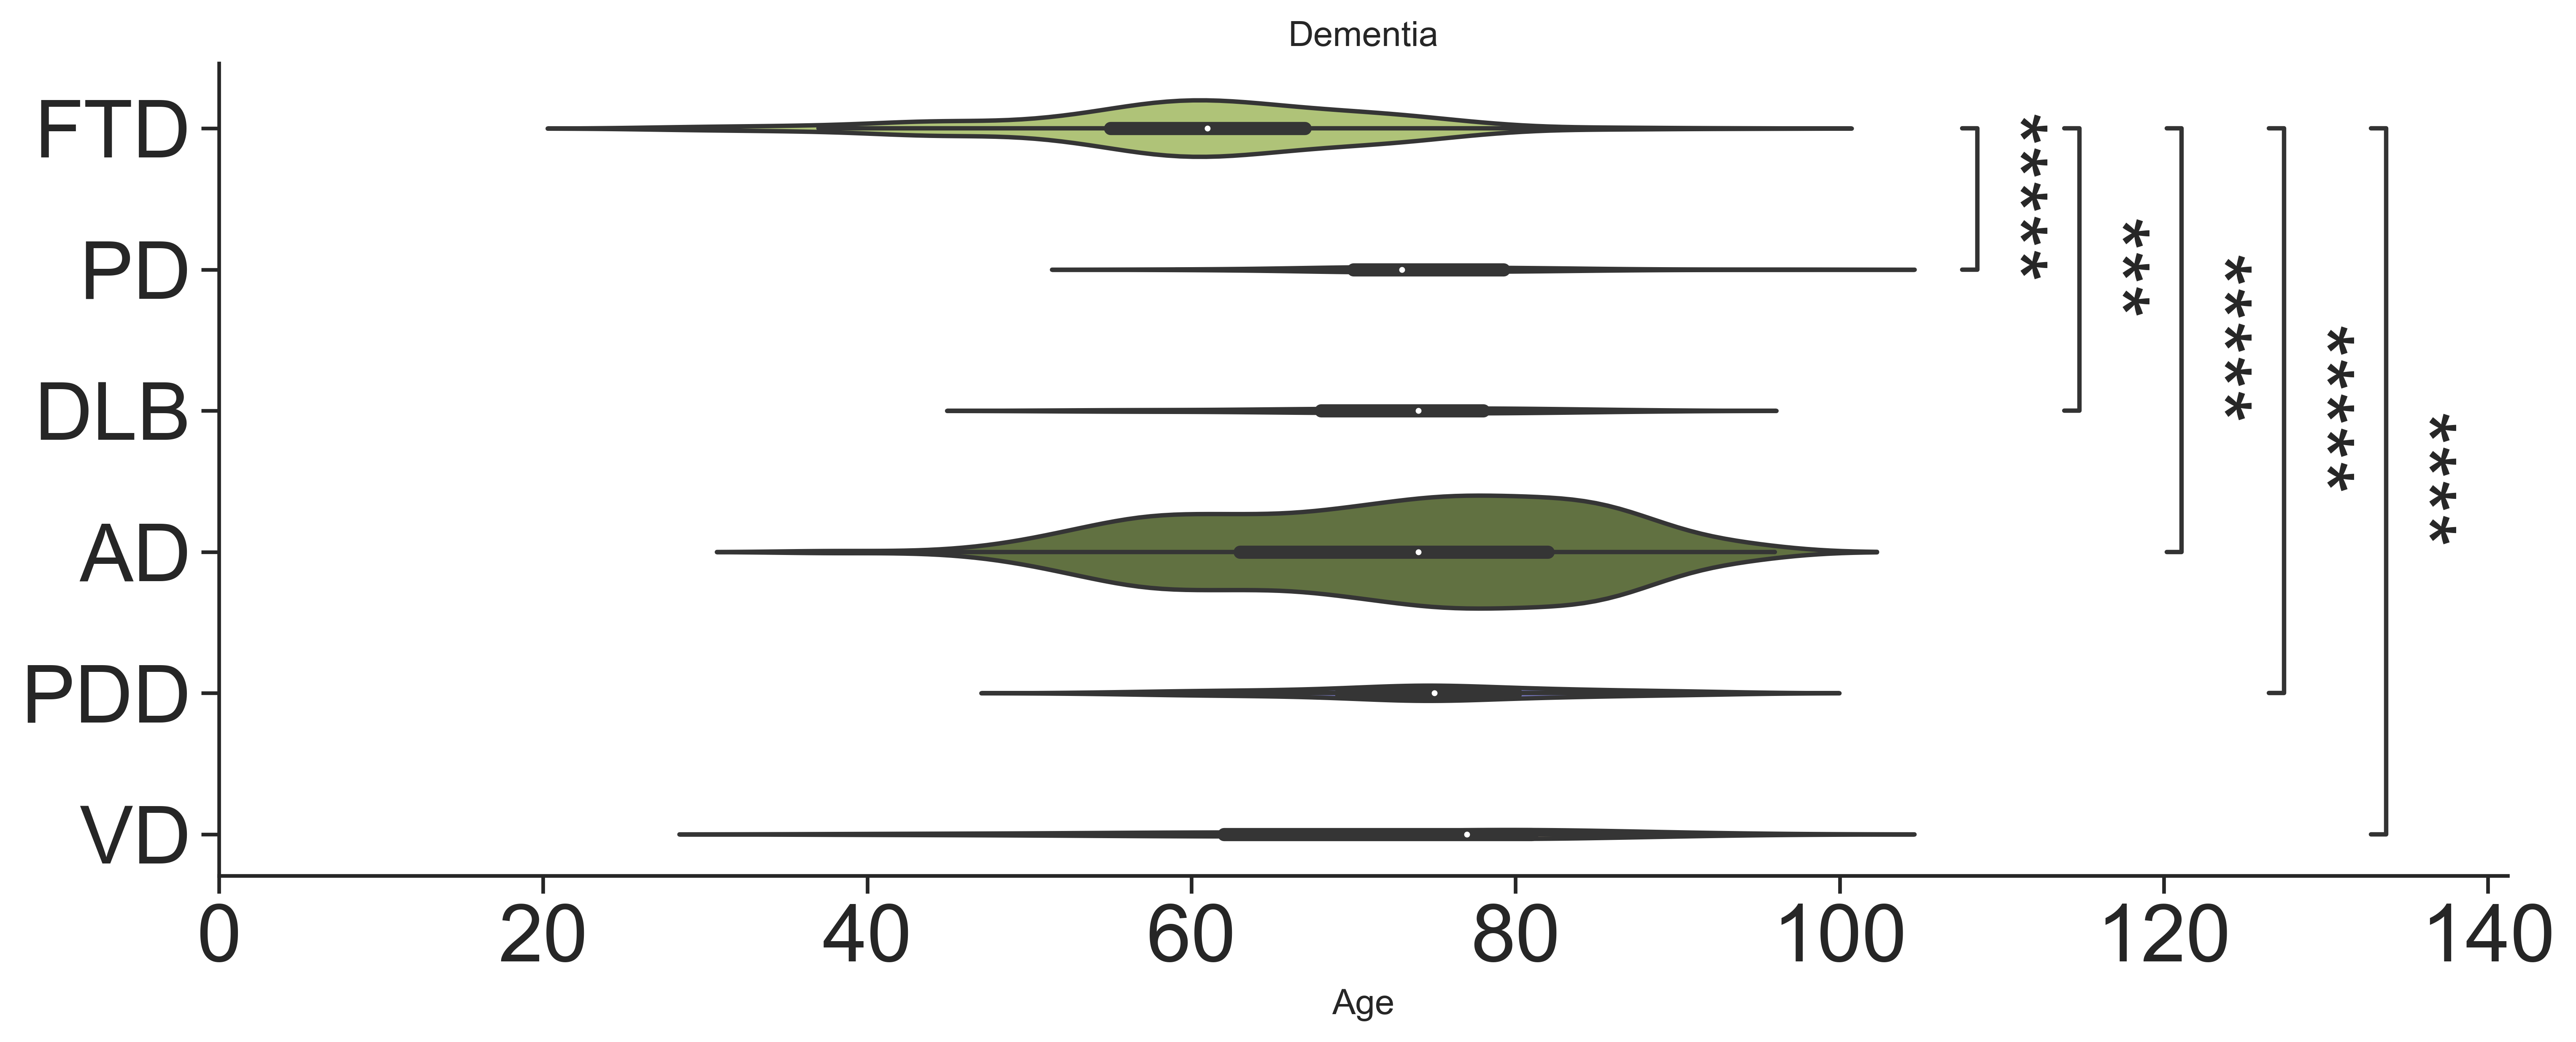

Bradykinesia
After selecting for ['PD' 'PSP' 'PDD' 'MSA' 'DLB'], we have 440  donors
Before removing zero donors


neuropathological_diagnosis sex  observations_Bradykinesia  donors
0                         DLB   F                         15       9
1                         DLB   M                         27      21
2                         MSA   F                         83      38
3                         MSA   M                         47      23
4                          PD   F                        136      51
5                          PD   M                        208      82
6                         PDD   F                        122      45
7                         PDD   M                        239      80
8                         PSP   F                         70      41
9                         PSP   M                        120      50

After removing zero donors


neuropathological_diagnosis sex  observations_Bradykinesia  donors
0                         DLB   F                         15       8
1                         DLB   M                         27      16
2                         MSA   F                         83      32
3                         MSA   M                         47      17
4                          PD   F                        136      39
5                          PD   M                        208      68
6                         PDD   F                        122      38
7                         PDD   M                        239      70
8                         PSP   F                         70      32
9                         PSP   M                        120      40











After subsampling sexes


neuropathological_diagnosis sex  observations_Bradykinesia  donors
0                         DLB   F                         15       8
1                         DLB   M                         13       8
2                         MSA   F                         48      17
3                         MSA   M                         47      17
4                          PD   F                        136      39
5                          PD   M                        125      39
6                         PDD   F                        122      38
7                         PDD   M                        137      38
8                         PSP   F                         70      32
9                         PSP   M                         99      32

268 donors are used in the temporal plot
268 donors are used in the observations plot
PD
PDD
DLB
PSP
MSA


/home/jupyter-n.mekkes@gmail.com-f6d87/.conda/envs/clinical_history/lib/python3.11/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/home/jupyter-n.mekkes@gmail.com-f6d87/.conda/envs/clinical_history/lib/python3.11/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/home/jupyter-n.mekkes@gmail.com-f6d87/.conda/envs/clinical_history/lib/python3.11/site-packages/statannotations/Annotator.py:805: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "


p-value annotation legend:
       *: p <= 1.00e-02
      **: 1.00e-06 < p <= 1.00e-04
     ***: 1.00e-08 < p <= 1.00e-06
    ****: 1.00e-10 < p <= 1.00e-08
   *****: p <= 1.00e-10

MSA vs. PSP: Custom statistical test, P_val:1.513e-09
MSA vs. PD: Custom statistical test, P_val:2.201e-07
MSA vs. PDD: Custom statistical test, P_val:2.172e-07
MSA vs. DLB: Custom statistical test, P_val:2.539e-04


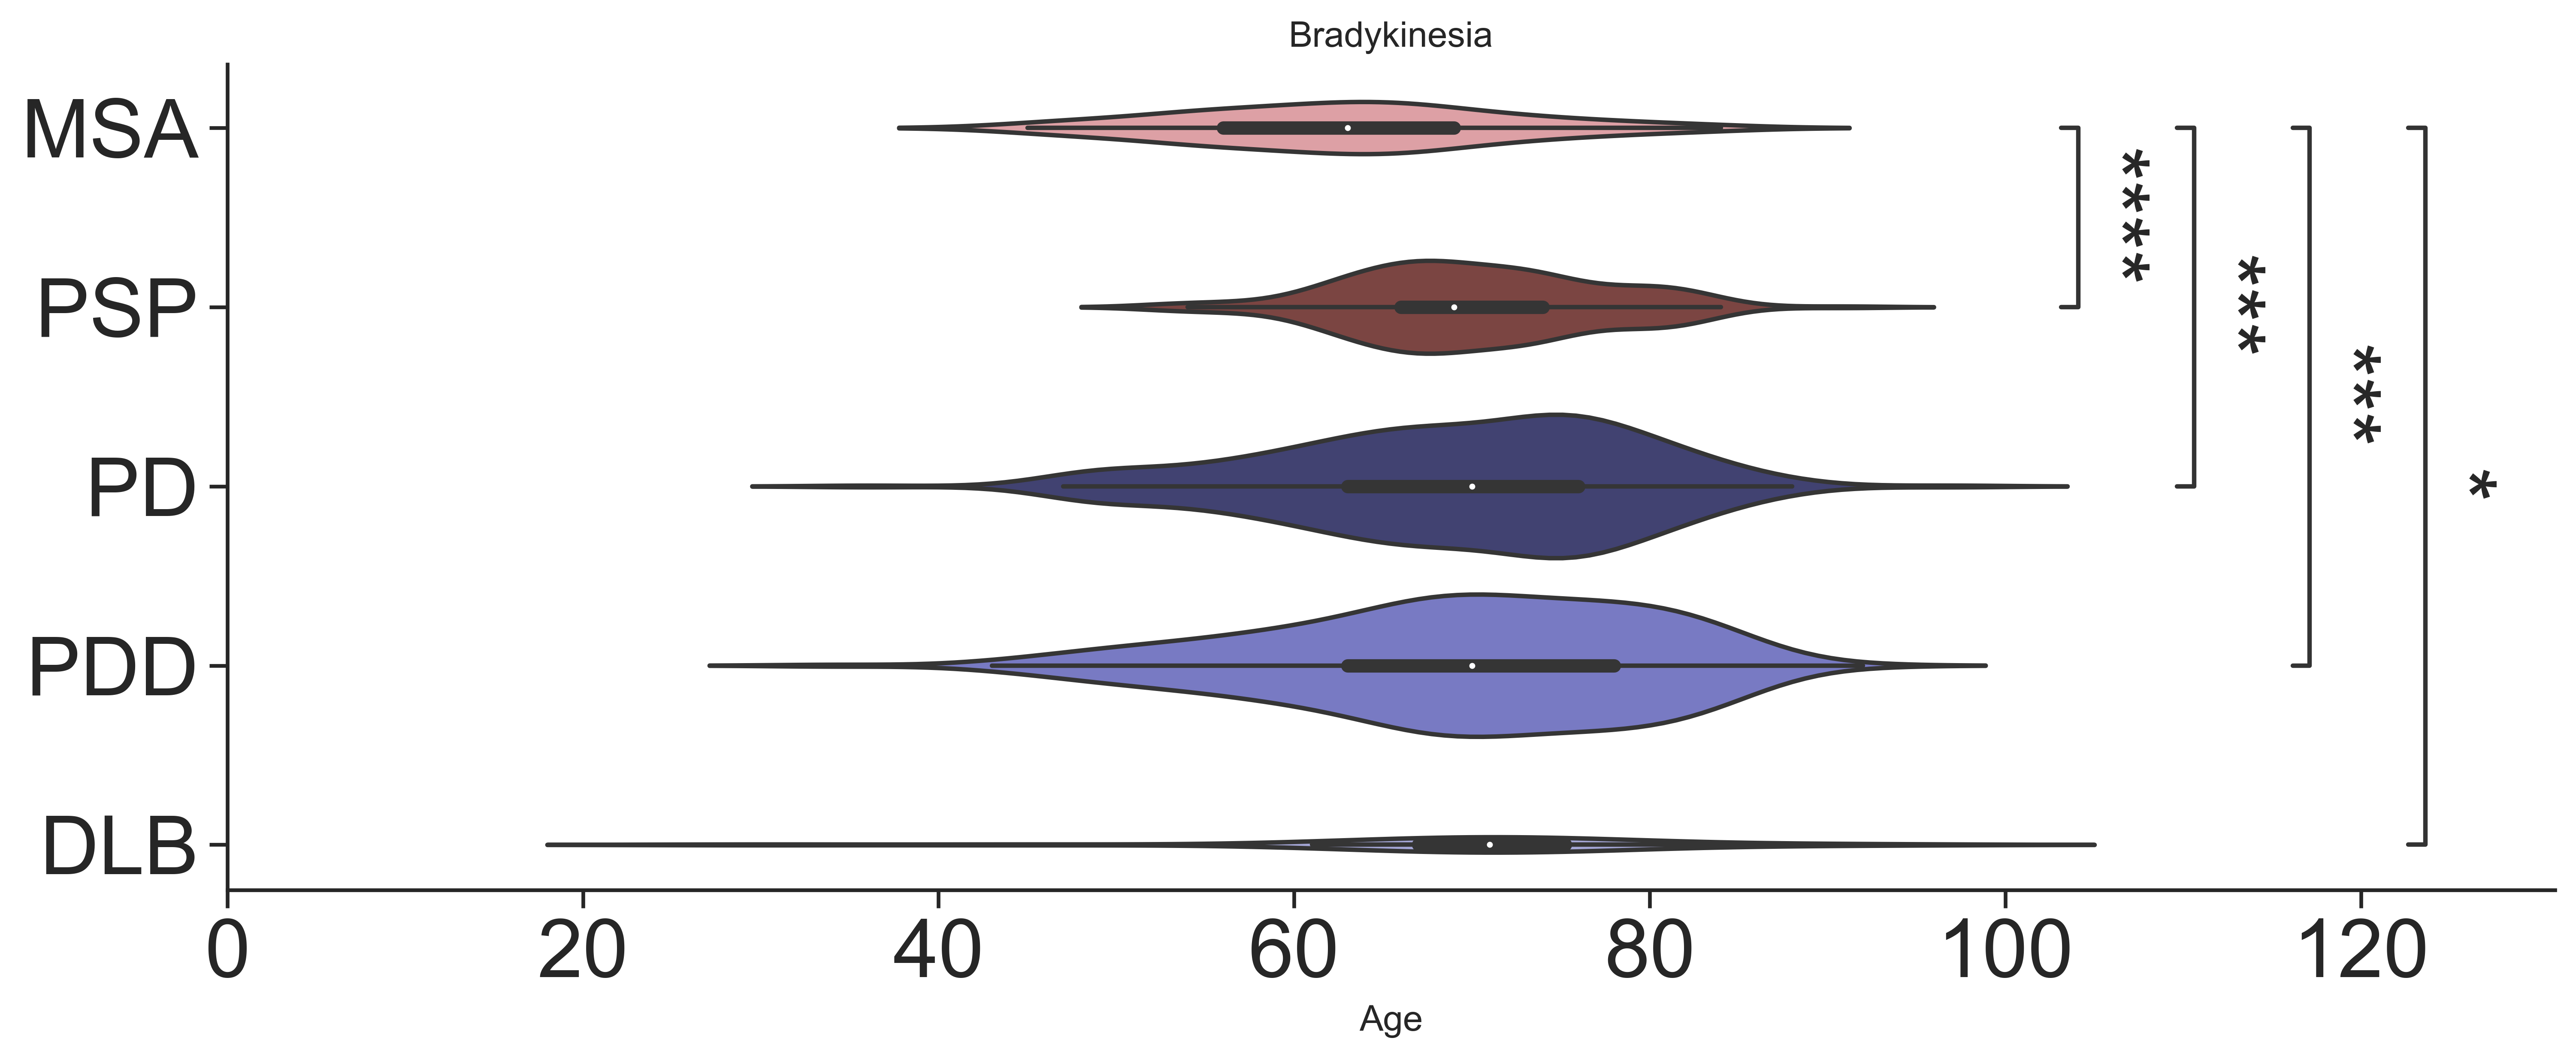

In [19]:
# ## temporal, figure 3
table_of_choice = 'table1_p'
# display(predictions_df_temporal['neuropathological_diagnosis'].unique())
selected_donors,diagnoses = table_selector(table_of_choice,predictions_df_temporal)
print(f"After selecting for {selected_donors['neuropathological_diagnosis'].unique()}, we have {selected_donors['DonorID'].nunique()}  donors")
# display(selected_donors)
# selected_donors = selected_donors[selected_donors['DonorID'].isin(selected_donors['DonorID'].unique()[-20:])]
trait_attribute_dictionary = {} 
trait_attribute_dictionary['Dementia'] = ['FTD','PDD','DLB','AD','VD','PD']
trait_attribute_dictionary['Bradykinesia'] = ['PD','PDD','DLB','PSP','MSA']

make_labeled_violinplots_horizontal(trait_attribute_dictionary,
                                    selected_donors,
                                    table_diagnosis_colors_dic,
                                    110,
                                   'temporal',
                                   'main_fig2_temporal',
                                   heatmap=False,
                                    printvalues = True,
                                    remove_zero_donors = True,
                                    fixsex = True,
                                    w = 14,
                                    h = 5
                                   )

The plot type is survival
Dementia
After selecting for ['PD' 'FTD' 'AD' 'VD' 'PDD' 'DLB'], we have 1277  donors
Before removing zero donors


neuropathological_diagnosis sex  observations_Dementia  donors
0                           AD   F                    717     491
1                           AD   M                    360     217
2                          DLB   F                     13       9
3                          DLB   M                     26      21
4                          FTD   F                    175      97
5                          FTD   M                    208     120
6                           PD   F                     15      51
7                           PD   M                     32      82
8                          PDD   F                     45      45
9                          PDD   M                     99      80
10                          VD   F                     24      25
11                          VD   M                     42      39

After removing zero donors


neuropathological_diagnosis sex  observations_Dementia  donors
0                           AD   F                    717     395
1                           AD   M                    360     189
2                          DLB   F                     13       8
3                          DLB   M                     26      13
4                          FTD   F                    175      87
5                          FTD   M                    208     106
6                           PD   F                     15      12
7                           PD   M                     32      23
8                          PDD   F                     45      26
9                          PDD   M                     99      50
10                          VD   F                     24      19
11                          VD   M                     42      27













After subsampling sexes


neuropathological_diagnosis sex  observations_Dementia  donors
0                           AD   F                    336     189
1                           AD   M                    360     189
2                          DLB   F                     13       8
3                          DLB   M                     17       8
4                          FTD   F                    175      87
5                          FTD   M                    173      87
6                           PD   F                     15      12
7                           PD   M                     17      12
8                          PDD   F                     45      26
9                          PDD   M                     49      26
10                          VD   F                     24      19
11                          VD   M                     31      19

682 donors are used in the temporal plot
682 donors are used in the observations plot
FTD
PDD
DLB
AD
VD
PD


FTD  PDD  DLB  AD  VD   PD
NBB 1992-079  15.0  NaN  NaN NaN NaN  NaN
NBB 1993-082   0.0  NaN  NaN NaN NaN  NaN
NBB 1994-020   2.0  NaN  NaN NaN NaN  NaN
NBB 1994-068   1.0  NaN  NaN NaN NaN  NaN
NBB 1994-075   6.0  NaN  NaN NaN NaN  NaN
...            ...  ...  ...  ..  ..  ...
NBB 2017-056   NaN  NaN  NaN NaN NaN  4.0
NBB 2017-059   NaN  NaN  NaN NaN NaN  0.0
NBB 2017-107   NaN  NaN  NaN NaN NaN  8.0
NBB 2017-119   NaN  NaN  NaN NaN NaN  0.0
NBB 2018-015   NaN  NaN  NaN NaN NaN  1.0

[682 rows x 6 columns]

/home/jupyter-n.mekkes@gmail.com-f6d87/.conda/envs/clinical_history/lib/python3.11/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/home/jupyter-n.mekkes@gmail.com-f6d87/.conda/envs/clinical_history/lib/python3.11/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/home/jupyter-n.mekkes@gmail.com-f6d87/.conda/envs/clinical_history/lib/python3.11/site-packages/statannotations/Annotator.py:805: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "


p-value annotation legend:
       *: p <= 1.00e-02
      **: 1.00e-06 < p <= 1.00e-04
     ***: 1.00e-08 < p <= 1.00e-06
    ****: 1.00e-10 < p <= 1.00e-08
   *****: p <= 1.00e-10

VD vs. FTD: Custom statistical test, P_val:7.658e-04
VD vs. AD: Custom statistical test, P_val:4.419e-04
PDD vs. FTD: Custom statistical test, P_val:1.596e-04
PD vs. FTD: Custom statistical test, P_val:2.596e-04
PDD vs. AD: Custom statistical test, P_val:7.123e-05
PD vs. AD: Custom statistical test, P_val:1.999e-04


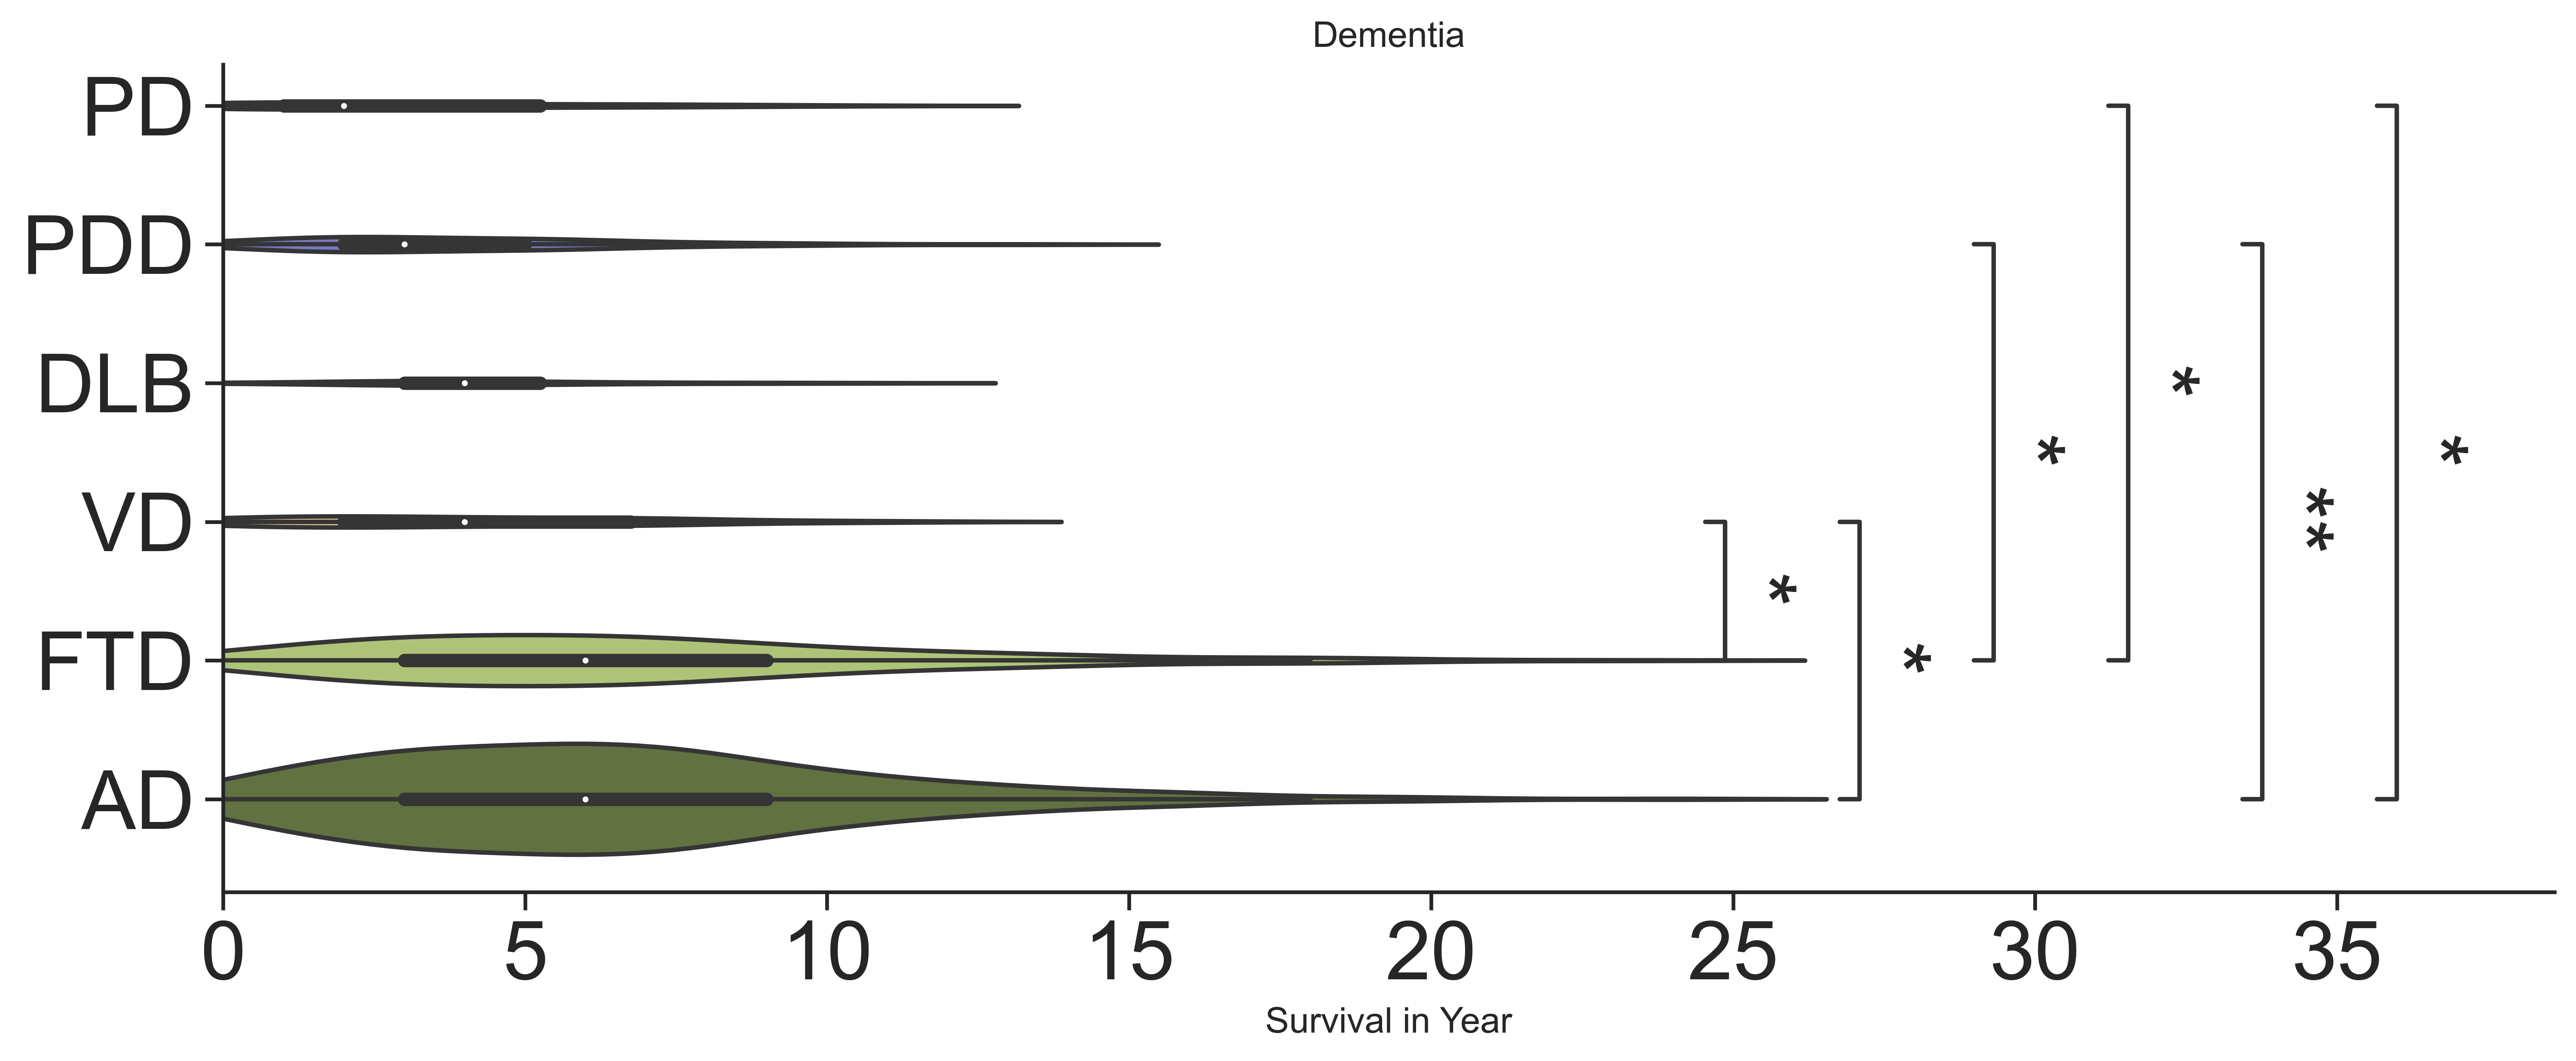

Bradykinesia
After selecting for ['PD' 'PSP' 'PDD' 'MSA' 'DLB'], we have 440  donors
Before removing zero donors


neuropathological_diagnosis sex  observations_Bradykinesia  donors
0                         DLB   F                         15       9
1                         DLB   M                         27      21
2                         MSA   F                         83      38
3                         MSA   M                         47      23
4                          PD   F                        136      51
5                          PD   M                        208      82
6                         PDD   F                        122      45
7                         PDD   M                        239      80
8                         PSP   F                         70      41
9                         PSP   M                        120      50

After removing zero donors


neuropathological_diagnosis sex  observations_Bradykinesia  donors
0                         DLB   F                         15       8
1                         DLB   M                         27      16
2                         MSA   F                         83      32
3                         MSA   M                         47      17
4                          PD   F                        136      39
5                          PD   M                        208      68
6                         PDD   F                        122      38
7                         PDD   M                        239      70
8                         PSP   F                         70      32
9                         PSP   M                        120      40











After subsampling sexes


neuropathological_diagnosis sex  observations_Bradykinesia  donors
0                         DLB   F                         15       8
1                         DLB   M                         13       8
2                         MSA   F                         48      17
3                         MSA   M                         47      17
4                          PD   F                        136      39
5                          PD   M                        125      39
6                         PDD   F                        122      38
7                         PDD   M                        137      38
8                         PSP   F                         70      32
9                         PSP   M                         99      32

268 donors are used in the temporal plot
268 donors are used in the observations plot
PD
PDD
DLB
PSP
MSA


PD  PDD  DLB  PSP  MSA
NBB 1997-064   6.0  NaN  NaN  NaN  NaN
NBB 2000-034  10.0  NaN  NaN  NaN  NaN
NBB 2000-102   0.0  NaN  NaN  NaN  NaN
NBB 2002-012  11.0  NaN  NaN  NaN  NaN
NBB 2002-022   3.0  NaN  NaN  NaN  NaN
...            ...  ...  ...  ...  ...
NBB 2015-042   NaN  NaN  NaN  NaN  8.0
NBB 2016-096   NaN  NaN  NaN  NaN  5.0
NBB 2017-036   NaN  NaN  NaN  NaN  6.0
NBB 2019-131   NaN  NaN  NaN  NaN  8.0
NBB 2020-030   NaN  NaN  NaN  NaN  4.0

[268 rows x 5 columns]

/home/jupyter-n.mekkes@gmail.com-f6d87/.conda/envs/clinical_history/lib/python3.11/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/home/jupyter-n.mekkes@gmail.com-f6d87/.conda/envs/clinical_history/lib/python3.11/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/home/jupyter-n.mekkes@gmail.com-f6d87/.conda/envs/clinical_history/lib/python3.11/site-packages/statannotations/Annotator.py:805: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "


p-value annotation legend:
       *: p <= 1.00e-02
      **: 1.00e-06 < p <= 1.00e-04
     ***: 1.00e-08 < p <= 1.00e-06
    ****: 1.00e-10 < p <= 1.00e-08
   *****: p <= 1.00e-10

MSA vs. PD: Custom statistical test, P_val:4.925e-05
DLB vs. PD: Custom statistical test, P_val:2.063e-03
MSA vs. PDD: Custom statistical test, P_val:5.872e-05
PSP vs. PD: Custom statistical test, P_val:1.956e-06
DLB vs. PDD: Custom statistical test, P_val:2.063e-03
PSP vs. PDD: Custom statistical test, P_val:2.031e-06


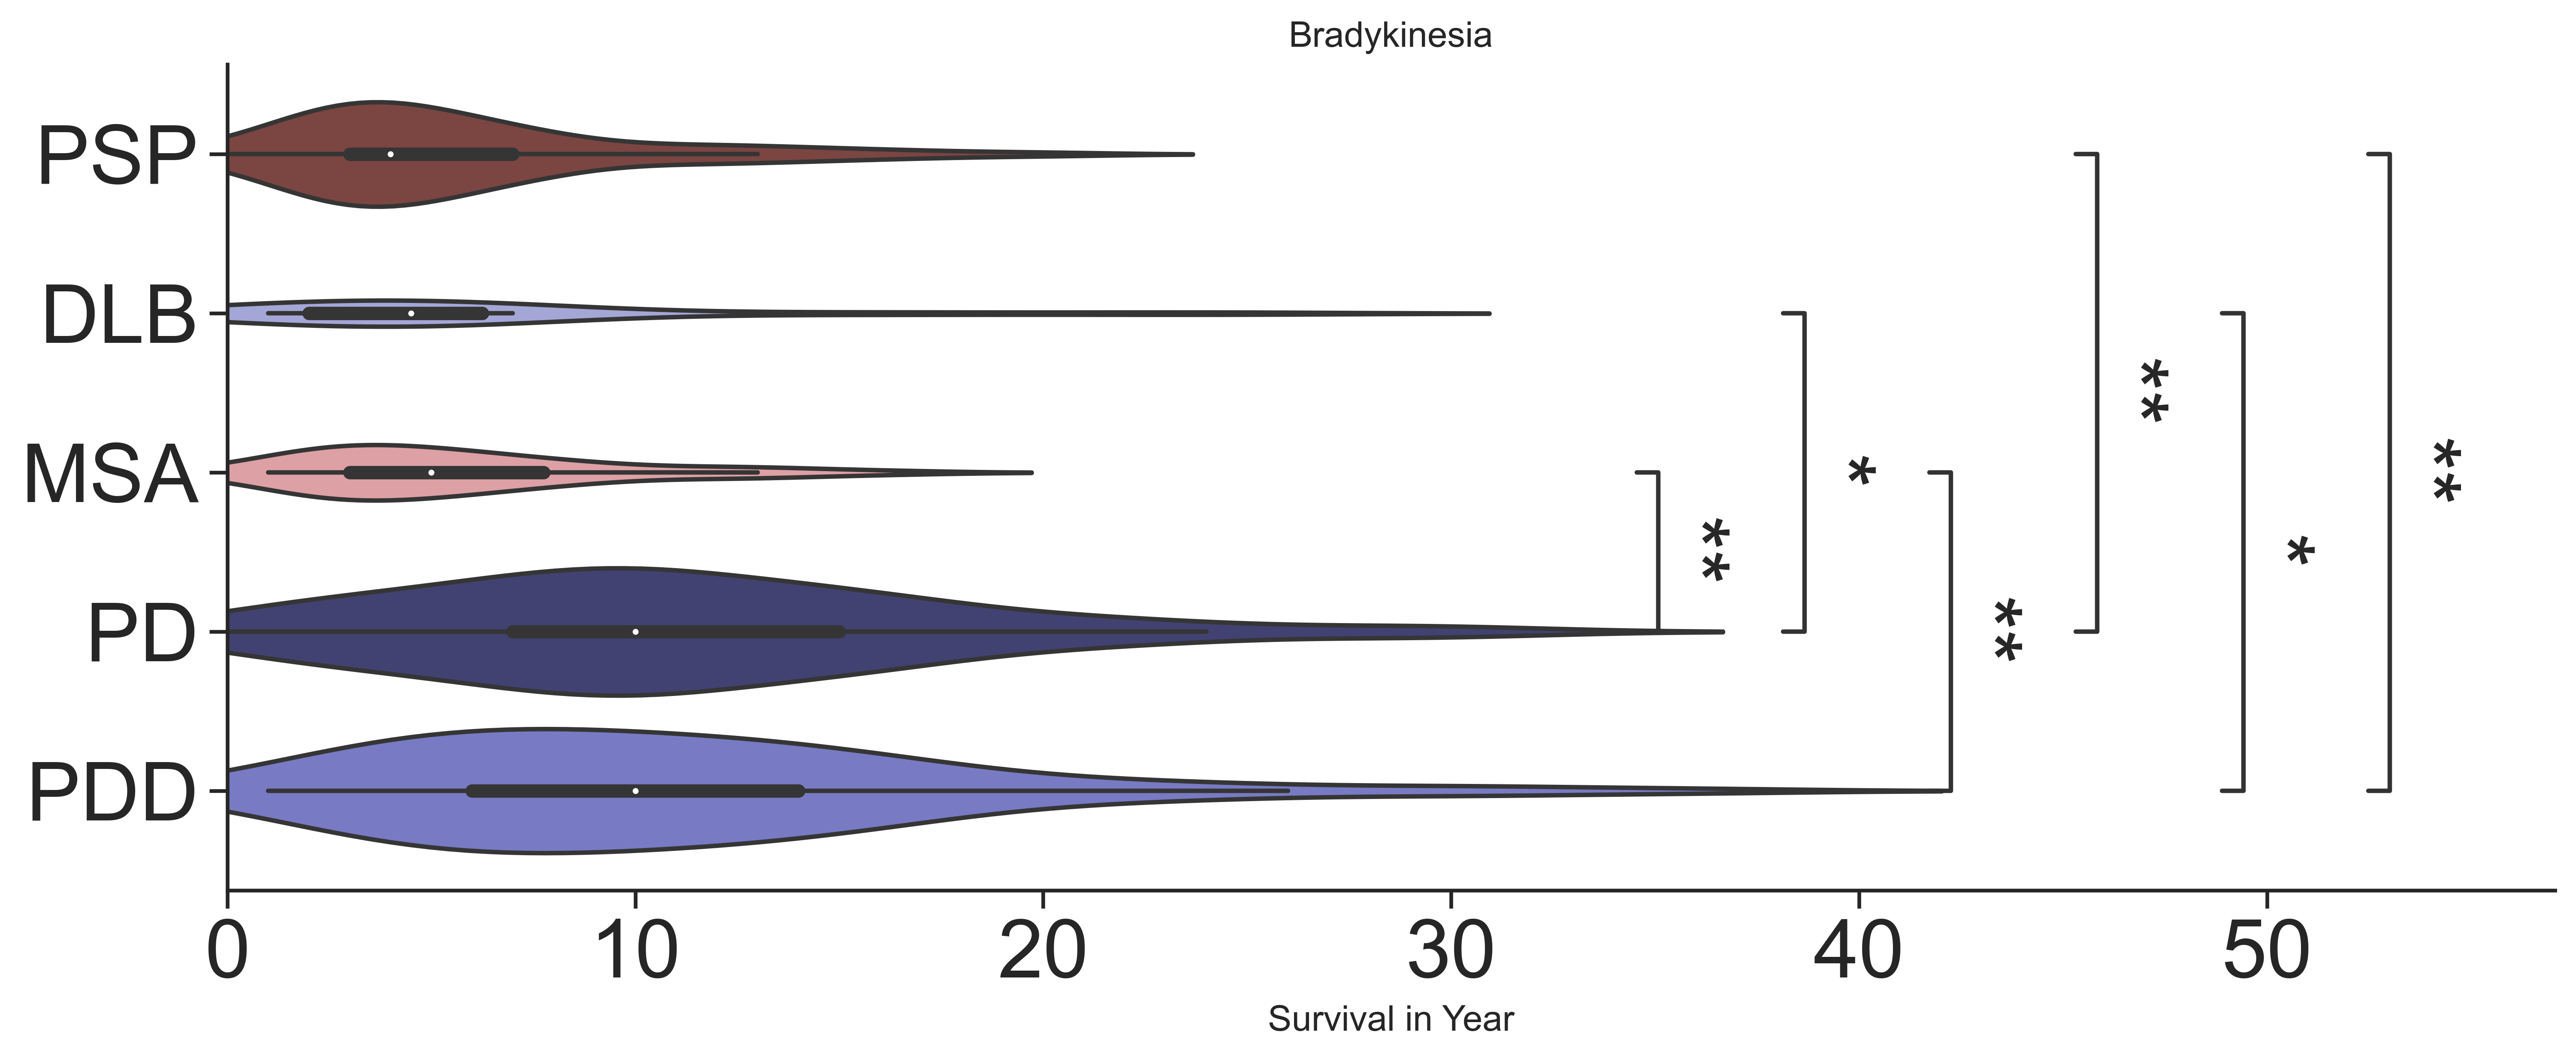

In [111]:
make_labeled_violinplots_horizontal(trait_attribute_dictionary,
                                    selected_donors,
                                    table_diagnosis_colors_dic,
                                    40,
                                   'survival',
                                   'main_fig2_survival',
                                   heatmap=False,
                                   printvalues=True,
                                    remove_zero_donors = True,
                                    fixsex = True,
                                    w = 14,
                                    h = 5
                                   )

The plot type is counts
Dementia
After selecting for ['CON' 'PD' 'FTD' 'AD' 'VD' 'PDD' 'DLB'], we have 1742  donors
Before removing zero donors


neuropathological_diagnosis sex  observations_Dementia  donors
0                           AD   F                    732     500
1                           AD   M                    362     220
2                          CON   F                      9     234
3                          CON   M                      5     211
4                          DLB   F                     13       9
5                          DLB   M                     26      22
6                          FTD   F                    180     101
7                          FTD   M                    209     121
8                           PD   F                     15      51
9                           PD   M                     32      83
10                         PDD   F                     46      46
11                         PDD   M                    100      80
12                          VD   F                     24      25
13                          VD   M                     42      39















After subsampling sexes


neuropathological_diagnosis sex  observations_Dementia  donors
0                           AD   F                    342     220
1                           AD   M                    362     220
2                          CON   F                      9     211
3                          CON   M                      5     211
4                          DLB   F                     13       9
5                          DLB   M                      9       9
6                          FTD   F                    180     101
7                          FTD   M                    169     101
8                           PD   F                     15      51
9                           PD   M                     21      51
10                         PDD   F                     46      46
11                         PDD   M                     60      46
12                          VD   F                     24      25
13                          VD   M                     25      25

691 donors are used in the temporal plot
1326 donors are used in the observations plot
CON


/tmp/ipykernel_10217/3446875031.py:83: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df.groupby(['DonorID']).sum() ## sums all observations of symptom for donor. note, many donors have 0 (e.g. control)


'422 donors in the counts df'

FTD


/tmp/ipykernel_10217/3446875031.py:83: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df.groupby(['DonorID']).sum() ## sums all observations of symptom for donor. note, many donors have 0 (e.g. control)


'202 donors in the counts df'

PDD


/tmp/ipykernel_10217/3446875031.py:83: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df.groupby(['DonorID']).sum() ## sums all observations of symptom for donor. note, many donors have 0 (e.g. control)


'92 donors in the counts df'

DLB


/tmp/ipykernel_10217/3446875031.py:83: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df.groupby(['DonorID']).sum() ## sums all observations of symptom for donor. note, many donors have 0 (e.g. control)


'18 donors in the counts df'

AD


/tmp/ipykernel_10217/3446875031.py:83: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df.groupby(['DonorID']).sum() ## sums all observations of symptom for donor. note, many donors have 0 (e.g. control)


'440 donors in the counts df'

VD


/tmp/ipykernel_10217/3446875031.py:83: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df.groupby(['DonorID']).sum() ## sums all observations of symptom for donor. note, many donors have 0 (e.g. control)


'50 donors in the counts df'

PD


/tmp/ipykernel_10217/3446875031.py:83: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df.groupby(['DonorID']).sum() ## sums all observations of symptom for donor. note, many donors have 0 (e.g. control)


'102 donors in the counts df'

/home/jupyter-n.mekkes@gmail.com-f6d87/.conda/envs/clinical_history/lib/python3.11/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/home/jupyter-n.mekkes@gmail.com-f6d87/.conda/envs/clinical_history/lib/python3.11/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/home/jupyter-n.mekkes@gmail.com-f6d87/.conda/envs/clinical_history/lib/python3.11/site-packages/statannotations/Annotator.py:805: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "


p-value annotation legend:
       *: p <= 1.00e-02
      **: 1.00e-06 < p <= 1.00e-04
     ***: 1.00e-08 < p <= 1.00e-06
    ****: 1.00e-10 < p <= 1.00e-08
   *****: p <= 1.00e-10

CON vs. PD: Custom statistical test, P_val:2.159e-16
PD vs. PDD: Custom statistical test, P_val:1.134e-07
AD vs. VD: Custom statistical test, P_val:1.213e-03
VD vs. FTD: Custom statistical test, P_val:2.820e-05
CON vs. PDD: Custom statistical test, P_val:3.747e-51
PD vs. DLB: Custom statistical test, P_val:6.339e-04
PDD vs. AD: Custom statistical test, P_val:2.783e-03
CON vs. DLB: Custom statistical test, P_val:1.498e-32
PD vs. AD: Custom statistical test, P_val:2.684e-25
CON vs. AD: Custom statistical test, P_val:3.962e-117
PD vs. VD: Custom statistical test, P_val:6.537e-07
PDD vs. FTD: Custom statistical test, P_val:1.079e-04
CON vs. VD: Custom statistical test, P_val:2.744e-51
PD vs. FTD: Custom statistical test, P_val:2.684e-25
CON vs. FTD: Custom statistical test, P_val:1.379e-103


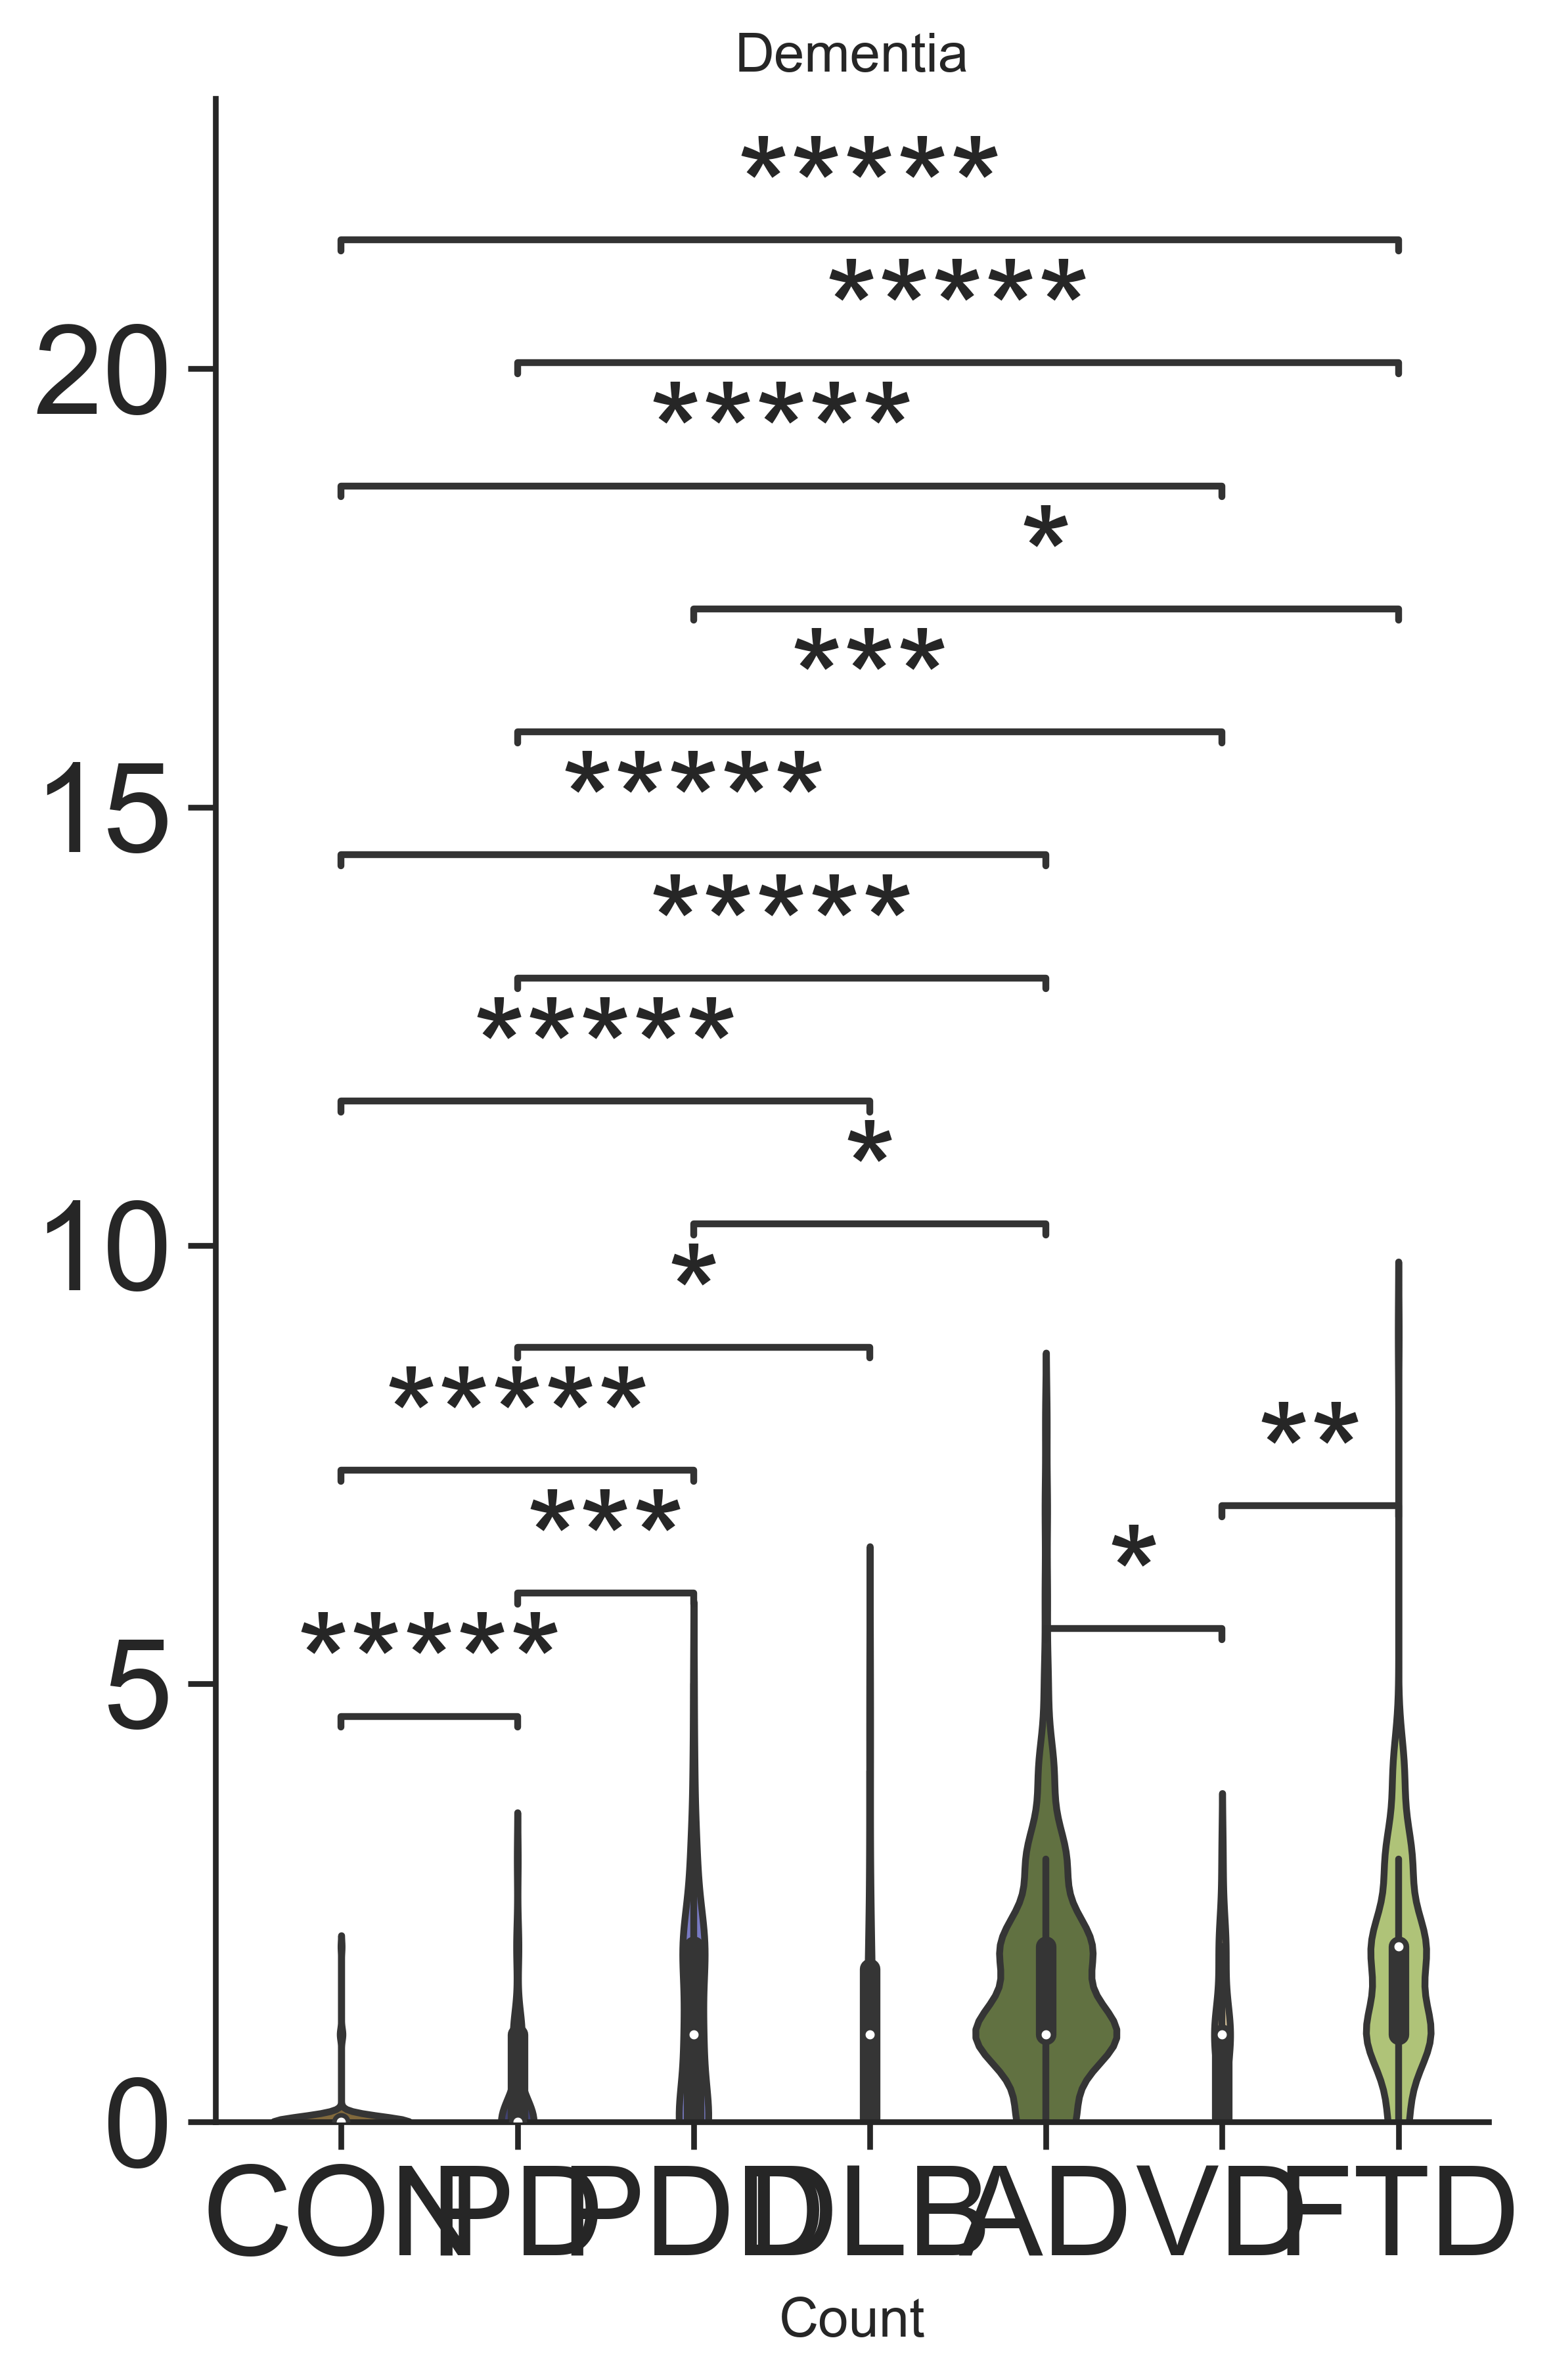

In [112]:
## counts, figure 3
selected_donors,diagnoses = table_selector(table_of_choice,predictions_df)
trait_attribute_dictionary = {} 
trait_attribute_dictionary['Dementia'] = ['CON','FTD','PDD','DLB','AD','VD','PD']
# trait_attribute_dictionary['Bradykinesia'] = ['CON','PD','PDD','DLB','PSP','MSA']
# trait_attribute_dictionary['Dementia'] = ['FTD','PDD','DLB','AD','VD','PD']
# trait_attribute_dictionary['Bradykinesia'] = ['PD','PDD','DLB','PSP','MSA']
make_labeled_violinplots_horizontal(trait_attribute_dictionary,
                                    selected_donors,
                                    table_diagnosis_colors_dic,
                                    20,
                                   'counts',
                                   'main_fig2_counts',
                                   heatmap=False,
                                   printvalues=True,
                                   fixsex=True,
                                   remove_zero_donors = False,
                                   w=5,
                                   h=8)

After selecting for ['PD' 'FTD' 'DEM_SICC' 'AD_ILBD' 'AD' 'AD_DLB' 'AD_CA' 'DLB_SICC'
 'DEM_SICC_AGD' 'VD' 'DEM_VE' 'PDD' 'AD_VE' 'VE' 'ILBD' 'DLB' 'PD_AD'], we have 1715  donors
The plot type is temporal
Dementia
After selecting for ['PD' 'FTD' 'DEM_SICC' 'AD' 'AD_DLB' 'AD_CA' 'DLB_SICC' 'DEM_SICC_AGD'
 'VD' 'DEM_VE' 'PDD' 'AD_VE' 'DLB' 'PD_AD'], we have 1633  donors
Before removing zero donors


neuropathological_diagnosis sex  observations_Dementia  donors
0                           AD   F                    717     491
1                           AD   M                    360     217
2                        AD_CA   F                     40      24
3                        AD_CA   M                     28      17
4                       AD_DLB   F                    123      75
5                       AD_DLB   M                     91      45
6                        AD_VE   F                     10      14
7                        AD_VE   M                     13      10
8                     DEM_SICC   F                     28      38
9                     DEM_SICC   M                     20      19
10                DEM_SICC_AGD   F                      9      10
11                DEM_SICC_AGD   M                     12       7
12                      DEM_VE   F                     11      10
13                      DEM_VE   M                      1       5
14                         DLB   F                     13       9
15                         DLB   M                     26      21
16                    DLB_SICC   F                     33      24
17                    DLB_SICC   M                     56      36
18                         FTD   F                    175      97
19                         FTD   M                    208     120
20                          PD   F                     15      51
21                          PD   M                     32      82
22                         PDD   F                     45      45
23                         PDD   M                     99      80
24                       PD_AD   F                     11      11
25                       PD_AD   M                     14      11
26                          VD   F                     24      25
27                          VD   M                     42      39

After removing zero donors


neuropathological_diagnosis sex  observations_Dementia  donors
0                           AD   F                    717     395
1                           AD   M                    360     189
2                        AD_CA   F                     40      22
3                        AD_CA   M                     28      14
4                       AD_DLB   F                    123      64
5                       AD_DLB   M                     91      38
6                        AD_VE   F                     10       7
7                        AD_VE   M                     13       9
8                     DEM_SICC   F                     28      20
9                     DEM_SICC   M                     20      13
10                DEM_SICC_AGD   F                      9       7
11                DEM_SICC_AGD   M                     12       7
12                      DEM_VE   F                     11       7
13                      DEM_VE   M                      1       1
14                         DLB   F                     13       8
15                         DLB   M                     26      13
16                    DLB_SICC   F                     33      20
17                    DLB_SICC   M                     56      30
18                         FTD   F                    175      87
19                         FTD   M                    208     106
20                          PD   F                     15      12
21                          PD   M                     32      23
22                         PDD   F                     45      26
23                         PDD   M                     99      50
24                       PD_AD   F                     11       6
25                       PD_AD   M                     14      10
26                          VD   F                     24      19
27                          VD   M                     42      27





























After subsampling sexes


neuropathological_diagnosis sex  observations_Dementia  donors
0                           AD   F                    336     189
1                           AD   M                    360     189
2                        AD_CA   F                     25      14
3                        AD_CA   M                     28      14
4                       AD_DLB   F                     67      38
5                       AD_DLB   M                     91      38
6                        AD_VE   F                     10       7
7                        AD_VE   M                     10       7
8                     DEM_SICC   F                     20      13
9                     DEM_SICC   M                     20      13
10                DEM_SICC_AGD   F                      9       7
11                DEM_SICC_AGD   M                     12       7
12                      DEM_VE   F                      1       1
13                      DEM_VE   M                      1       1
14                         DLB   F                     13       8
15                         DLB   M                     17       8
16                    DLB_SICC   F                     33      20
17                    DLB_SICC   M                     38      20
18                         FTD   F                    175      87
19                         FTD   M                    173      87
20                          PD   F                     15      12
21                          PD   M                     17      12
22                         PDD   F                     45      26
23                         PDD   M                     49      26
24                       PD_AD   F                     11       6
25                       PD_AD   M                      8       6
26                          VD   F                     24      19
27                          VD   M                     31      19

894 donors are used in the temporal plot
894 donors are used in the observations plot
FTD
AD_CA
AD_DLB
AD_VE
AD
DEM_SICC_AGD
DLB_SICC
DLB
DEM_SICC
DEM_VE
PD_AD
PDD
PD
VD


/home/jupyter-n.mekkes@gmail.com-f6d87/.conda/envs/clinical_history/lib/python3.11/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/home/jupyter-n.mekkes@gmail.com-f6d87/.conda/envs/clinical_history/lib/python3.11/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/home/jupyter-n.mekkes@gmail.com-f6d87/.conda/envs/clinical_history/lib/python3.11/site-packages/statannotations/Annotator.py:805: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "


p-value annotation legend:
       *: p <= 1.00e-02
      **: 1.00e-06 < p <= 1.00e-04
     ***: 1.00e-08 < p <= 1.00e-06
    ****: 1.00e-10 < p <= 1.00e-08
   *****: p <= 1.00e-10

FTD vs. AD_DLB: Custom statistical test, P_val:1.908e-19
FTD vs. AD_CA: Custom statistical test, P_val:6.427e-14
FTD vs. PD: Custom statistical test, P_val:1.536e-11
FTD vs. AD: Custom statistical test, P_val:5.047e-44
FTD vs. DLB: Custom statistical test, P_val:1.396e-07
AD_DLB vs. PDD: Custom statistical test, P_val:6.242e-03
VD vs. DEM_SICC: Custom statistical test, P_val:2.552e-03
FTD vs. PDD: Custom statistical test, P_val:4.727e-25
AD_DLB vs. DLB_SICC: Custom statistical test, P_val:2.246e-04
PDD vs. PD_AD: Custom statistical test, P_val:2.106e-03
DLB_SICC vs. DEM_SICC: Custom statistical test, P_val:6.326e-03
FTD vs. DLB_SICC: Custom statistical test, P_val:3.006e-24
AD vs. AD_VE: Custom statistical test, P_val:7.039e-03
DLB vs. PD_AD: Custom statistical test, P_val:1.146e-03
PDD vs. DEM_SICC: Custom 

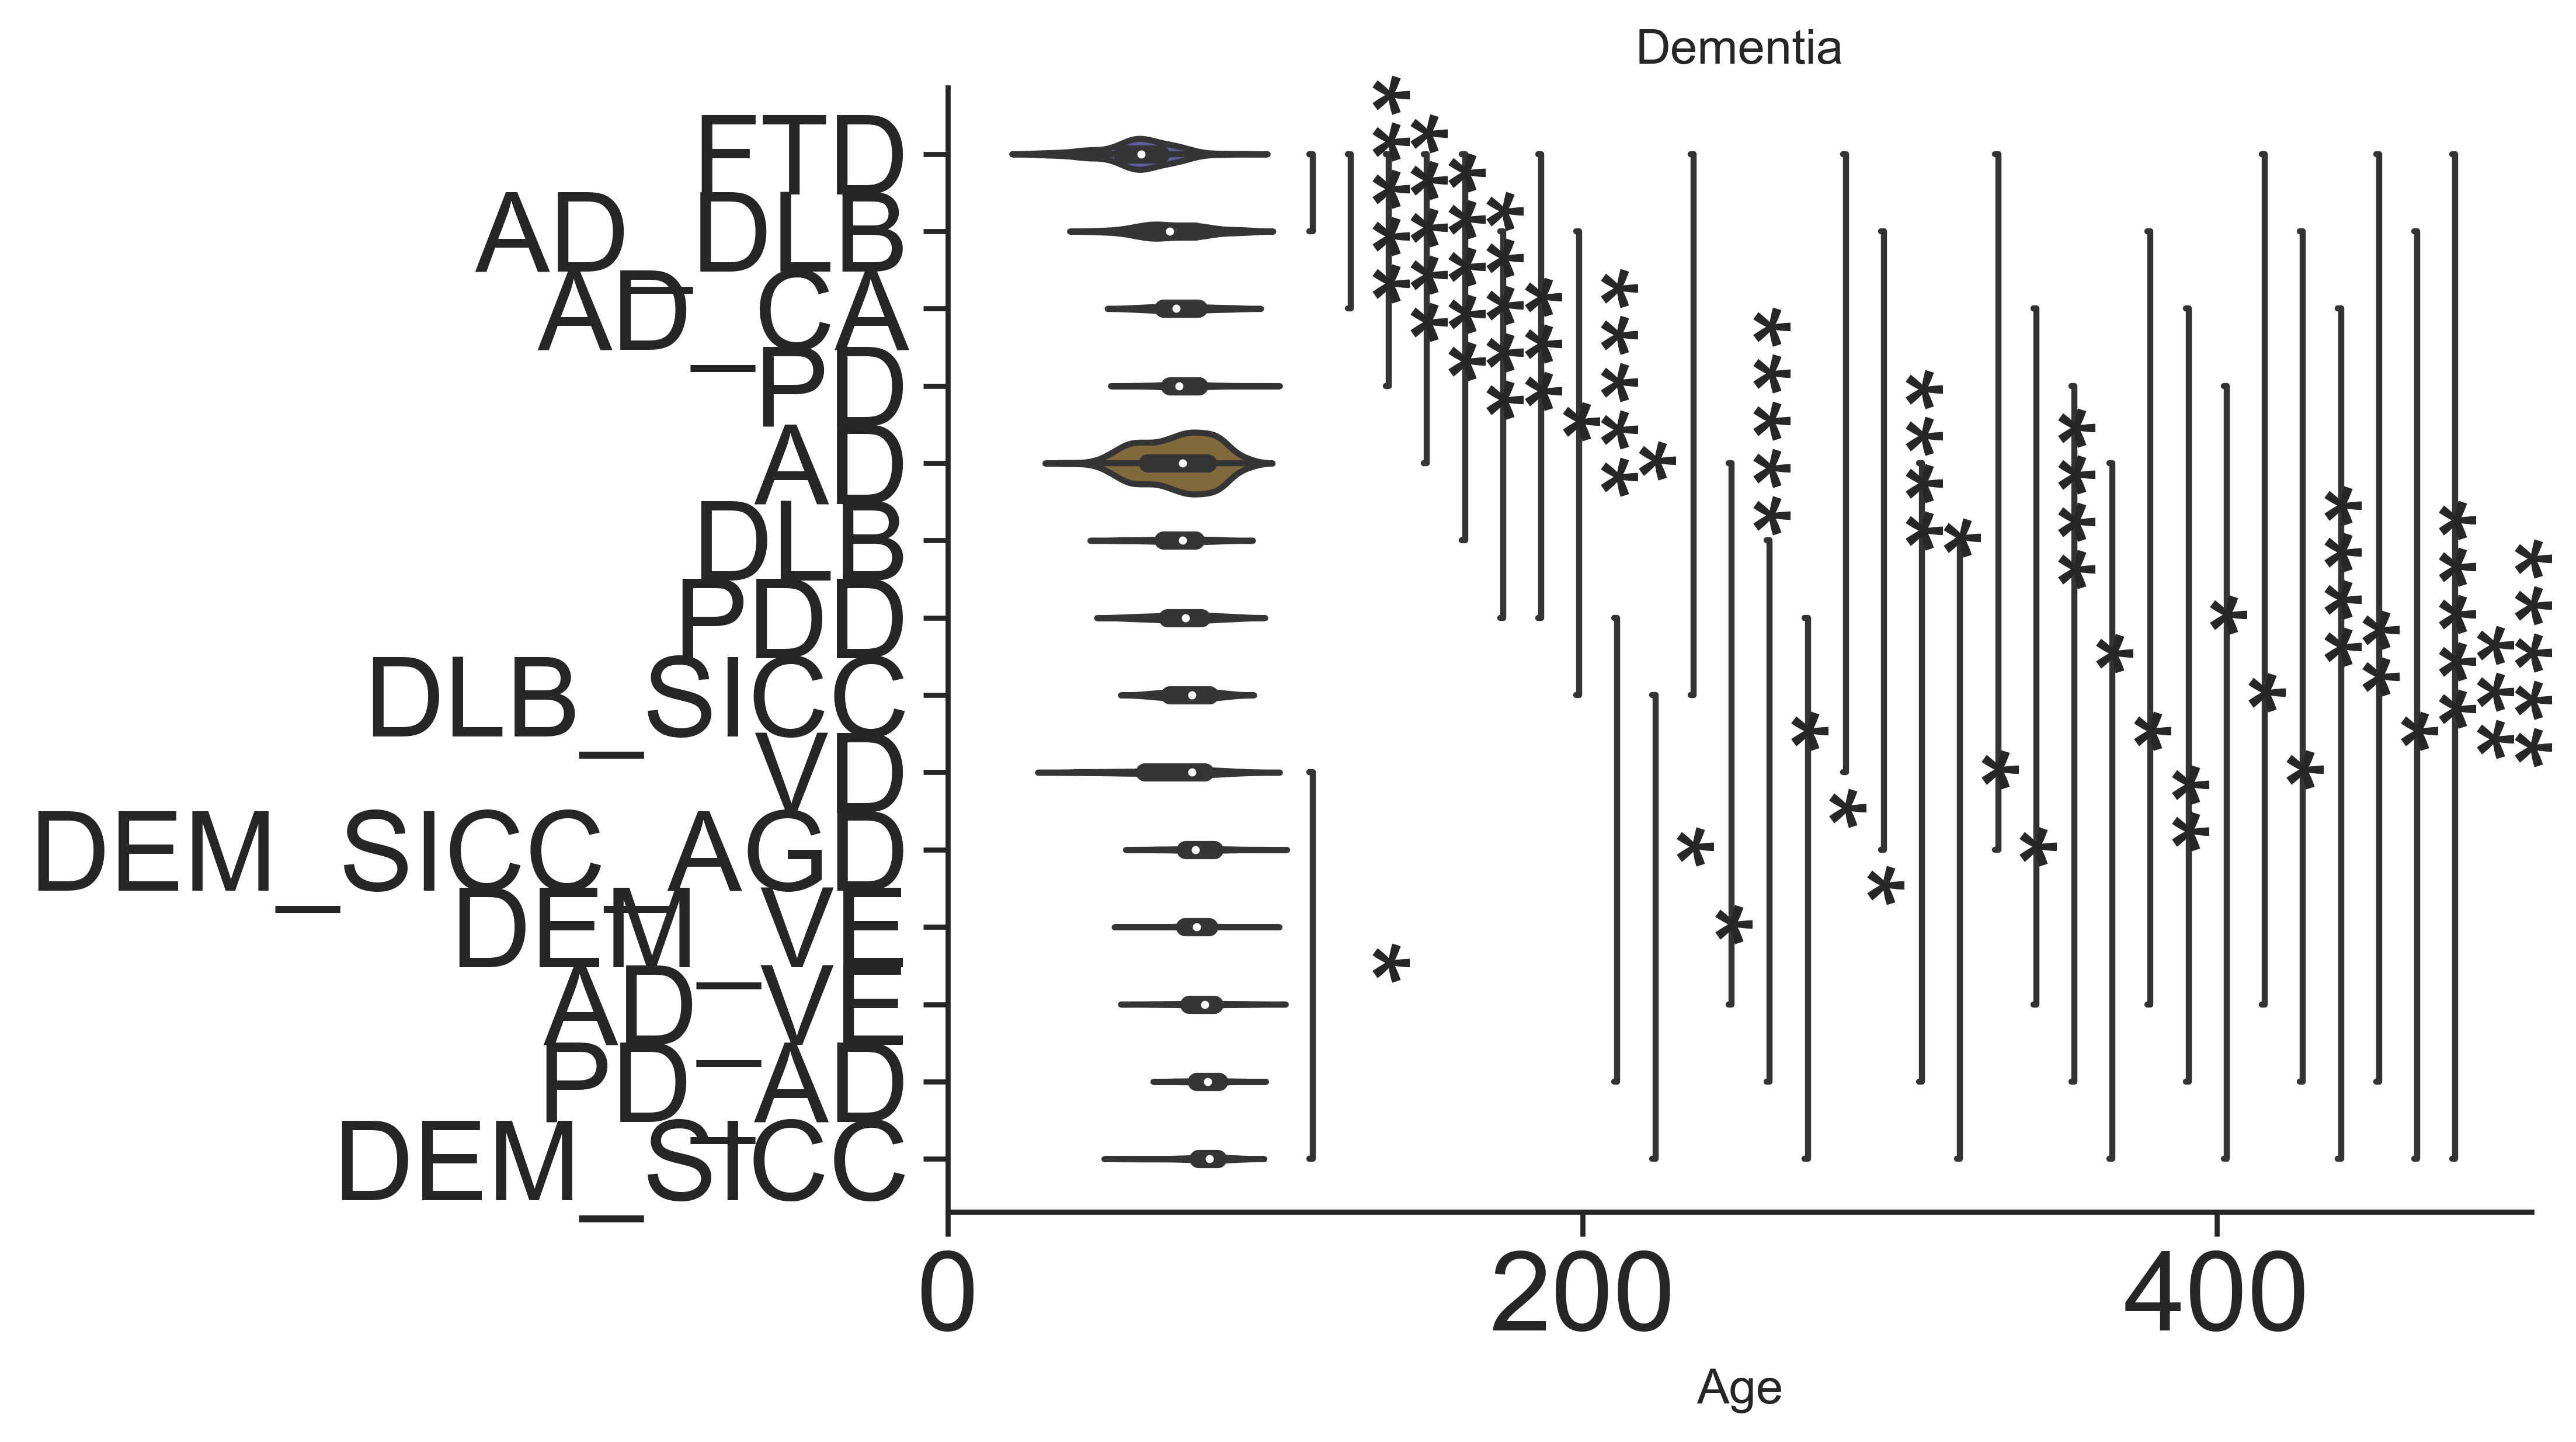

Disorientation
After selecting for ['PD' 'FTD' 'DEM_SICC' 'AD' 'AD_DLB' 'AD_CA' 'DLB_SICC' 'DEM_SICC_AGD'
 'VD' 'DEM_VE' 'PDD' 'AD_VE' 'DLB' 'PD_AD'], we have 1633  donors
Before removing zero donors


neuropathological_diagnosis sex  observations_Disorientation  donors
0                           AD   F                          508     491
1                           AD   M                          248     217
2                        AD_CA   F                           26      24
3                        AD_CA   M                           18      17
4                       AD_DLB   F                           89      75
5                       AD_DLB   M                           51      45
6                        AD_VE   F                           13      14
7                        AD_VE   M                           11      10
8                     DEM_SICC   F                           20      38
9                     DEM_SICC   M                           17      19
10                DEM_SICC_AGD   F                           11      10
11                DEM_SICC_AGD   M                            7       7
12                      DEM_VE   F                            7      10
13                      DEM_VE   M                            0       5
14                         DLB   F                           10       9
15                         DLB   M                           29      21
16                    DLB_SICC   F                           25      24
17                    DLB_SICC   M                           45      36
18                         FTD   F                           78      97
19                         FTD   M                          103     120
20                          PD   F                           18      51
21                          PD   M                           38      82
22                         PDD   F                           37      45
23                         PDD   M                           62      80
24                       PD_AD   F                           11      11
25                       PD_AD   M                           13      11
26                          VD   F                           30      25
27                          VD   M                           35      39

After removing zero donors


neuropathological_diagnosis sex  observations_Disorientation  donors
0                           AD   F                          508     338
1                           AD   M                          248     150
2                        AD_CA   F                           26      17
3                        AD_CA   M                           18      14
4                       AD_DLB   F                           89      52
5                       AD_DLB   M                           51      31
6                        AD_VE   F                           13       7
7                        AD_VE   M                           11       7
8                     DEM_SICC   F                           20      17
9                     DEM_SICC   M                           17      11
10                DEM_SICC_AGD   F                           11       7
11                DEM_SICC_AGD   M                            7       5
12                      DEM_VE   F                            7       5
13                         DLB   F                           10       6
14                         DLB   M                           29      15
15                    DLB_SICC   F                           25      17
16                    DLB_SICC   M                           45      28
17                         FTD   F                           78      56
18                         FTD   M                          103      74
19                          PD   F                           18      12
20                          PD   M                           38      24
21                         PDD   F                           37      26
22                         PDD   M                           62      47
23                       PD_AD   F                           11       6
24                       PD_AD   M                           13       7
25                          VD   F                           30      20
26                          VD   M                           35      23



















After subsampling, DEM_VE no longer has both male and female donors








After subsampling sexes


neuropathological_diagnosis sex  observations_Disorientation  donors
0                           AD   F                          219     150
1                           AD   M                          248     150
2                        AD_CA   F                           23      14
3                        AD_CA   M                           18      14
4                       AD_DLB   F                           52      31
5                       AD_DLB   M                           51      31
6                        AD_VE   F                           13       7
7                        AD_VE   M                           11       7
8                     DEM_SICC   F                           14      11
9                     DEM_SICC   M                           17      11
10                DEM_SICC_AGD   F                            8       5
11                DEM_SICC_AGD   M                            7       5
12                         DLB   F                           10       6
13                         DLB   M                           12       6
14                    DLB_SICC   F                           25      17
15                    DLB_SICC   M                           27      17
16                         FTD   F                           78      56
17                         FTD   M                           81      56
18                          PD   F                           18      12
19                          PD   M                           20      12
20                         PDD   F                           37      26
21                         PDD   M                           31      26
22                       PD_AD   F                           11       6
23                       PD_AD   M                           11       6
24                          VD   F                           30      20
25                          VD   M                           30      20

722 donors are used in the temporal plot
722 donors are used in the observations plot
FTD
AD_CA
AD_DLB
AD_VE
AD
DEM_SICC_AGD
DLB_SICC
DLB
DEM_SICC
DEM_VE
PD_AD
PDD
PD
VD


/tmp/ipykernel_10217/3446875031.py:109: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  plot_df = pd.DataFrame(dict([(disorder, pd.Series(v)) for disorder, v in temporal.items()]))
/home/jupyter-n.mekkes@gmail.com-f6d87/.conda/envs/clinical_history/lib/python3.11/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


diagnosis FTD or diagnosis DEM_VE has no instances of attribute Disorientation
diagnosis AD_CA or diagnosis DEM_VE has no instances of attribute Disorientation
diagnosis DLB or diagnosis DEM_VE has no instances of attribute Disorientation
diagnosis PDD or diagnosis DEM_VE has no instances of attribute Disorientation
diagnosis AD_DLB or diagnosis DEM_VE has no instances of attribute Disorientation
diagnosis AD or diagnosis DEM_VE has no instances of attribute Disorientation
diagnosis PD_AD or diagnosis DEM_VE has no instances of attribute Disorientation
diagnosis PD or diagnosis DEM_VE has no instances of attribute Disorientation
diagnosis DLB_SICC or diagnosis DEM_VE has no instances of attribute Disorientation
diagnosis VD or diagnosis DEM_VE has no instances of attribute Disorientation
diagnosis AD_VE or diagnosis DEM_VE has no instances of attribute Disorientation
diagnosis DEM_SICC or diagnosis DEM_VE has no instances of attribute Disorientation
diagnosis DEM_SICC_AGD or diagnosis 

/home/jupyter-n.mekkes@gmail.com-f6d87/.conda/envs/clinical_history/lib/python3.11/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/home/jupyter-n.mekkes@gmail.com-f6d87/.conda/envs/clinical_history/lib/python3.11/site-packages/statannotations/Annotator.py:805: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "


p-value annotation legend:
       *: p <= 1.00e-02
      **: 1.00e-06 < p <= 1.00e-04
     ***: 1.00e-08 < p <= 1.00e-06
    ****: 1.00e-10 < p <= 1.00e-08
   *****: p <= 1.00e-10

FTD vs. AD_CA: Custom statistical test, P_val:8.294e-09
FTD vs. DLB: Custom statistical test, P_val:2.429e-04
DLB_SICC vs. AD_VE: Custom statistical test, P_val:4.084e-03
VD vs. DEM_SICC: Custom statistical test, P_val:6.030e-03
FTD vs. PDD: Custom statistical test, P_val:2.015e-12
PD vs. AD_VE: Custom statistical test, P_val:2.689e-03
DLB_SICC vs. DEM_SICC: Custom statistical test, P_val:6.703e-04
FTD vs. AD_DLB: Custom statistical test, P_val:1.921e-13
PD vs. DEM_SICC: Custom statistical test, P_val:6.703e-04
DLB_SICC vs. DEM_SICC_AGD: Custom statistical test, P_val:1.113e-03
FTD vs. AD: Custom statistical test, P_val:1.200e-17
AD vs. AD_VE: Custom statistical test, P_val:3.930e-04
PD vs. DEM_SICC_AGD: Custom statistical test, P_val:1.473e-03
FTD vs. PD_AD: Custom statistical test, P_val:1.341e-08
AD_DLB v

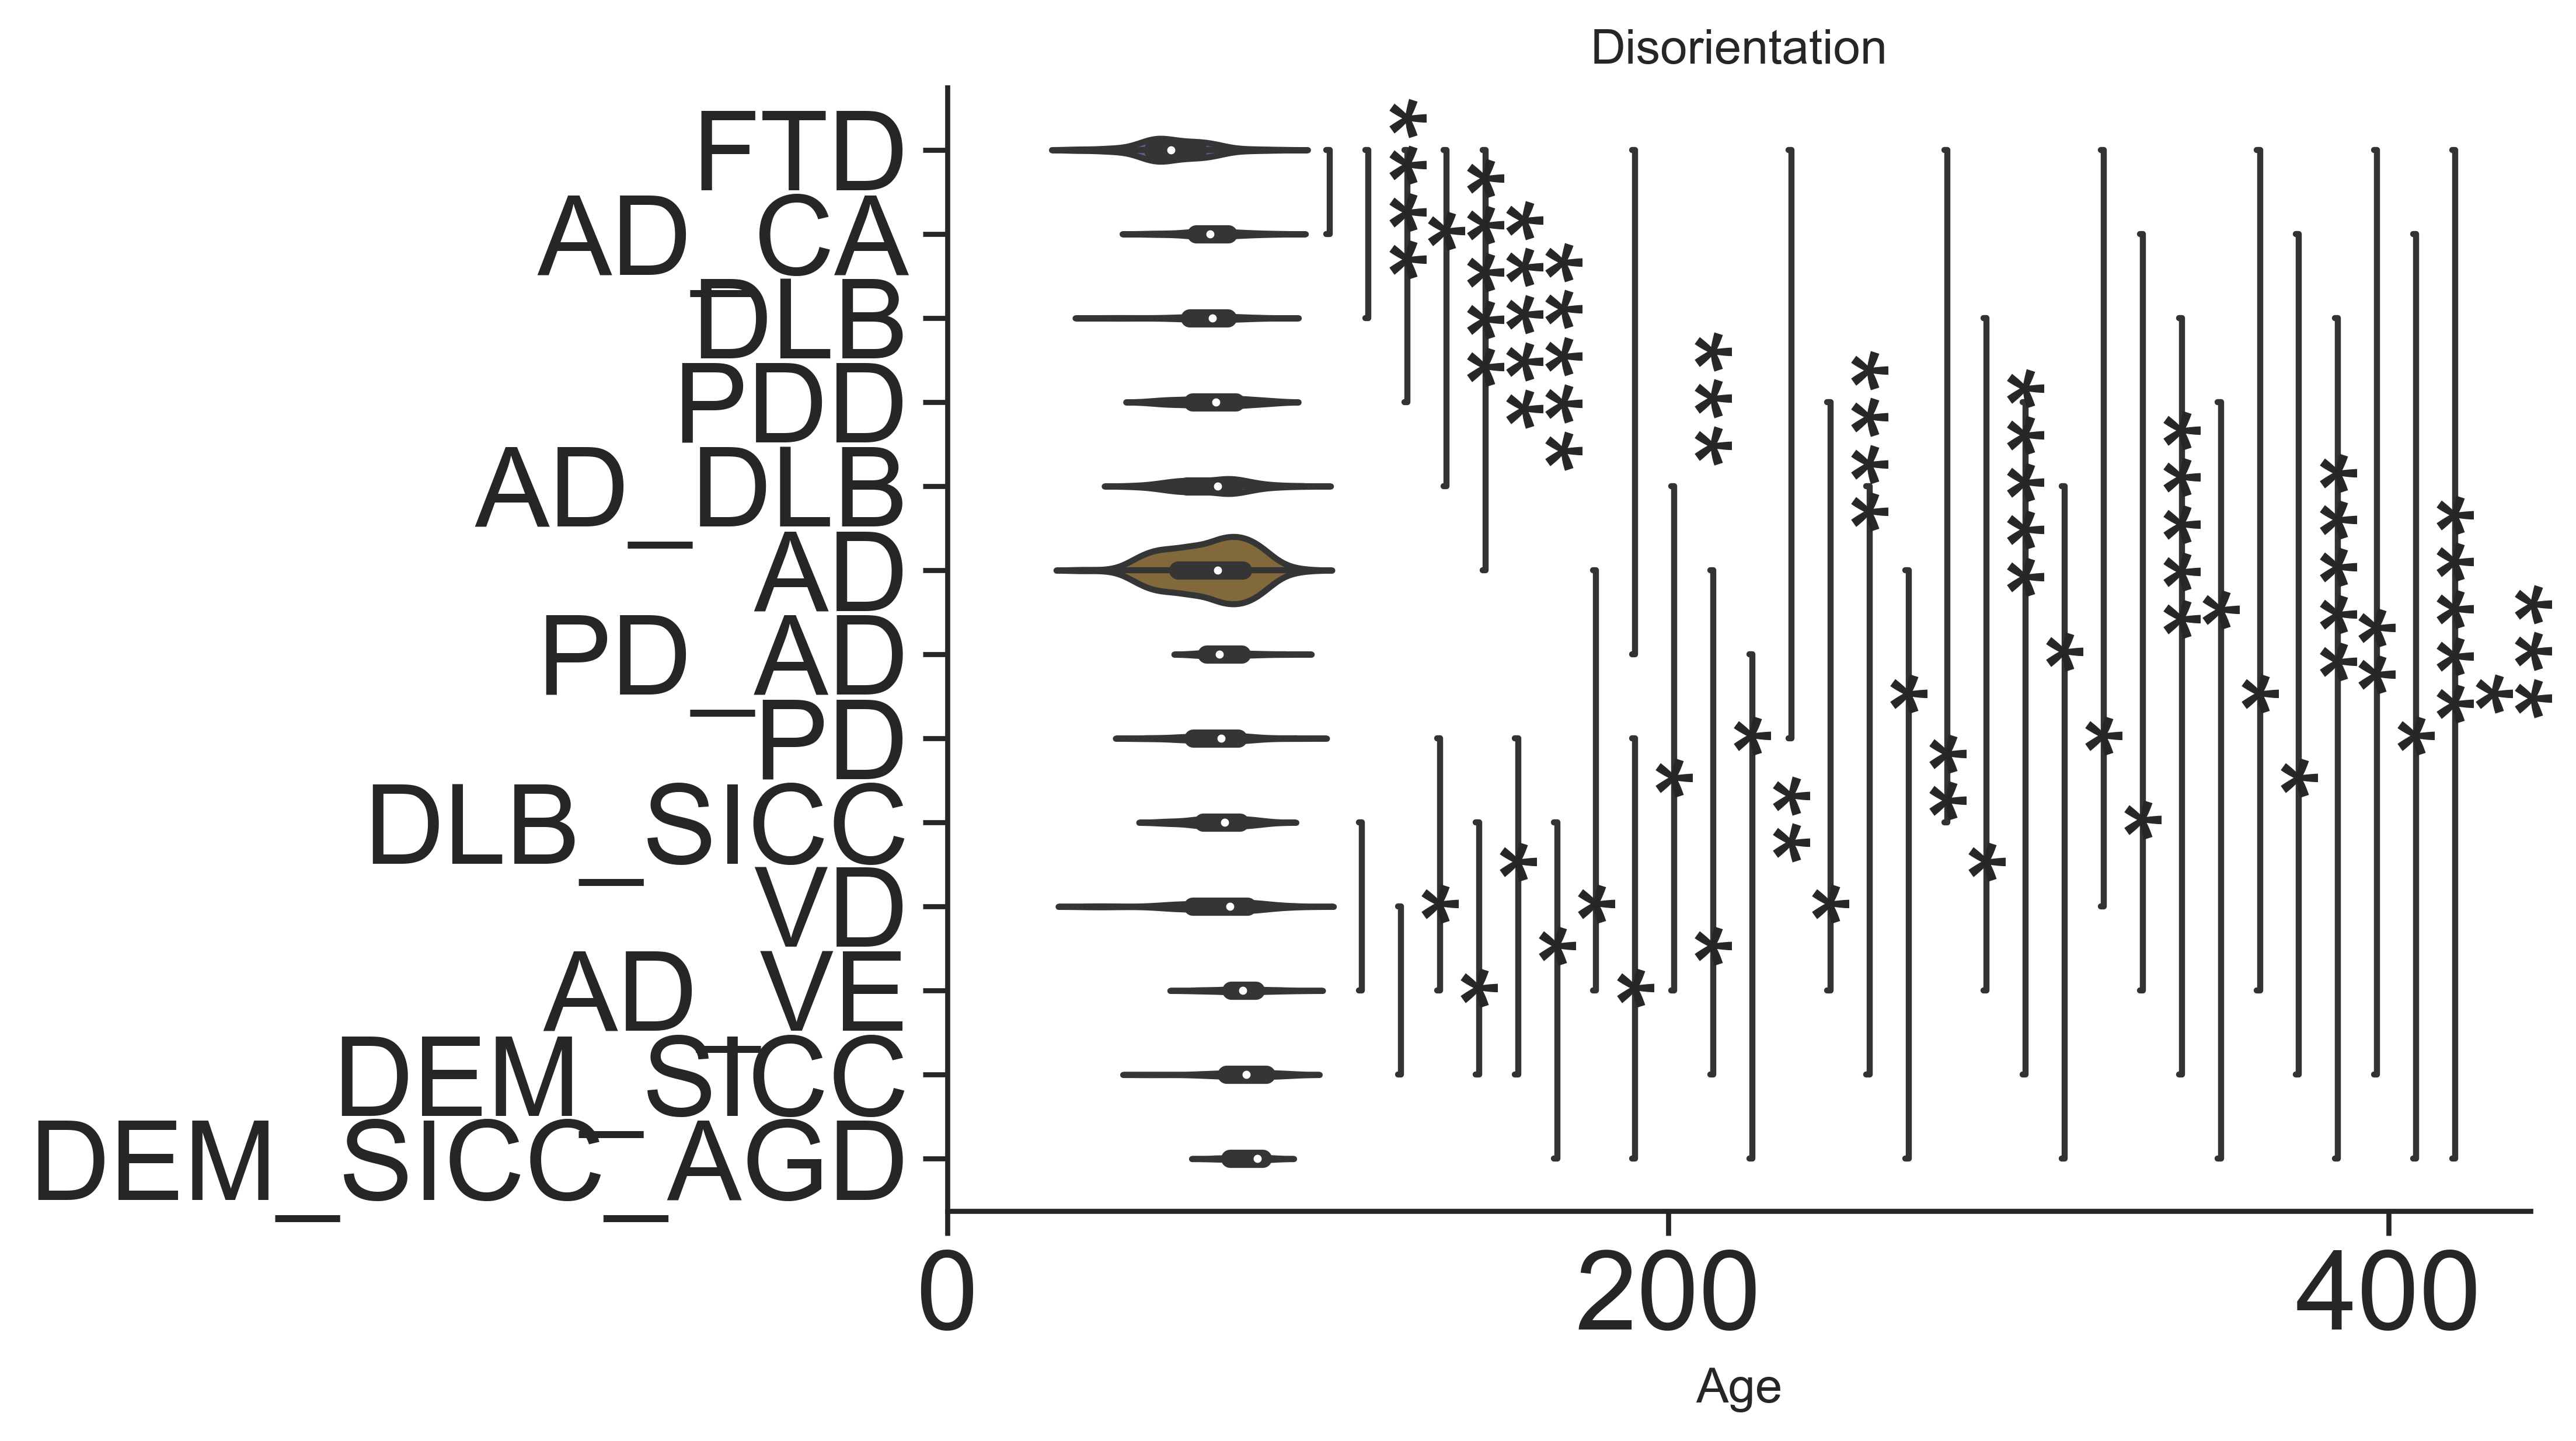

Memory_impairment
After selecting for ['PD' 'FTD' 'DEM_SICC' 'AD' 'AD_DLB' 'AD_CA' 'DLB_SICC' 'DEM_SICC_AGD'
 'VD' 'DEM_VE' 'PDD' 'AD_VE' 'DLB' 'PD_AD'], we have 1633  donors
Before removing zero donors


neuropathological_diagnosis sex  observations_Memory_impairment  donors
0                           AD   F                             561     491
1                           AD   M                             364     217
2                        AD_CA   F                              30      24
3                        AD_CA   M                              29      17
4                       AD_DLB   F                             120      75
5                       AD_DLB   M                              73      45
6                        AD_VE   F                              17      14
7                        AD_VE   M                              13      10
8                     DEM_SICC   F                              23      38
9                     DEM_SICC   M                              28      19
10                DEM_SICC_AGD   F                              14      10
11                DEM_SICC_AGD   M                               8       7
12                      DEM_VE   F                               8      10
13                      DEM_VE   M                               3       5
14                         DLB   F                              15       9
15                         DLB   M                              41      21
16                    DLB_SICC   F                              30      24
17                    DLB_SICC   M                              65      36
18                         FTD   F                             146      97
19                         FTD   M                             186     120
20                          PD   F                              32      51
21                          PD   M                              76      82
22                         PDD   F                              51      45
23                         PDD   M                             136      80
24                       PD_AD   F                              13      11
25                       PD_AD   M                              13      11
26                          VD   F                              30      25
27                          VD   M                              51      39

After removing zero donors


neuropathological_diagnosis sex  observations_Memory_impairment  donors
0                           AD   F                             561     312
1                           AD   M                             364     170
2                        AD_CA   F                              30      14
3                        AD_CA   M                              29      16
4                       AD_DLB   F                             120      60
5                       AD_DLB   M                              73      37
6                        AD_VE   F                              17      10
7                        AD_VE   M                              13       8
8                     DEM_SICC   F                              23      18
9                     DEM_SICC   M                              28      13
10                DEM_SICC_AGD   F                              14       6
11                DEM_SICC_AGD   M                               8       4
12                      DEM_VE   F                               8       5
13                      DEM_VE   M                               3       3
14                         DLB   F                              15       8
15                         DLB   M                              41      19
16                    DLB_SICC   F                              30      16
17                    DLB_SICC   M                              65      31
18                         FTD   F                             146      77
19                         FTD   M                             186      99
20                          PD   F                              32      20
21                          PD   M                              76      43
22                         PDD   F                              51      34
23                         PDD   M                             136      64
24                       PD_AD   F                              13       7
25                       PD_AD   M                              13       7
26                          VD   F                              30      19
27                          VD   M                              51      32





























After subsampling sexes


neuropathological_diagnosis sex  observations_Memory_impairment  donors
0                           AD   F                             330     170
1                           AD   M                             364     170
2                        AD_CA   F                              30      14
3                        AD_CA   M                              24      14
4                       AD_DLB   F                              73      37
5                       AD_DLB   M                              73      37
6                        AD_VE   F                              15       8
7                        AD_VE   M                              13       8
8                     DEM_SICC   F                              18      13
9                     DEM_SICC   M                              28      13
10                DEM_SICC_AGD   F                               7       4
11                DEM_SICC_AGD   M                               8       4
12                      DEM_VE   F                               5       3
13                      DEM_VE   M                               3       3
14                         DLB   F                              15       8
15                         DLB   M                              16       8
16                    DLB_SICC   F                              30      16
17                    DLB_SICC   M                              33      16
18                         FTD   F                             146      77
19                         FTD   M                             139      77
20                          PD   F                              32      20
21                          PD   M                              29      20
22                         PDD   F                              51      34
23                         PDD   M                              77      34
24                       PD_AD   F                              13       7
25                       PD_AD   M                              13       7
26                          VD   F                              30      19
27                          VD   M                              31      19

860 donors are used in the temporal plot
860 donors are used in the observations plot
FTD
AD_CA
AD_DLB
AD_VE
AD
DEM_SICC_AGD
DLB_SICC
DLB
DEM_SICC
DEM_VE
PD_AD
PDD
PD
VD


/home/jupyter-n.mekkes@gmail.com-f6d87/.conda/envs/clinical_history/lib/python3.11/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/home/jupyter-n.mekkes@gmail.com-f6d87/.conda/envs/clinical_history/lib/python3.11/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/home/jupyter-n.mekkes@gmail.com-f6d87/.conda/envs/clinical_history/lib/python3.11/site-packages/statannotations/Annotator.py:805: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "


p-value annotation legend:
       *: p <= 1.00e-02
      **: 1.00e-06 < p <= 1.00e-04
     ***: 1.00e-08 < p <= 1.00e-06
    ****: 1.00e-10 < p <= 1.00e-08
   *****: p <= 1.00e-10

FTD vs. PD: Custom statistical test, P_val:1.056e-05
FTD vs. PDD: Custom statistical test, P_val:2.464e-15
VD vs. AD_VE: Custom statistical test, P_val:8.500e-03
FTD vs. AD_CA: Custom statistical test, P_val:7.453e-11
VD vs. DEM_SICC_AGD: Custom statistical test, P_val:7.443e-04
DEM_SICC vs. DEM_VE: Custom statistical test, P_val:8.500e-03
FTD vs. AD: Custom statistical test, P_val:1.268e-23
DLB vs. AD_VE: Custom statistical test, P_val:9.040e-05
PD_AD vs. DEM_SICC_AGD: Custom statistical test, P_val:3.990e-03
VD vs. DEM_VE: Custom statistical test, P_val:1.257e-03
FTD vs. DLB_SICC: Custom statistical test, P_val:2.916e-16
AD_DLB vs. AD_VE: Custom statistical test, P_val:4.192e-06
DLB vs. DEM_SICC_AGD: Custom statistical test, P_val:1.056e-05
FTD vs. AD_DLB: Custom statistical test, P_val:2.114e-16
PDD vs. P

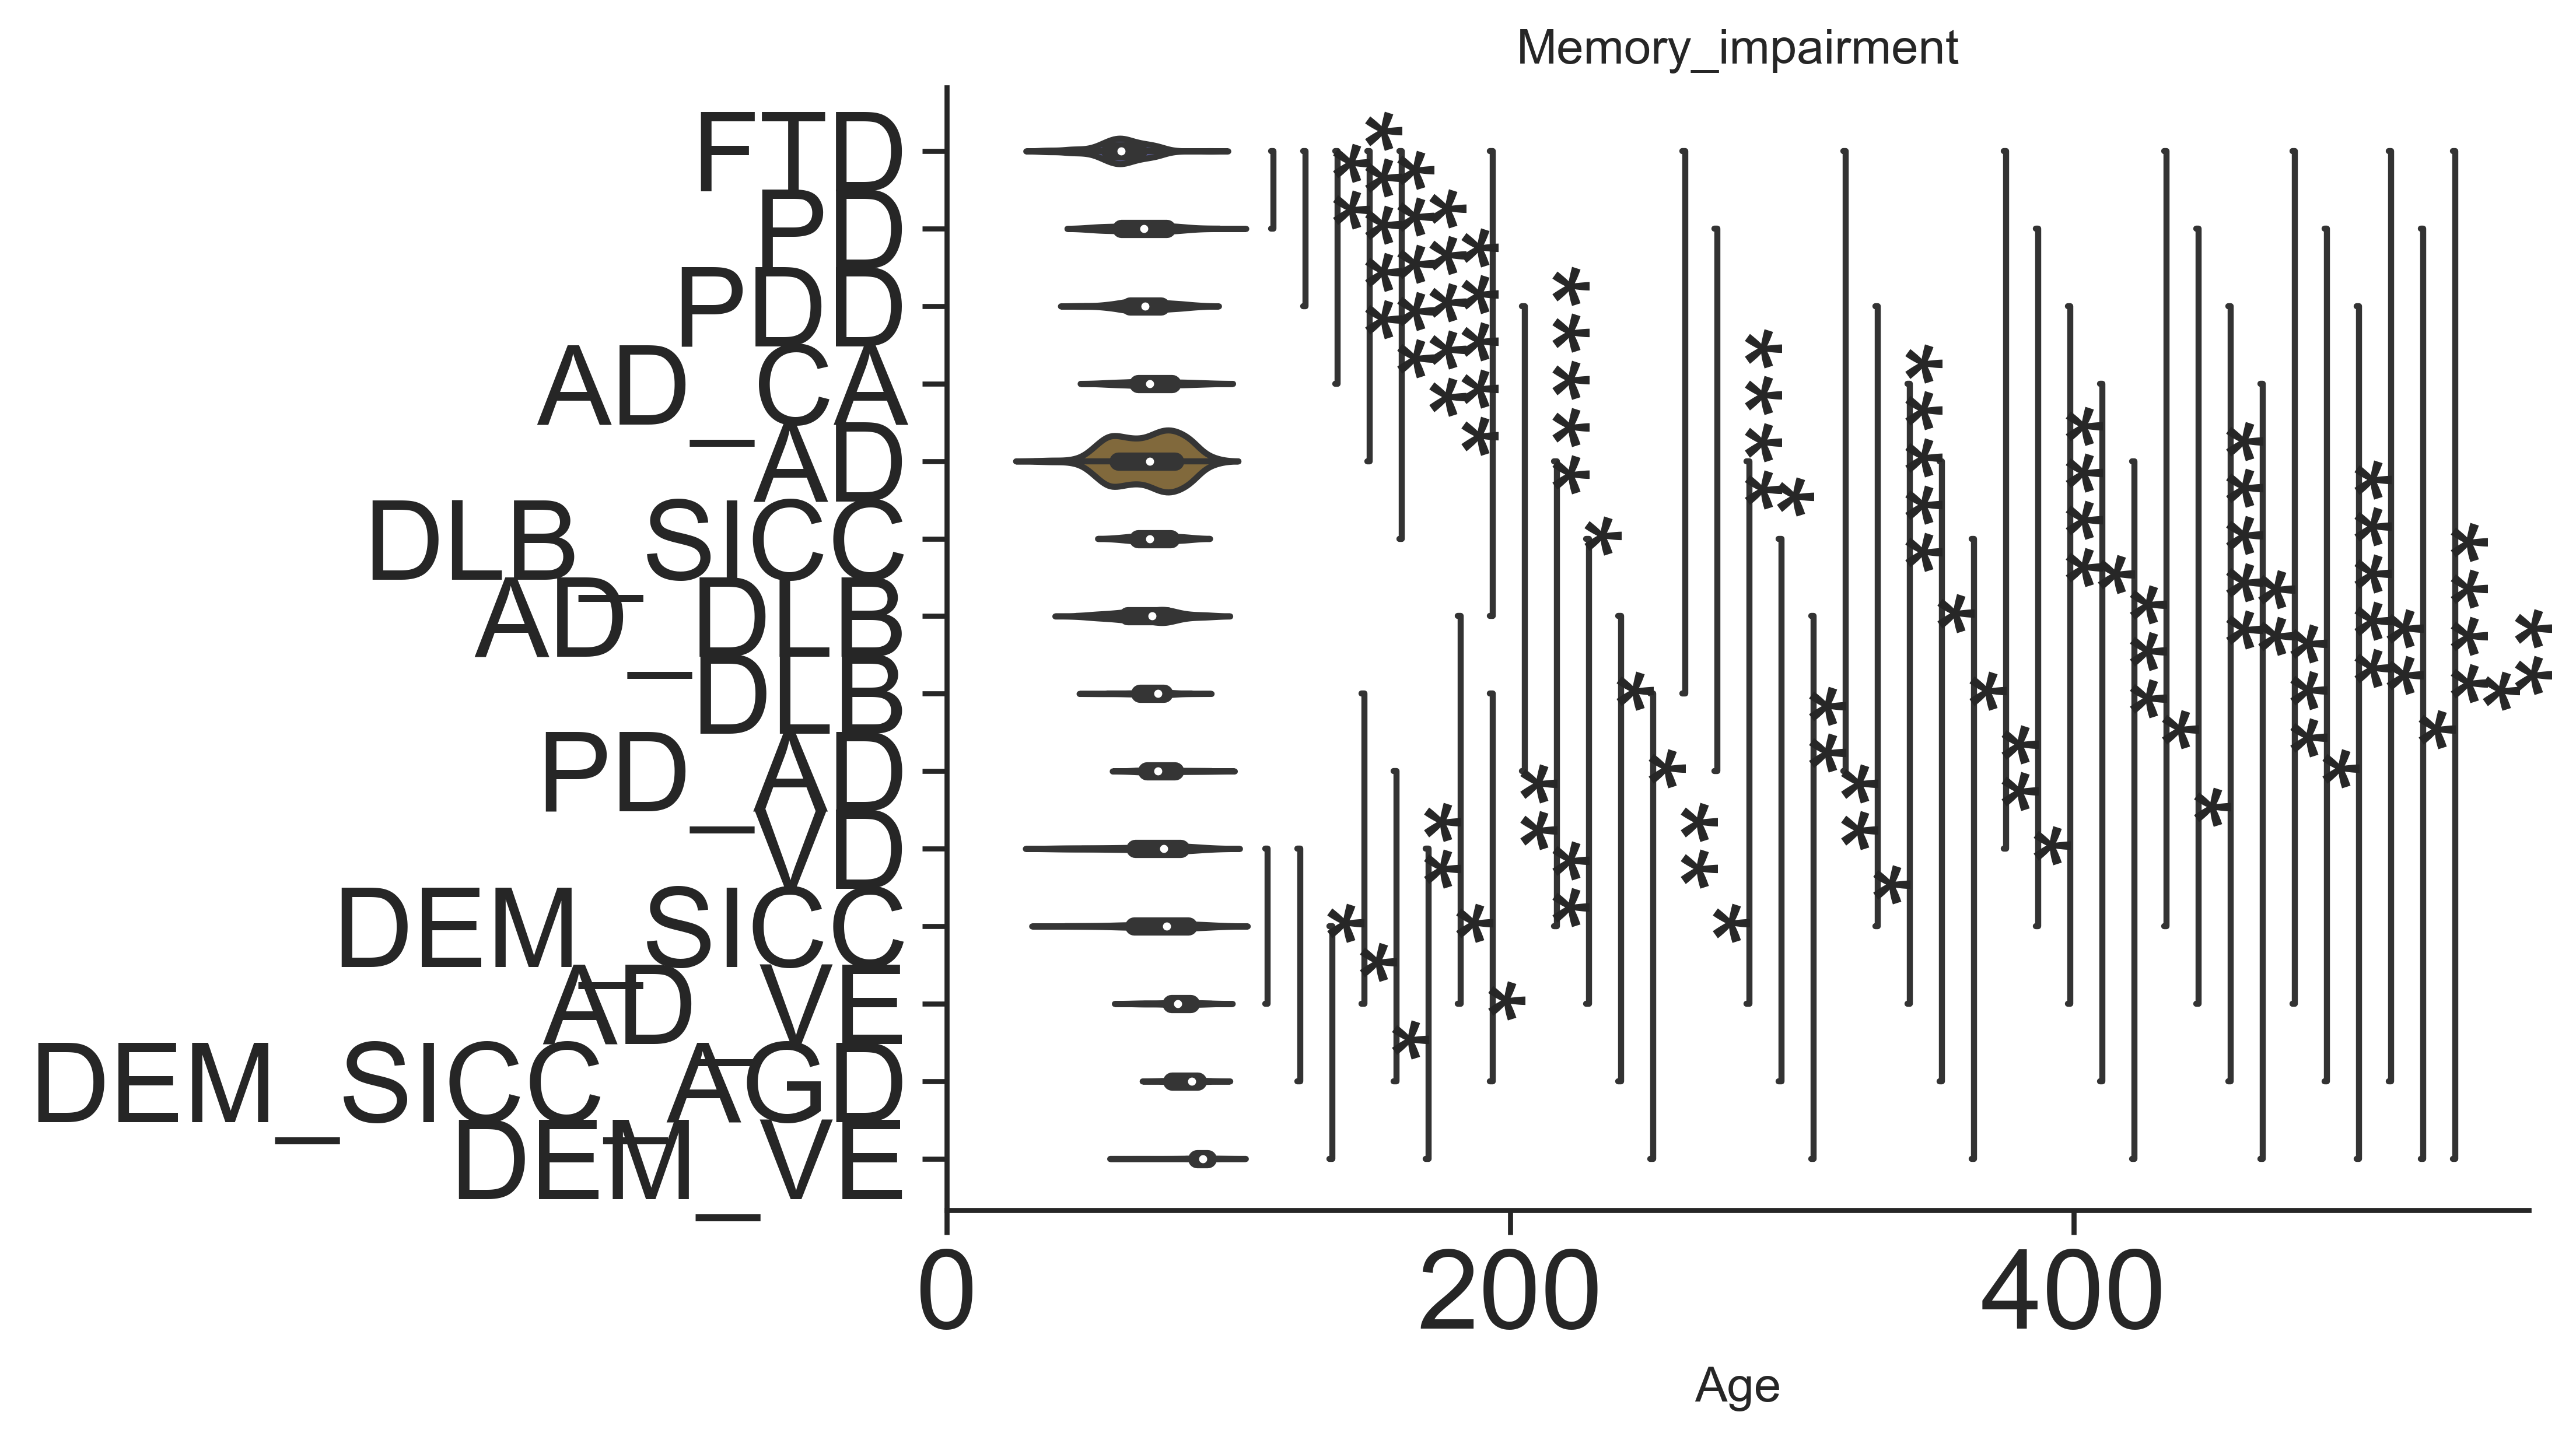

In [113]:
table_of_choice = 'table5_p'
# display(sorted(predictions_df_temporal['neuropathological_diagnosis'].unique()))
selected_donors,diagnoses = table_selector(table_of_choice, predictions_df_temporal)
print(f"After selecting for {selected_donors['neuropathological_diagnosis'].unique()}, we have {selected_donors['DonorID'].nunique()}  donors")

color_palette = sns.color_palette("tab20b")[0:21]
table_diagnosis_colors_dic = {} 
counter = 0 

for diagnosis in diagnoses:
    table_diagnosis_colors_dic[diagnosis] = color_palette[counter]
    counter+=1
    
trait_attribute_dictionary = {} 
trait_attribute_dictionary['Dementia'] =  ['FTD','AD_CA', 'AD_DLB', 'AD_VE', 'AD', 'DEM_SICC_AGD', 'DLB_SICC','DLB', 'DEM_SICC', 'DEM_VE', 'PD_AD', 'PDD', 'PD', 'VD']
trait_attribute_dictionary['Disorientation'] =  ['FTD','AD_CA', 'AD_DLB', 'AD_VE', 'AD', 'DEM_SICC_AGD','DLB_SICC', 'DLB', 'DEM_SICC', 'DEM_VE', 'PD_AD', 'PDD', 'PD', 'VD']
trait_attribute_dictionary['Memory_impairment'] =  ['FTD','AD_CA', 'AD_DLB', 'AD_VE', 'AD',  'DEM_SICC_AGD','DLB_SICC', 'DLB', 'DEM_SICC', 'DEM_VE', 'PD_AD', 'PDD', 'PD', 'VD']

make_labeled_violinplots_horizontal(trait_attribute_dictionary,
                                    selected_donors,
                                    table_diagnosis_colors_dic,
                                    110,
                                   'temporal',
                                   'ext_3_rare_dem_temporal',
                                    heatmap=False,
                                   printvalues=True,
                                   fixsex=True,
                                   remove_zero_donors = True,
                                   w=7,
                                   h=5                                   )


The plot type is counts
Dementia
After selecting for ['PD' 'FTD' 'DEM_SICC' 'AD' 'AD_DLB' 'AD_CA' 'DLB_SICC' 'DEM_SICC_AGD'
 'VD' 'DEM_VE' 'PDD' 'AD_VE' 'DLB' 'PD_AD'], we have 1633  donors
Before removing zero donors


neuropathological_diagnosis sex  observations_Dementia  donors
0                           AD   F                    717     491
1                           AD   M                    360     217
2                        AD_CA   F                     40      24
3                        AD_CA   M                     28      17
4                       AD_DLB   F                    123      75
5                       AD_DLB   M                     91      45
6                        AD_VE   F                     10      14
7                        AD_VE   M                     13      10
8                     DEM_SICC   F                     28      38
9                     DEM_SICC   M                     20      19
10                DEM_SICC_AGD   F                      9      10
11                DEM_SICC_AGD   M                     12       7
12                      DEM_VE   F                     11      10
13                      DEM_VE   M                      1       5
14                         DLB   F                     13       9
15                         DLB   M                     26      21
16                    DLB_SICC   F                     33      24
17                    DLB_SICC   M                     56      36
18                         FTD   F                    175      97
19                         FTD   M                    208     120
20                          PD   F                     15      51
21                          PD   M                     32      82
22                         PDD   F                     45      45
23                         PDD   M                     99      80
24                       PD_AD   F                     11      11
25                       PD_AD   M                     14      11
26                          VD   F                     24      25
27                          VD   M                     42      39





























After subsampling sexes


neuropathological_diagnosis sex  observations_Dementia  donors
0                           AD   F                    328     217
1                           AD   M                    360     217
2                        AD_CA   F                     31      17
3                        AD_CA   M                     28      17
4                       AD_DLB   F                     75      45
5                       AD_DLB   M                     91      45
6                        AD_VE   F                      7      10
7                        AD_VE   M                     13      10
8                     DEM_SICC   F                     11      19
9                     DEM_SICC   M                     20      19
10                DEM_SICC_AGD   F                      7       7
11                DEM_SICC_AGD   M                     12       7
12                      DEM_VE   F                      6       5
13                      DEM_VE   M                      1       5
14                         DLB   F                     13       9
15                         DLB   M                      5       9
16                    DLB_SICC   F                     33      24
17                    DLB_SICC   M                     30      24
18                         FTD   F                    175      97
19                         FTD   M                    157      97
20                          PD   F                     15      51
21                          PD   M                     15      51
22                         PDD   F                     45      45
23                         PDD   M                     59      45
24                       PD_AD   F                     11      11
25                       PD_AD   M                     14      11
26                          VD   F                     24      25
27                          VD   M                     25      25

877 donors are used in the temporal plot
1164 donors are used in the observations plot
FTD


/tmp/ipykernel_10217/3446875031.py:83: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df.groupby(['DonorID']).sum() ## sums all observations of symptom for donor. note, many donors have 0 (e.g. control)


'194 donors in the counts df'

AD_CA


/tmp/ipykernel_10217/3446875031.py:83: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df.groupby(['DonorID']).sum() ## sums all observations of symptom for donor. note, many donors have 0 (e.g. control)


'34 donors in the counts df'

AD_DLB


/tmp/ipykernel_10217/3446875031.py:83: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df.groupby(['DonorID']).sum() ## sums all observations of symptom for donor. note, many donors have 0 (e.g. control)


'90 donors in the counts df'

AD_VE


/tmp/ipykernel_10217/3446875031.py:83: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df.groupby(['DonorID']).sum() ## sums all observations of symptom for donor. note, many donors have 0 (e.g. control)


'20 donors in the counts df'

AD


/tmp/ipykernel_10217/3446875031.py:83: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df.groupby(['DonorID']).sum() ## sums all observations of symptom for donor. note, many donors have 0 (e.g. control)


'434 donors in the counts df'

DEM_SICC_AGD


/tmp/ipykernel_10217/3446875031.py:83: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df.groupby(['DonorID']).sum() ## sums all observations of symptom for donor. note, many donors have 0 (e.g. control)


'14 donors in the counts df'

DLB_SICC


/tmp/ipykernel_10217/3446875031.py:83: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df.groupby(['DonorID']).sum() ## sums all observations of symptom for donor. note, many donors have 0 (e.g. control)


'48 donors in the counts df'

DLB


/tmp/ipykernel_10217/3446875031.py:83: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df.groupby(['DonorID']).sum() ## sums all observations of symptom for donor. note, many donors have 0 (e.g. control)


'18 donors in the counts df'

DEM_SICC


/tmp/ipykernel_10217/3446875031.py:83: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df.groupby(['DonorID']).sum() ## sums all observations of symptom for donor. note, many donors have 0 (e.g. control)


'38 donors in the counts df'

DEM_VE


/tmp/ipykernel_10217/3446875031.py:83: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df.groupby(['DonorID']).sum() ## sums all observations of symptom for donor. note, many donors have 0 (e.g. control)


'10 donors in the counts df'

PD_AD


/tmp/ipykernel_10217/3446875031.py:83: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df.groupby(['DonorID']).sum() ## sums all observations of symptom for donor. note, many donors have 0 (e.g. control)


'22 donors in the counts df'

PDD


/tmp/ipykernel_10217/3446875031.py:83: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df.groupby(['DonorID']).sum() ## sums all observations of symptom for donor. note, many donors have 0 (e.g. control)


'90 donors in the counts df'

PD


/tmp/ipykernel_10217/3446875031.py:83: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df.groupby(['DonorID']).sum() ## sums all observations of symptom for donor. note, many donors have 0 (e.g. control)


'102 donors in the counts df'

VD


/tmp/ipykernel_10217/3446875031.py:83: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df.groupby(['DonorID']).sum() ## sums all observations of symptom for donor. note, many donors have 0 (e.g. control)


'50 donors in the counts df'

/home/jupyter-n.mekkes@gmail.com-f6d87/.conda/envs/clinical_history/lib/python3.11/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/home/jupyter-n.mekkes@gmail.com-f6d87/.conda/envs/clinical_history/lib/python3.11/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/home/jupyter-n.mekkes@gmail.com-f6d87/.conda/envs/clinical_history/lib/python3.11/site-packages/statannotations/Annotator.py:805: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "


p-value annotation legend:
       *: p <= 1.00e-02
      **: 1.00e-06 < p <= 1.00e-04
     ***: 1.00e-08 < p <= 1.00e-06
    ****: 1.00e-10 < p <= 1.00e-08
   *****: p <= 1.00e-10

VD vs. FTD: Custom statistical test, P_val:1.413e-04
PD vs. AD_CA: Custom statistical test, P_val:2.170e-11
PDD vs. FTD: Custom statistical test, P_val:6.624e-04
VD vs. AD_DLB: Custom statistical test, P_val:6.804e-05
PD vs. AD_VE: Custom statistical test, P_val:4.147e-04
PDD vs. AD_DLB: Custom statistical test, P_val:4.260e-04
PD vs. AD: Custom statistical test, P_val:1.993e-26
AD vs. DEM_SICC: Custom statistical test, P_val:4.260e-04
DEM_SICC vs. FTD: Custom statistical test, P_val:2.943e-05
PD vs. DEM_SICC_AGD: Custom statistical test, P_val:1.511e-05
DEM_SICC vs. AD_DLB: Custom statistical test, P_val:2.943e-05
PD vs. DLB_SICC: Custom statistical test, P_val:5.344e-10
AD_CA vs. DEM_SICC: Custom statistical test, P_val:4.992e-03
DLB vs. AD_DLB: Custom statistical test, P_val:6.948e-03
PD vs. DLB: Custom s

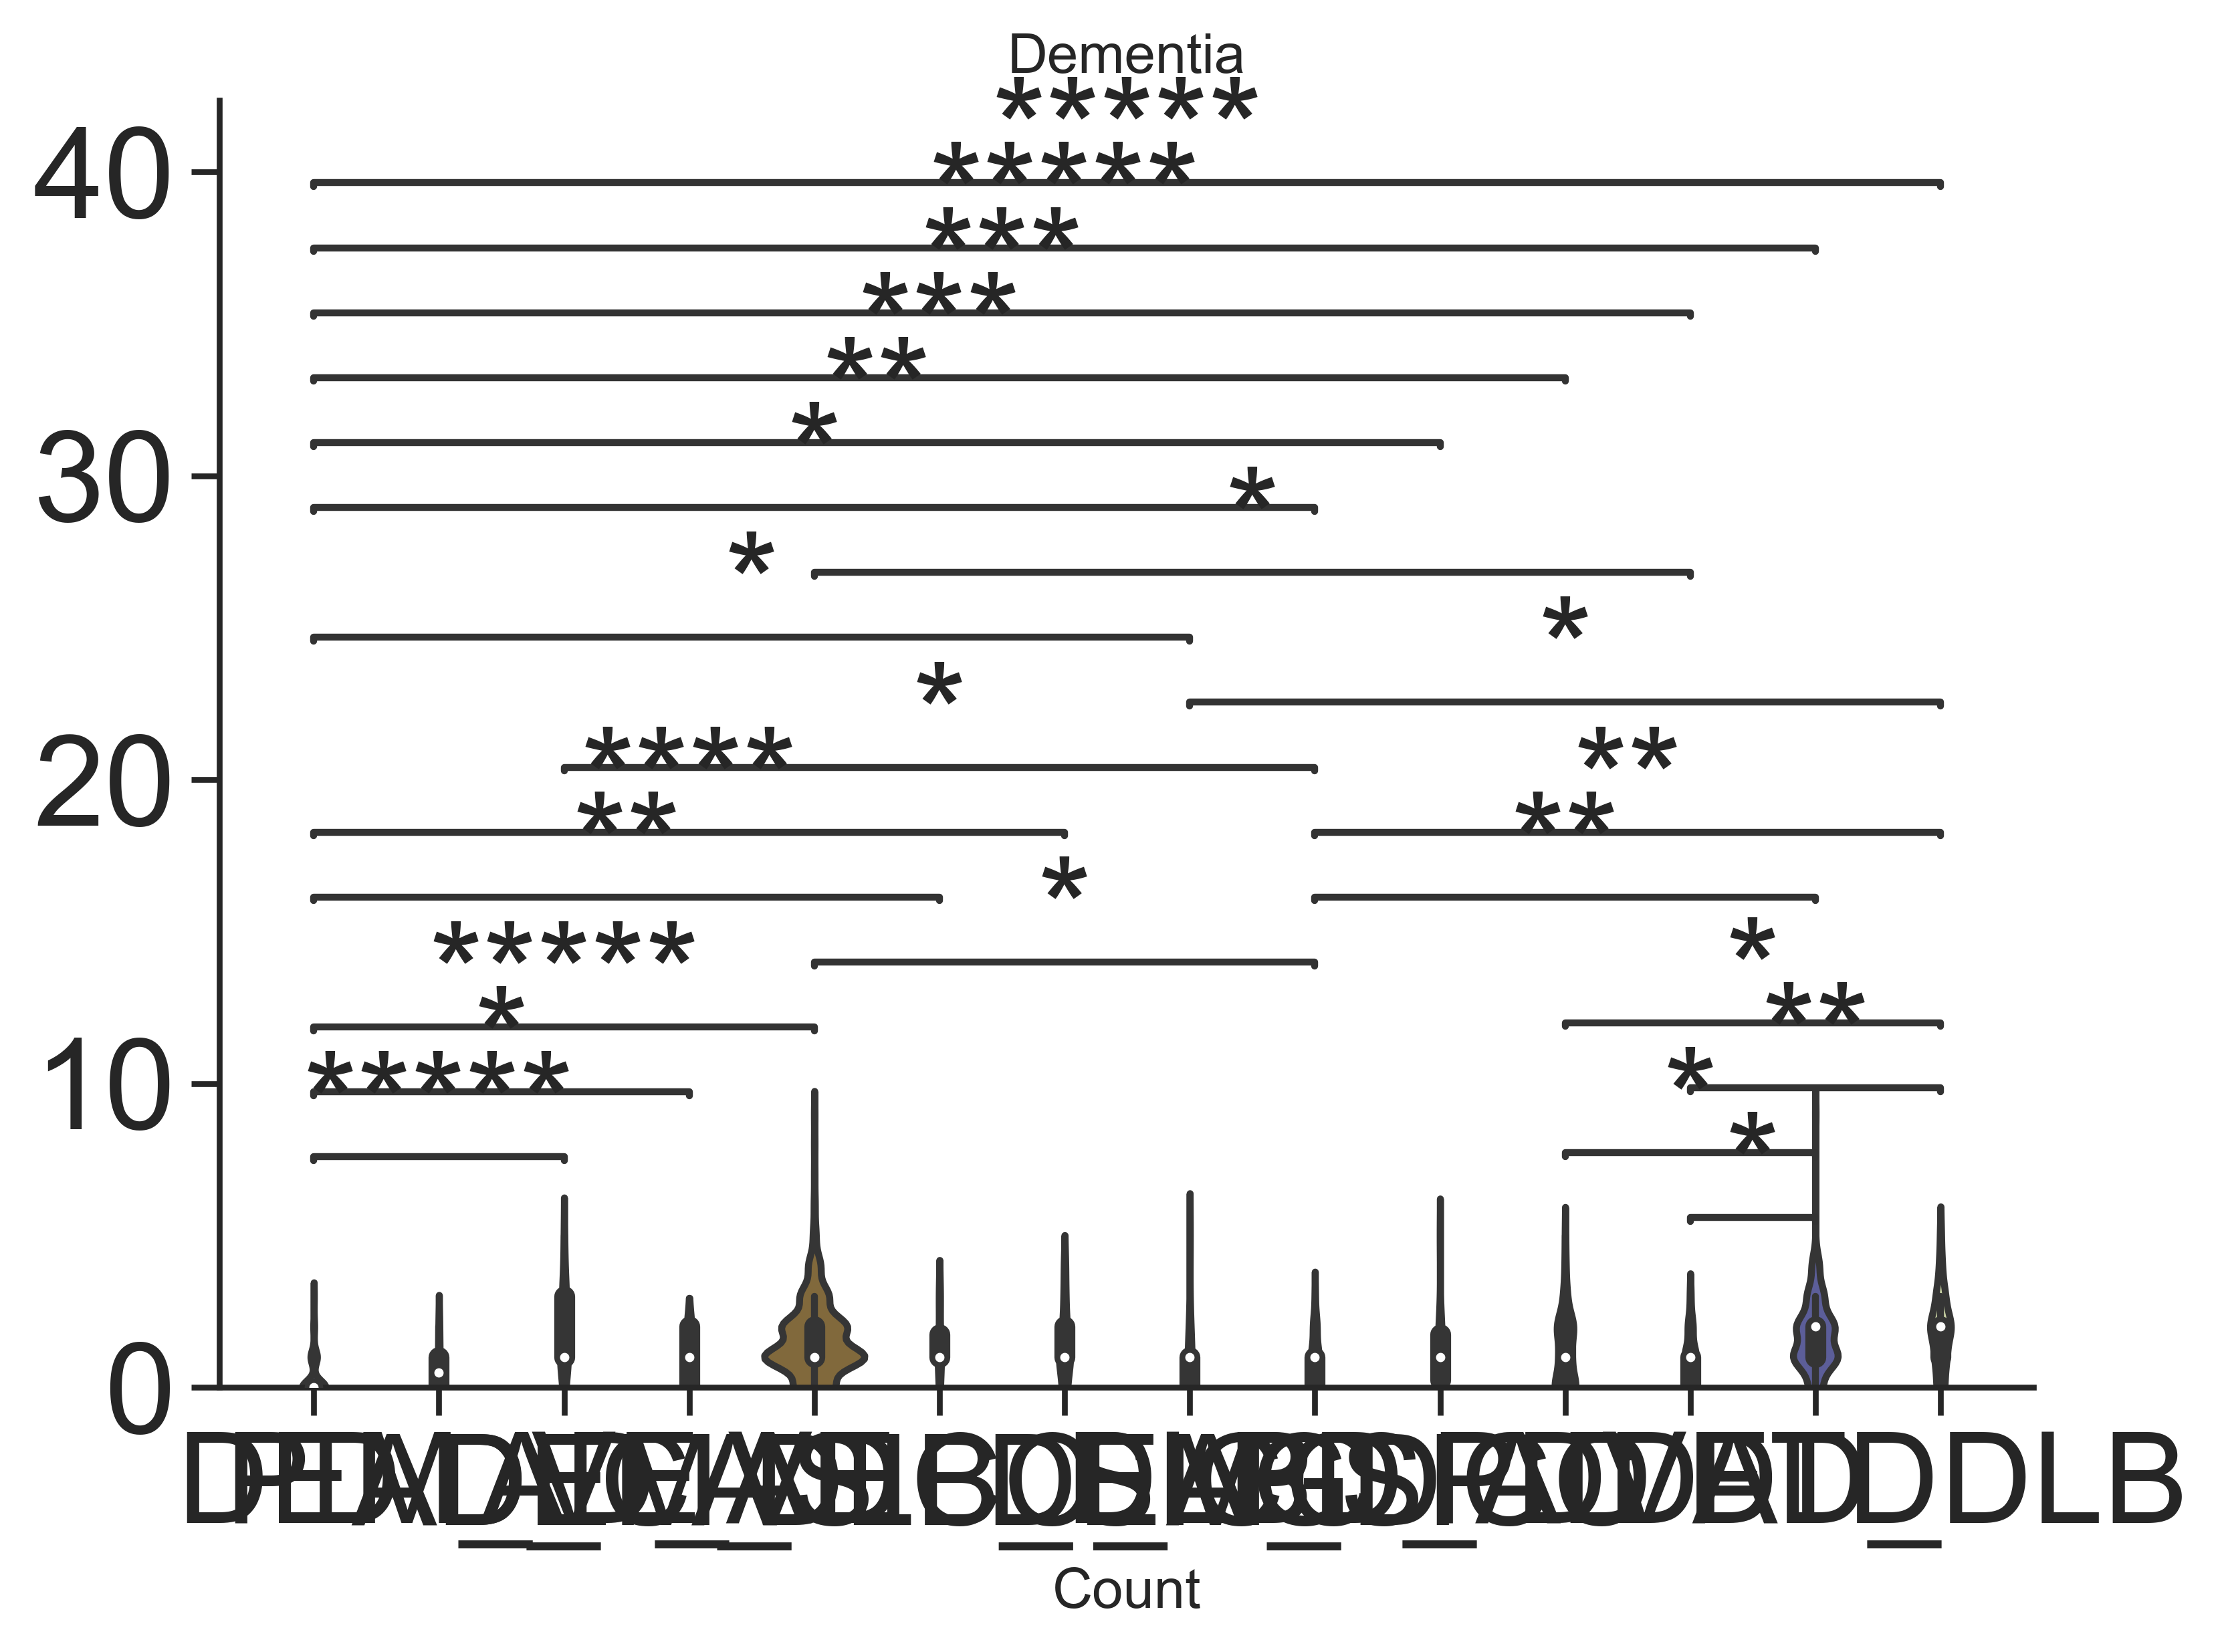

Disorientation
After selecting for ['PD' 'FTD' 'DEM_SICC' 'AD' 'AD_DLB' 'AD_CA' 'DLB_SICC' 'DEM_SICC_AGD'
 'VD' 'DEM_VE' 'PDD' 'AD_VE' 'DLB' 'PD_AD'], we have 1633  donors
Before removing zero donors


neuropathological_diagnosis sex  observations_Disorientation  donors
0                           AD   F                          508     491
1                           AD   M                          248     217
2                        AD_CA   F                           26      24
3                        AD_CA   M                           18      17
4                       AD_DLB   F                           89      75
5                       AD_DLB   M                           51      45
6                        AD_VE   F                           13      14
7                        AD_VE   M                           11      10
8                     DEM_SICC   F                           20      38
9                     DEM_SICC   M                           17      19
10                DEM_SICC_AGD   F                           11      10
11                DEM_SICC_AGD   M                            7       7
12                      DEM_VE   F                            7      10
13                      DEM_VE   M                            0       5
14                         DLB   F                           10       9
15                         DLB   M                           29      21
16                    DLB_SICC   F                           25      24
17                    DLB_SICC   M                           45      36
18                         FTD   F                           78      97
19                         FTD   M                          103     120
20                          PD   F                           18      51
21                          PD   M                           38      82
22                         PDD   F                           37      45
23                         PDD   M                           62      80
24                       PD_AD   F                           11      11
25                       PD_AD   M                           13      11
26                          VD   F                           30      25
27                          VD   M                           35      39





























After subsampling sexes


neuropathological_diagnosis sex  observations_Disorientation  donors
0                           AD   F                          245     217
1                           AD   M                          248     217
2                        AD_CA   F                           20      17
3                        AD_CA   M                           18      17
4                       AD_DLB   F                           53      45
5                       AD_DLB   M                           51      45
6                        AD_VE   F                           12      10
7                        AD_VE   M                           11      10
8                     DEM_SICC   F                           11      19
9                     DEM_SICC   M                           17      19
10                DEM_SICC_AGD   F                            7       7
11                DEM_SICC_AGD   M                            7       7
12                      DEM_VE   F                            1       5
13                      DEM_VE   M                            0       5
14                         DLB   F                           10       9
15                         DLB   M                           10       9
16                    DLB_SICC   F                           25      24
17                    DLB_SICC   M                           33      24
18                         FTD   F                           78      97
19                         FTD   M                           82      97
20                          PD   F                           18      51
21                          PD   M                           23      51
22                         PDD   F                           37      45
23                         PDD   M                           37      45
24                       PD_AD   F                           11      11
25                       PD_AD   M                           13      11
26                          VD   F                           30      25
27                          VD   M                           20      25

728 donors are used in the temporal plot
1164 donors are used in the observations plot
FTD


/tmp/ipykernel_10217/3446875031.py:83: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df.groupby(['DonorID']).sum() ## sums all observations of symptom for donor. note, many donors have 0 (e.g. control)


'194 donors in the counts df'

AD_CA


/tmp/ipykernel_10217/3446875031.py:83: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df.groupby(['DonorID']).sum() ## sums all observations of symptom for donor. note, many donors have 0 (e.g. control)


'34 donors in the counts df'

AD_DLB


/tmp/ipykernel_10217/3446875031.py:83: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df.groupby(['DonorID']).sum() ## sums all observations of symptom for donor. note, many donors have 0 (e.g. control)


'90 donors in the counts df'

AD_VE


/tmp/ipykernel_10217/3446875031.py:83: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df.groupby(['DonorID']).sum() ## sums all observations of symptom for donor. note, many donors have 0 (e.g. control)


'20 donors in the counts df'

AD


/tmp/ipykernel_10217/3446875031.py:83: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df.groupby(['DonorID']).sum() ## sums all observations of symptom for donor. note, many donors have 0 (e.g. control)


'434 donors in the counts df'

DEM_SICC_AGD


/tmp/ipykernel_10217/3446875031.py:83: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df.groupby(['DonorID']).sum() ## sums all observations of symptom for donor. note, many donors have 0 (e.g. control)


'14 donors in the counts df'

DLB_SICC


/tmp/ipykernel_10217/3446875031.py:83: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df.groupby(['DonorID']).sum() ## sums all observations of symptom for donor. note, many donors have 0 (e.g. control)


'48 donors in the counts df'

DLB


/tmp/ipykernel_10217/3446875031.py:83: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df.groupby(['DonorID']).sum() ## sums all observations of symptom for donor. note, many donors have 0 (e.g. control)


'18 donors in the counts df'

DEM_SICC


/tmp/ipykernel_10217/3446875031.py:83: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df.groupby(['DonorID']).sum() ## sums all observations of symptom for donor. note, many donors have 0 (e.g. control)


'38 donors in the counts df'

DEM_VE


/tmp/ipykernel_10217/3446875031.py:83: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df.groupby(['DonorID']).sum() ## sums all observations of symptom for donor. note, many donors have 0 (e.g. control)


'10 donors in the counts df'

PD_AD


/tmp/ipykernel_10217/3446875031.py:83: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df.groupby(['DonorID']).sum() ## sums all observations of symptom for donor. note, many donors have 0 (e.g. control)


'22 donors in the counts df'

PDD


/tmp/ipykernel_10217/3446875031.py:83: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df.groupby(['DonorID']).sum() ## sums all observations of symptom for donor. note, many donors have 0 (e.g. control)


'90 donors in the counts df'

PD


/tmp/ipykernel_10217/3446875031.py:83: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df.groupby(['DonorID']).sum() ## sums all observations of symptom for donor. note, many donors have 0 (e.g. control)


'102 donors in the counts df'

VD


/tmp/ipykernel_10217/3446875031.py:83: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df.groupby(['DonorID']).sum() ## sums all observations of symptom for donor. note, many donors have 0 (e.g. control)


'50 donors in the counts df'

/home/jupyter-n.mekkes@gmail.com-f6d87/.conda/envs/clinical_history/lib/python3.11/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/home/jupyter-n.mekkes@gmail.com-f6d87/.conda/envs/clinical_history/lib/python3.11/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/home/jupyter-n.mekkes@gmail.com-f6d87/.conda/envs/clinical_history/lib/python3.11/site-packages/statannotations/Annotator.py:805: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "


p-value annotation legend:
       *: p <= 1.00e-02
      **: 1.00e-06 < p <= 1.00e-04
     ***: 1.00e-08 < p <= 1.00e-06
    ****: 1.00e-10 < p <= 1.00e-08
   *****: p <= 1.00e-10

PD vs. FTD: Custom statistical test, P_val:1.426e-05
PD vs. AD_CA: Custom statistical test, P_val:1.407e-05
DEM_VE vs. AD_CA: Custom statistical test, P_val:3.398e-03
PD vs. AD_DLB: Custom statistical test, P_val:1.196e-07
DEM_VE vs. AD_DLB: Custom statistical test, P_val:4.641e-03
PD vs. AD_VE: Custom statistical test, P_val:2.717e-03
FTD vs. AD: Custom statistical test, P_val:4.641e-03
PD vs. AD: Custom statistical test, P_val:8.850e-12
DEM_VE vs. AD: Custom statistical test, P_val:3.159e-03
PD vs. DEM_SICC_AGD: Custom statistical test, P_val:5.951e-03
PD vs. DLB_SICC: Custom statistical test, P_val:1.196e-07
DEM_VE vs. DLB_SICC: Custom statistical test, P_val:1.780e-03
PD vs. DLB: Custom statistical test, P_val:3.398e-03
PD vs. PD_AD: Custom statistical test, P_val:6.918e-03
PD vs. PDD: Custom statistical

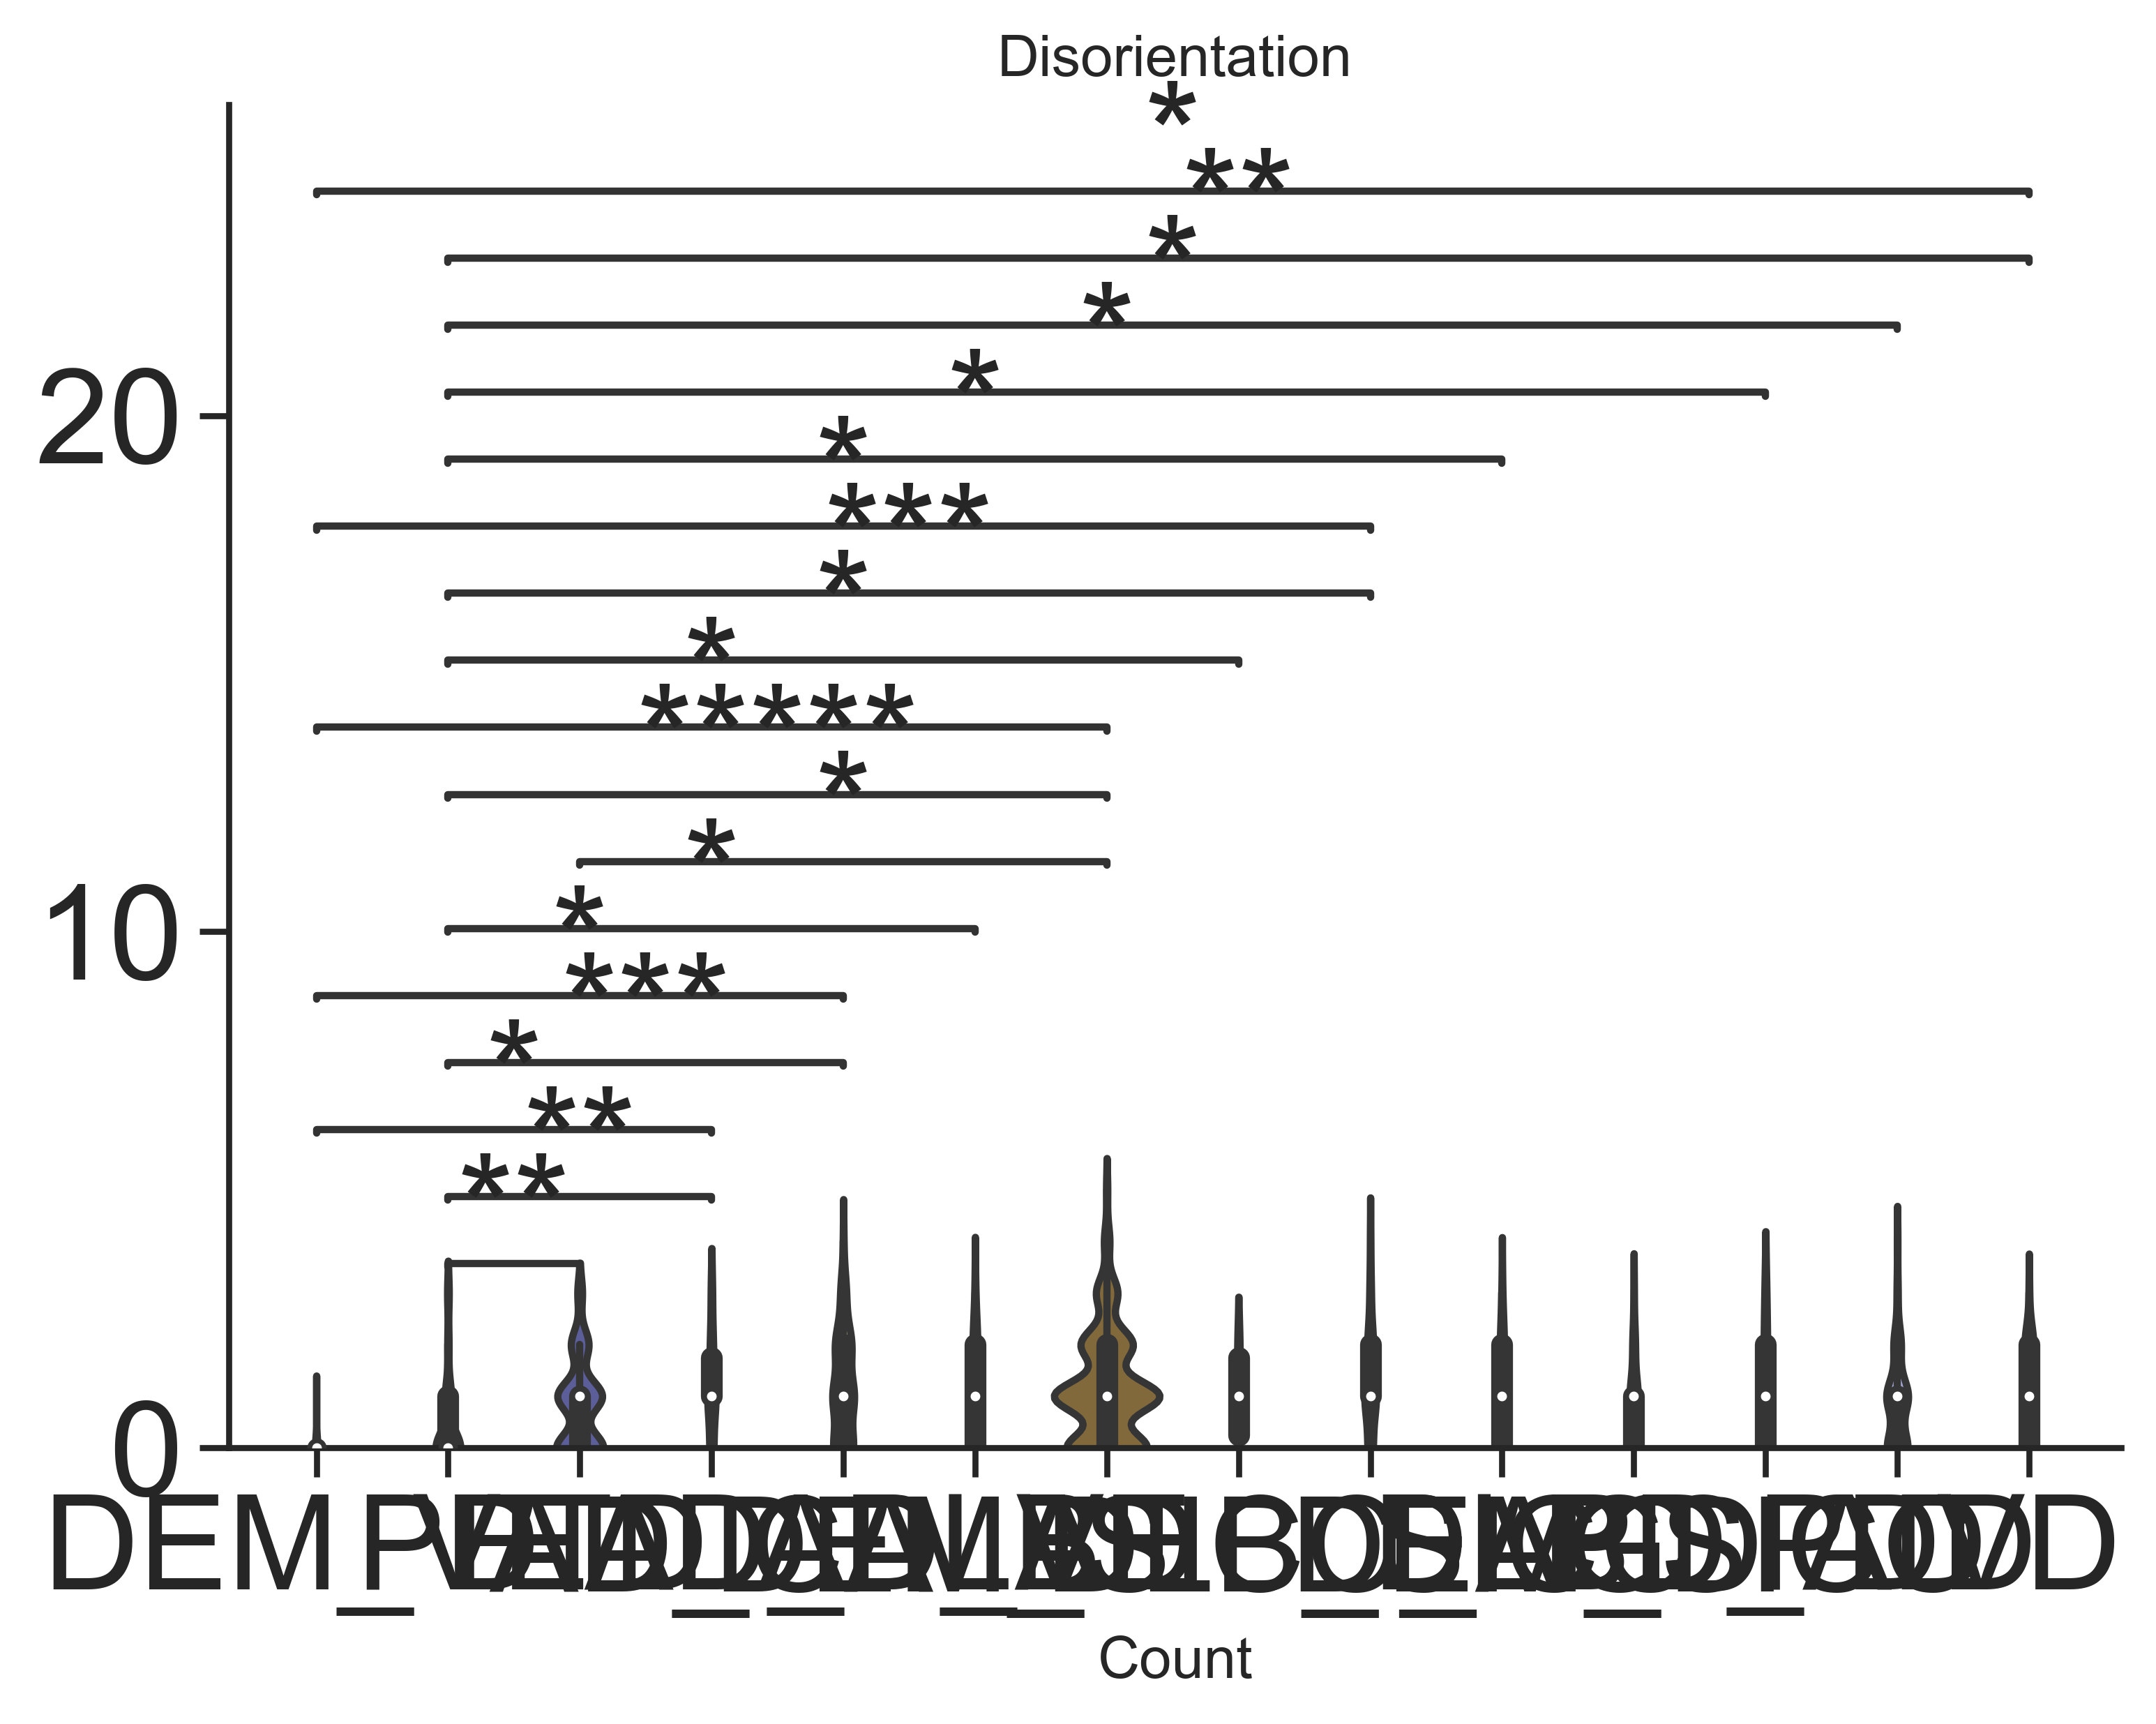

Memory_impairment
After selecting for ['PD' 'FTD' 'DEM_SICC' 'AD' 'AD_DLB' 'AD_CA' 'DLB_SICC' 'DEM_SICC_AGD'
 'VD' 'DEM_VE' 'PDD' 'AD_VE' 'DLB' 'PD_AD'], we have 1633  donors
Before removing zero donors


neuropathological_diagnosis sex  observations_Memory_impairment  donors
0                           AD   F                             561     491
1                           AD   M                             364     217
2                        AD_CA   F                              30      24
3                        AD_CA   M                              29      17
4                       AD_DLB   F                             120      75
5                       AD_DLB   M                              73      45
6                        AD_VE   F                              17      14
7                        AD_VE   M                              13      10
8                     DEM_SICC   F                              23      38
9                     DEM_SICC   M                              28      19
10                DEM_SICC_AGD   F                              14      10
11                DEM_SICC_AGD   M                               8       7
12                      DEM_VE   F                               8      10
13                      DEM_VE   M                               3       5
14                         DLB   F                              15       9
15                         DLB   M                              41      21
16                    DLB_SICC   F                              30      24
17                    DLB_SICC   M                              65      36
18                         FTD   F                             146      97
19                         FTD   M                             186     120
20                          PD   F                              32      51
21                          PD   M                              76      82
22                         PDD   F                              51      45
23                         PDD   M                             136      80
24                       PD_AD   F                              13      11
25                       PD_AD   M                              13      11
26                          VD   F                              30      25
27                          VD   M                              51      39





























After subsampling sexes


neuropathological_diagnosis sex  observations_Memory_impairment  donors
0                           AD   F                             262     217
1                           AD   M                             364     217
2                        AD_CA   F                              24      17
3                        AD_CA   M                              29      17
4                       AD_DLB   F                              61      45
5                       AD_DLB   M                              73      45
6                        AD_VE   F                              15      10
7                        AD_VE   M                              13      10
8                     DEM_SICC   F                              11      19
9                     DEM_SICC   M                              28      19
10                DEM_SICC_AGD   F                               6       7
11                DEM_SICC_AGD   M                               8       7
12                      DEM_VE   F                               1       5
13                      DEM_VE   M                               3       5
14                         DLB   F                              15       9
15                         DLB   M                              14       9
16                    DLB_SICC   F                              30      24
17                    DLB_SICC   M                              44      24
18                         FTD   F                             146      97
19                         FTD   M                             149      97
20                          PD   F                              32      51
21                          PD   M                              55      51
22                         PDD   F                              51      45
23                         PDD   M                              82      45
24                       PD_AD   F                              13      11
25                       PD_AD   M                              13      11
26                          VD   F                              30      25
27                          VD   M                              31      25

844 donors are used in the temporal plot
1164 donors are used in the observations plot
FTD


/tmp/ipykernel_10217/3446875031.py:83: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df.groupby(['DonorID']).sum() ## sums all observations of symptom for donor. note, many donors have 0 (e.g. control)


'194 donors in the counts df'

AD_CA


/tmp/ipykernel_10217/3446875031.py:83: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df.groupby(['DonorID']).sum() ## sums all observations of symptom for donor. note, many donors have 0 (e.g. control)


'34 donors in the counts df'

AD_DLB


/tmp/ipykernel_10217/3446875031.py:83: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df.groupby(['DonorID']).sum() ## sums all observations of symptom for donor. note, many donors have 0 (e.g. control)


'90 donors in the counts df'

AD_VE


/tmp/ipykernel_10217/3446875031.py:83: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df.groupby(['DonorID']).sum() ## sums all observations of symptom for donor. note, many donors have 0 (e.g. control)


'20 donors in the counts df'

AD


/tmp/ipykernel_10217/3446875031.py:83: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df.groupby(['DonorID']).sum() ## sums all observations of symptom for donor. note, many donors have 0 (e.g. control)


'434 donors in the counts df'

DEM_SICC_AGD


/tmp/ipykernel_10217/3446875031.py:83: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df.groupby(['DonorID']).sum() ## sums all observations of symptom for donor. note, many donors have 0 (e.g. control)


'14 donors in the counts df'

DLB_SICC


/tmp/ipykernel_10217/3446875031.py:83: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df.groupby(['DonorID']).sum() ## sums all observations of symptom for donor. note, many donors have 0 (e.g. control)


'48 donors in the counts df'

DLB


/tmp/ipykernel_10217/3446875031.py:83: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df.groupby(['DonorID']).sum() ## sums all observations of symptom for donor. note, many donors have 0 (e.g. control)


'18 donors in the counts df'

DEM_SICC


/tmp/ipykernel_10217/3446875031.py:83: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df.groupby(['DonorID']).sum() ## sums all observations of symptom for donor. note, many donors have 0 (e.g. control)


'38 donors in the counts df'

DEM_VE


/tmp/ipykernel_10217/3446875031.py:83: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df.groupby(['DonorID']).sum() ## sums all observations of symptom for donor. note, many donors have 0 (e.g. control)


'10 donors in the counts df'

PD_AD


/tmp/ipykernel_10217/3446875031.py:83: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df.groupby(['DonorID']).sum() ## sums all observations of symptom for donor. note, many donors have 0 (e.g. control)


'22 donors in the counts df'

PDD


/tmp/ipykernel_10217/3446875031.py:83: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df.groupby(['DonorID']).sum() ## sums all observations of symptom for donor. note, many donors have 0 (e.g. control)


'90 donors in the counts df'

PD


/tmp/ipykernel_10217/3446875031.py:83: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df.groupby(['DonorID']).sum() ## sums all observations of symptom for donor. note, many donors have 0 (e.g. control)


'102 donors in the counts df'

VD


/tmp/ipykernel_10217/3446875031.py:83: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df.groupby(['DonorID']).sum() ## sums all observations of symptom for donor. note, many donors have 0 (e.g. control)


'50 donors in the counts df'

/home/jupyter-n.mekkes@gmail.com-f6d87/.conda/envs/clinical_history/lib/python3.11/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/home/jupyter-n.mekkes@gmail.com-f6d87/.conda/envs/clinical_history/lib/python3.11/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/home/jupyter-n.mekkes@gmail.com-f6d87/.conda/envs/clinical_history/lib/python3.11/site-packages/statannotations/Annotator.py:805: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "


p-value annotation legend:
       *: p <= 1.00e-02
      **: 1.00e-06 < p <= 1.00e-04
     ***: 1.00e-08 < p <= 1.00e-06
    ****: 1.00e-10 < p <= 1.00e-08
   *****: p <= 1.00e-10

PD vs. FTD: Custom statistical test, P_val:1.798e-06
PD vs. AD_DLB: Custom statistical test, P_val:6.723e-05
PD vs. AD: Custom statistical test, P_val:6.723e-05
PD vs. DLB_SICC: Custom statistical test, P_val:3.454e-03
PD vs. PDD: Custom statistical test, P_val:1.887e-03
PD vs. DLB: Custom statistical test, P_val:8.670e-03


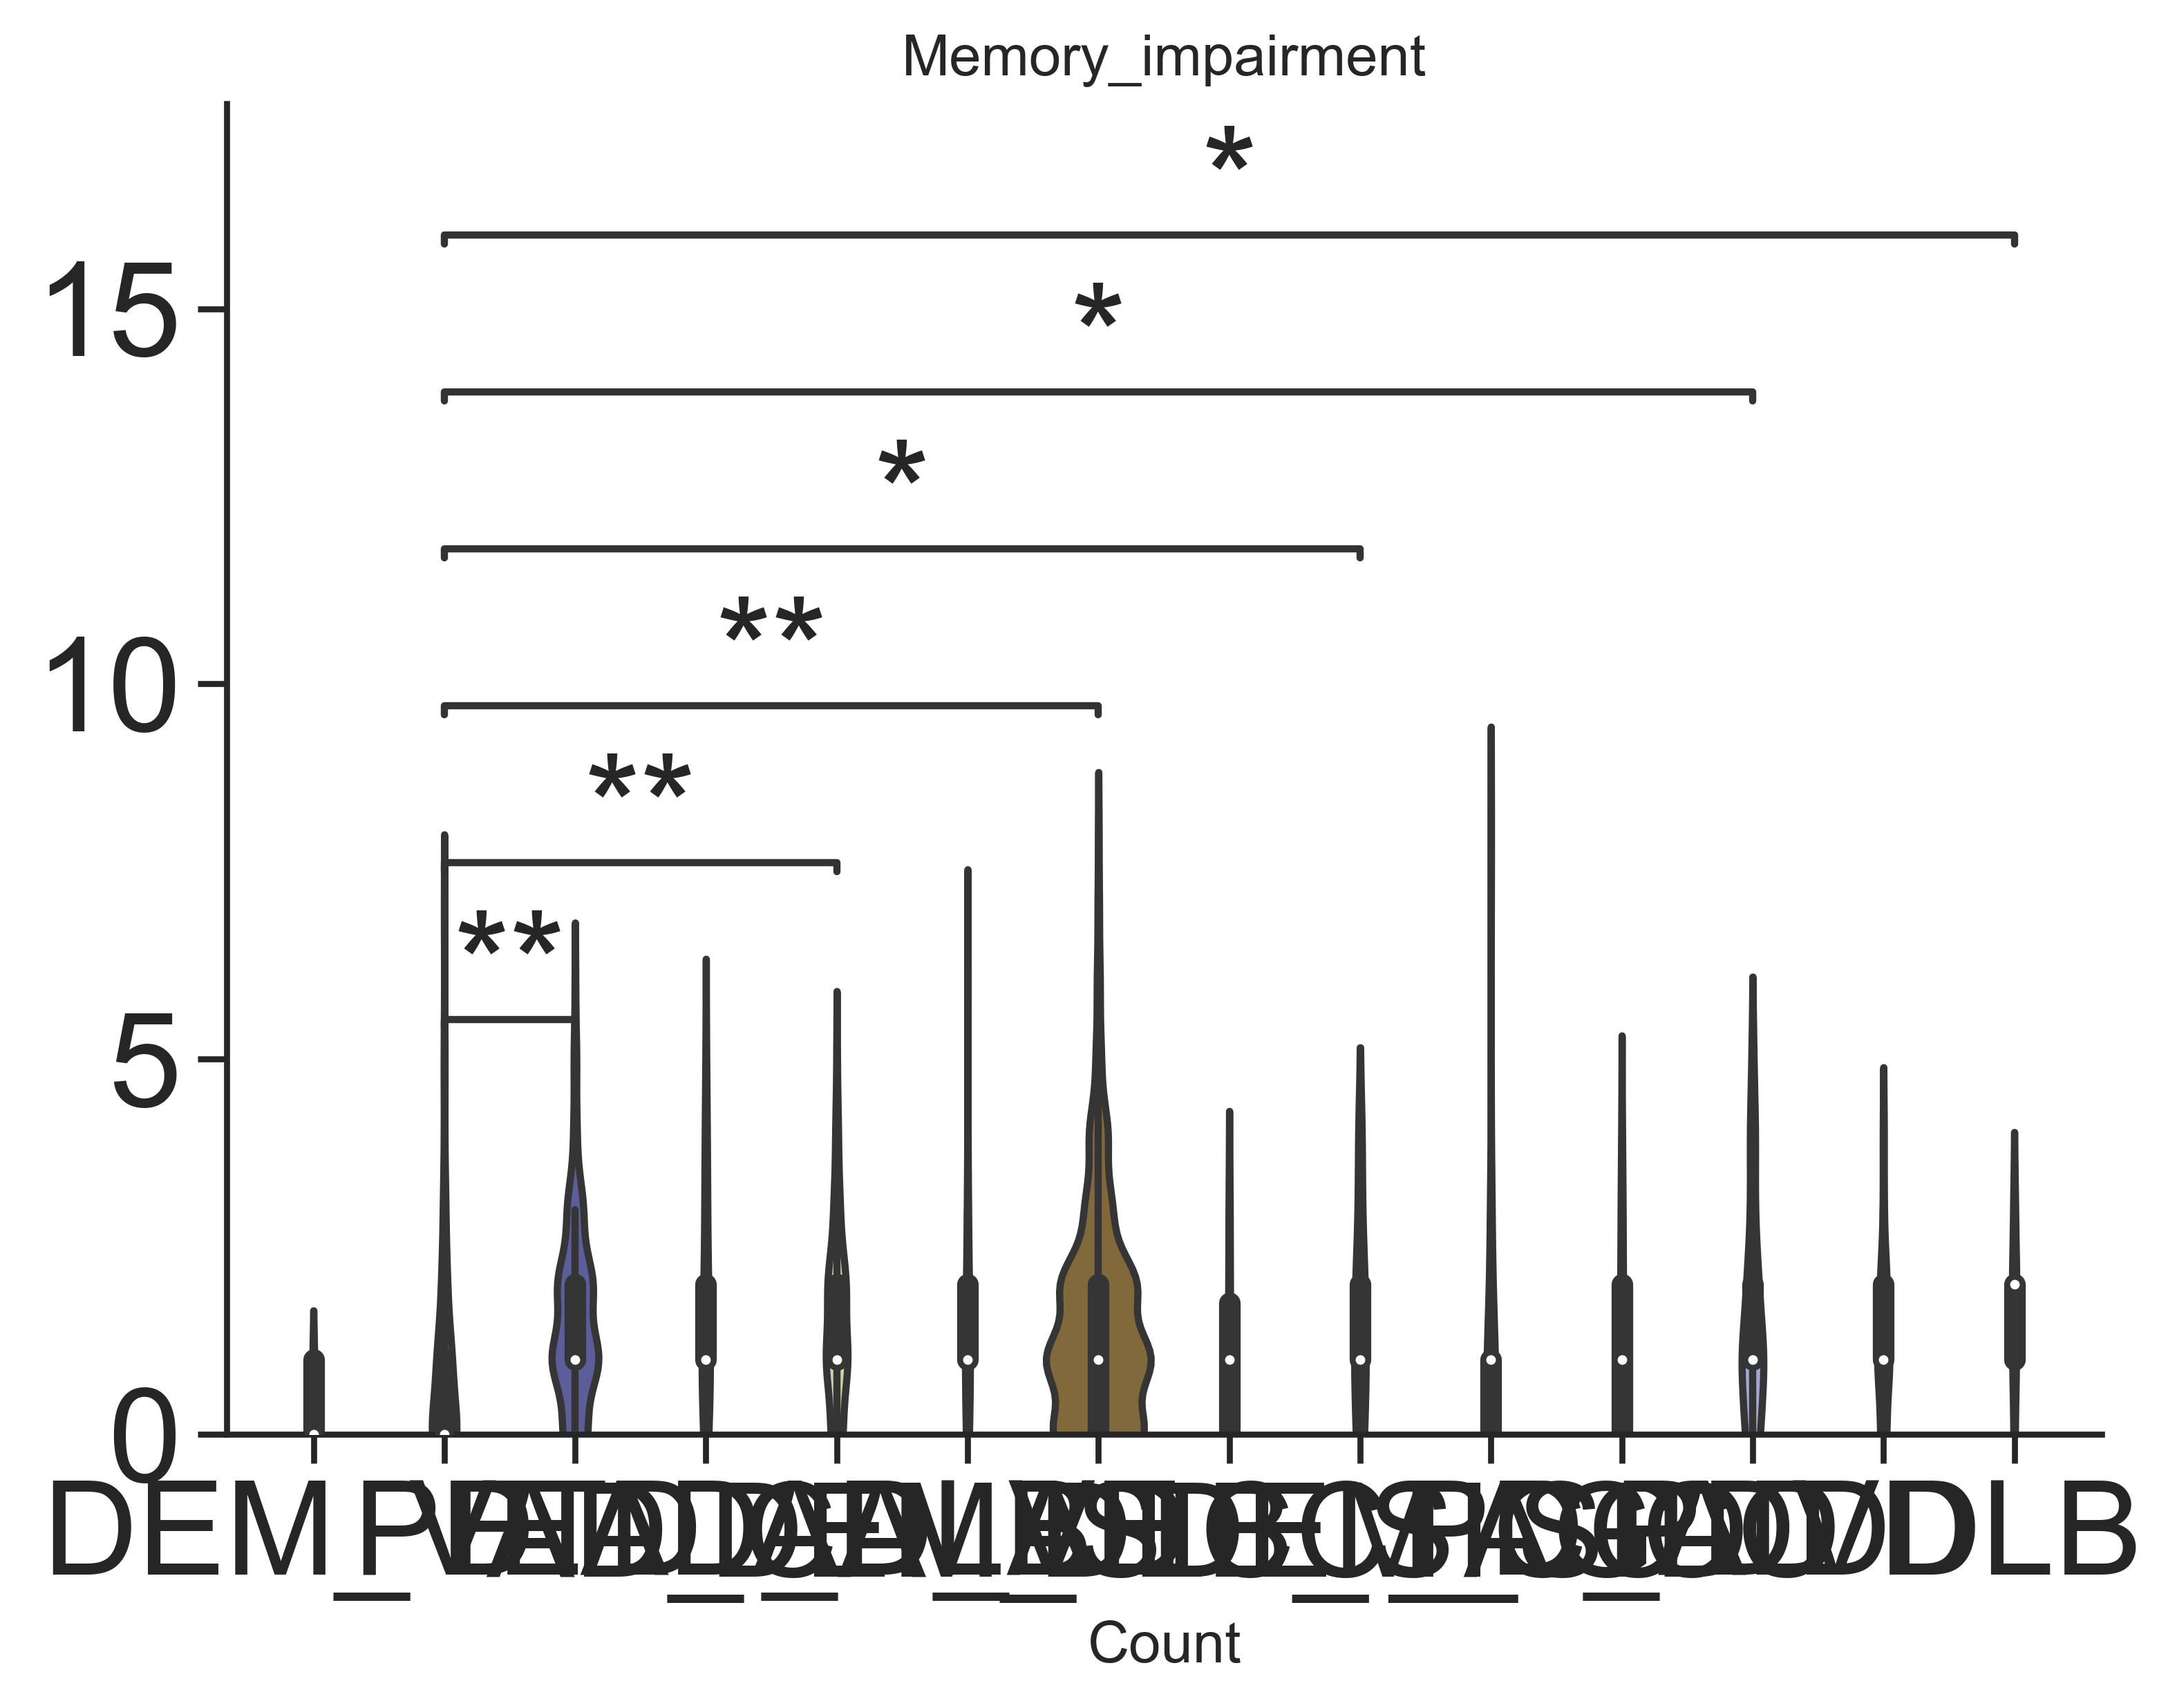

In [114]:
make_labeled_violinplots_horizontal(trait_attribute_dictionary,
                                    selected_donors,
                                    table_diagnosis_colors_dic,
                                    15,
                                   'counts',
                                   'ext_3_rare_dem_counts',
                                    heatmap=False,
                                   printvalues=True,
                                   fixsex=True,
                                   remove_zero_donors = False,
                                   w=7,
                                   h=5                                   )


The plot type is survival
Dementia
After selecting for ['PD' 'FTD' 'DEM_SICC' 'AD' 'AD_DLB' 'AD_CA' 'DLB_SICC' 'DEM_SICC_AGD'
 'VD' 'DEM_VE' 'PDD' 'AD_VE' 'DLB' 'PD_AD'], we have 1633  donors




























894 donors are used in the temporal plot
894 donors are used in the observations plot
FTD
AD_CA
AD_DLB
AD_VE
AD
DEM_SICC_AGD
DLB_SICC
DLB
DEM_SICC
DEM_VE
PD_AD
PDD
PD
VD


FTD  AD_CA  AD_DLB  AD_VE  AD  DEM_SICC_AGD  DLB_SICC  DLB  \
NBB 1992-079  15.0    NaN     NaN    NaN NaN           NaN       NaN  NaN   
NBB 1993-082   0.0    NaN     NaN    NaN NaN           NaN       NaN  NaN   
NBB 1994-020   2.0    NaN     NaN    NaN NaN           NaN       NaN  NaN   
NBB 1994-068   1.0    NaN     NaN    NaN NaN           NaN       NaN  NaN   
NBB 1994-075   6.0    NaN     NaN    NaN NaN           NaN       NaN  NaN   
...            ...    ...     ...    ...  ..           ...       ...  ...   
NBB 2011-011   NaN    NaN     NaN    NaN NaN           NaN       NaN  NaN   
NBB 2012-058   NaN    NaN     NaN    NaN NaN           NaN       NaN  NaN   
NBB 2015-081   NaN    NaN     NaN    NaN NaN           NaN       NaN  NaN   
NBB 2016-095   NaN    NaN     NaN    NaN NaN           NaN       NaN  NaN   
NBB 2018-059   NaN    NaN     NaN    NaN NaN           NaN       NaN  NaN   

              DEM_SICC  DEM_VE  PD_AD  PDD  PD   VD  
NBB 1992-079       NaN     NaN    NaN  NaN NaN  NaN  
NBB 1993-082       NaN     NaN    NaN  NaN NaN  NaN  
NBB 1994-020       NaN     NaN    NaN  NaN NaN  NaN  
NBB 1994-068       NaN     NaN    NaN  NaN NaN  NaN  
NBB 1994-075       NaN     NaN    NaN  NaN NaN  NaN  
...                ...     ...    ...  ...  ..  ...  
NBB 2011-011       NaN     NaN    NaN  NaN NaN  2.0  
NBB 2012-058       NaN     NaN    NaN  NaN NaN  7.0  
NBB 2015-081       NaN     NaN    NaN  NaN NaN  7.0  
NBB 2016-095       NaN     NaN    NaN  NaN NaN  0.0  
NBB 2018-059       NaN     NaN    NaN  NaN NaN  1.0  

[894 rows x 14 columns]

/home/jupyter-n.mekkes@gmail.com-f6d87/.conda/envs/clinical_history/lib/python3.11/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/tmp/ipykernel_10217/2577994954.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hm_df = hm_df.append(mirror, ignore_index=True)


<Figure size 3500x2500 with 0 Axes>

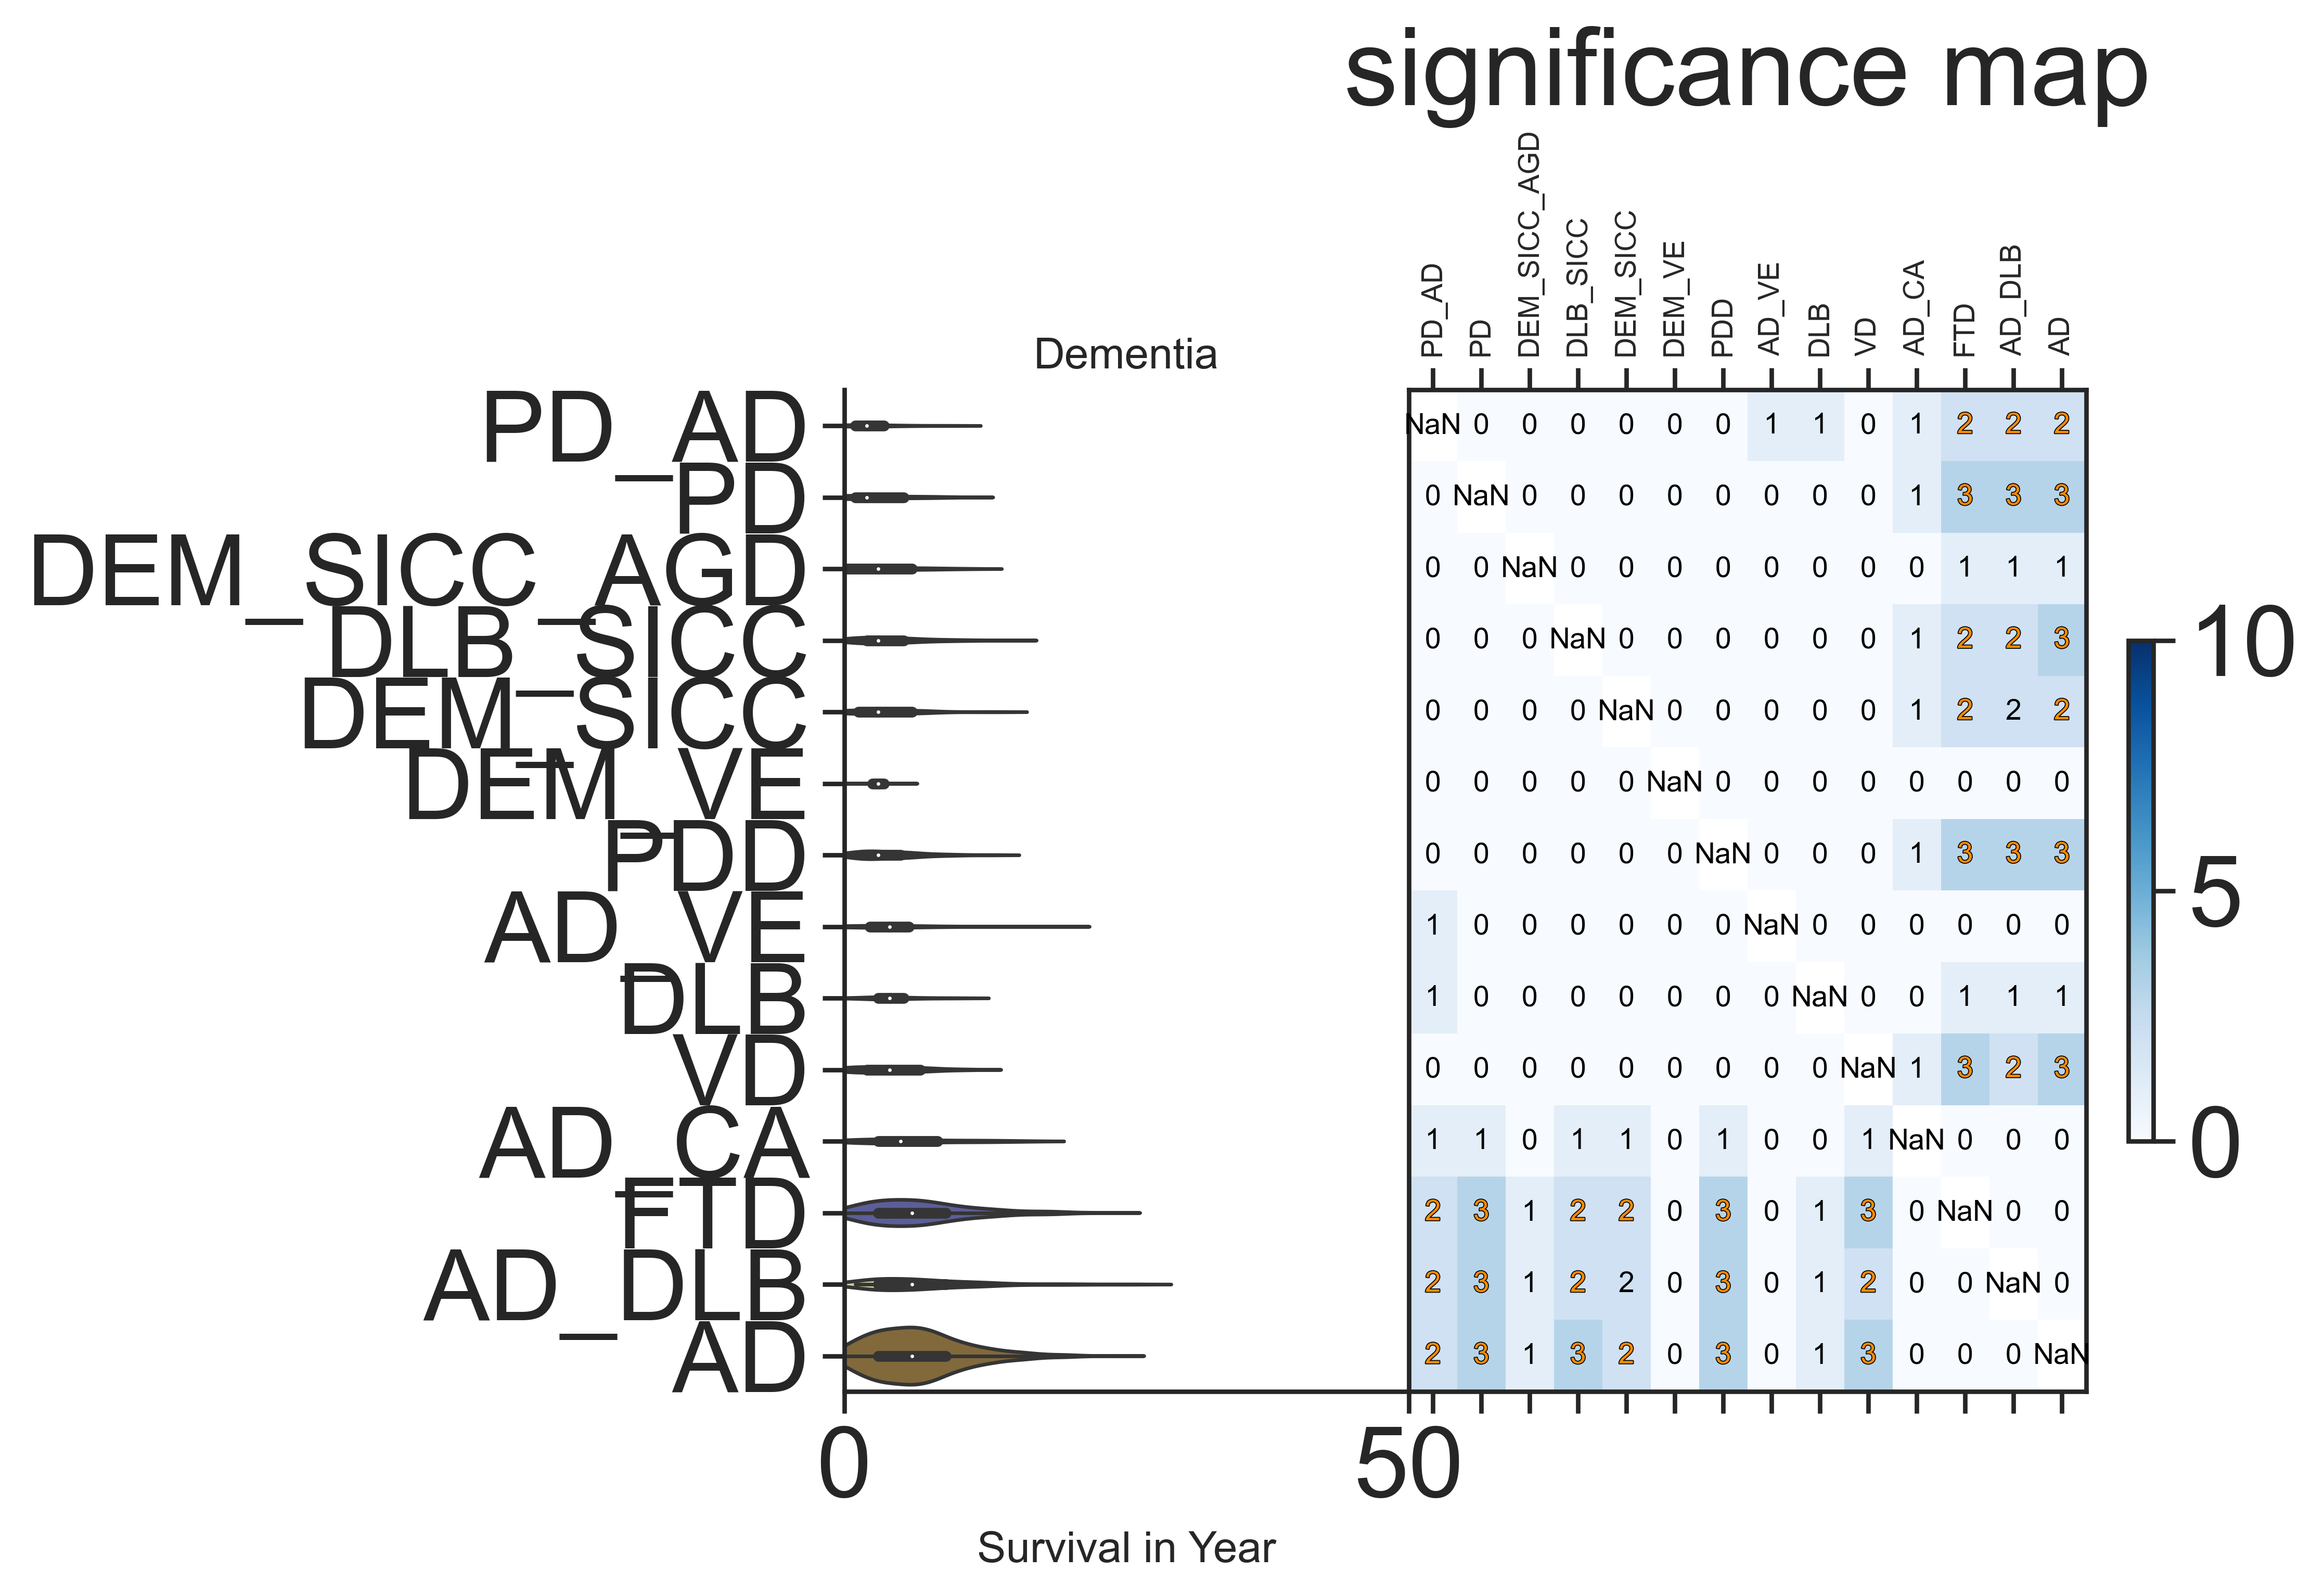

Disorientation
After selecting for ['PD' 'FTD' 'DEM_SICC' 'AD' 'AD_DLB' 'AD_CA' 'DLB_SICC' 'DEM_SICC_AGD'
 'VD' 'DEM_VE' 'PDD' 'AD_VE' 'DLB' 'PD_AD'], we have 1633  donors


















After subsampling, DEM_VE no longer has both male and female donors








722 donors are used in the temporal plot
722 donors are used in the observations plot
FTD
AD_CA
AD_DLB
AD_VE
AD
DEM_SICC_AGD
DLB_SICC
DLB
DEM_SICC
DEM_VE
PD_AD
PDD
PD
VD


FTD  AD_CA  AD_DLB  AD_VE  AD  DEM_SICC_AGD  DLB_SICC  DLB  \
NBB 1992-019   4.0    NaN     NaN    NaN NaN           NaN       NaN  NaN   
NBB 1994-068   1.0    NaN     NaN    NaN NaN           NaN       NaN  NaN   
NBB 1994-075  16.0    NaN     NaN    NaN NaN           NaN       NaN  NaN   
NBB 1994-111   7.0    NaN     NaN    NaN NaN           NaN       NaN  NaN   
NBB 1995-041   4.0    NaN     NaN    NaN NaN           NaN       NaN  NaN   
...            ...    ...     ...    ...  ..           ...       ...  ...   
NBB 2010-098   NaN    NaN     NaN    NaN NaN           NaN       NaN  NaN   
NBB 2011-011   NaN    NaN     NaN    NaN NaN           NaN       NaN  NaN   
NBB 2012-058   NaN    NaN     NaN    NaN NaN           NaN       NaN  NaN   
NBB 2016-095   NaN    NaN     NaN    NaN NaN           NaN       NaN  NaN   
NBB 2018-059   NaN    NaN     NaN    NaN NaN           NaN       NaN  NaN   

              DEM_SICC  DEM_VE  PD_AD  PDD  PD    VD  
NBB 1992-019       NaN     NaN    NaN  NaN NaN   NaN  
NBB 1994-068       NaN     NaN    NaN  NaN NaN   NaN  
NBB 1994-075       NaN     NaN    NaN  NaN NaN   NaN  
NBB 1994-111       NaN     NaN    NaN  NaN NaN   NaN  
NBB 1995-041       NaN     NaN    NaN  NaN NaN   NaN  
...                ...     ...    ...  ...  ..   ...  
NBB 2010-098       NaN     NaN    NaN  NaN NaN  14.0  
NBB 2011-011       NaN     NaN    NaN  NaN NaN   2.0  
NBB 2012-058       NaN     NaN    NaN  NaN NaN   7.0  
NBB 2016-095       NaN     NaN    NaN  NaN NaN   1.0  
NBB 2018-059       NaN     NaN    NaN  NaN NaN   1.0  

[722 rows x 14 columns]

diagnosis DEM_SICC_AGD or diagnosis DEM_VE has no instances of attribute Disorientation
diagnosis DLB_SICC or diagnosis DEM_VE has no instances of attribute Disorientation
diagnosis DEM_SICC or diagnosis DEM_VE has no instances of attribute Disorientation
diagnosis PD_AD or diagnosis DEM_VE has no instances of attribute Disorientation
diagnosis PD or diagnosis DEM_VE has no instances of attribute Disorientation
diagnosis VD or diagnosis DEM_VE has no instances of attribute Disorientation
diagnosis PDD or diagnosis DEM_VE has no instances of attribute Disorientation
diagnosis AD_VE or diagnosis DEM_VE has no instances of attribute Disorientation
diagnosis AD_CA or diagnosis DEM_VE has no instances of attribute Disorientation
diagnosis DLB or diagnosis DEM_VE has no instances of attribute Disorientation
diagnosis FTD or diagnosis DEM_VE has no instances of attribute Disorientation
diagnosis AD_DLB or diagnosis DEM_VE has no instances of attribute Disorientation
diagnosis AD or diagnosis 

/home/jupyter-n.mekkes@gmail.com-f6d87/.conda/envs/clinical_history/lib/python3.11/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/tmp/ipykernel_10217/2577994954.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hm_df = hm_df.append(mirror, ignore_index=True)


<Figure size 3500x2500 with 0 Axes>

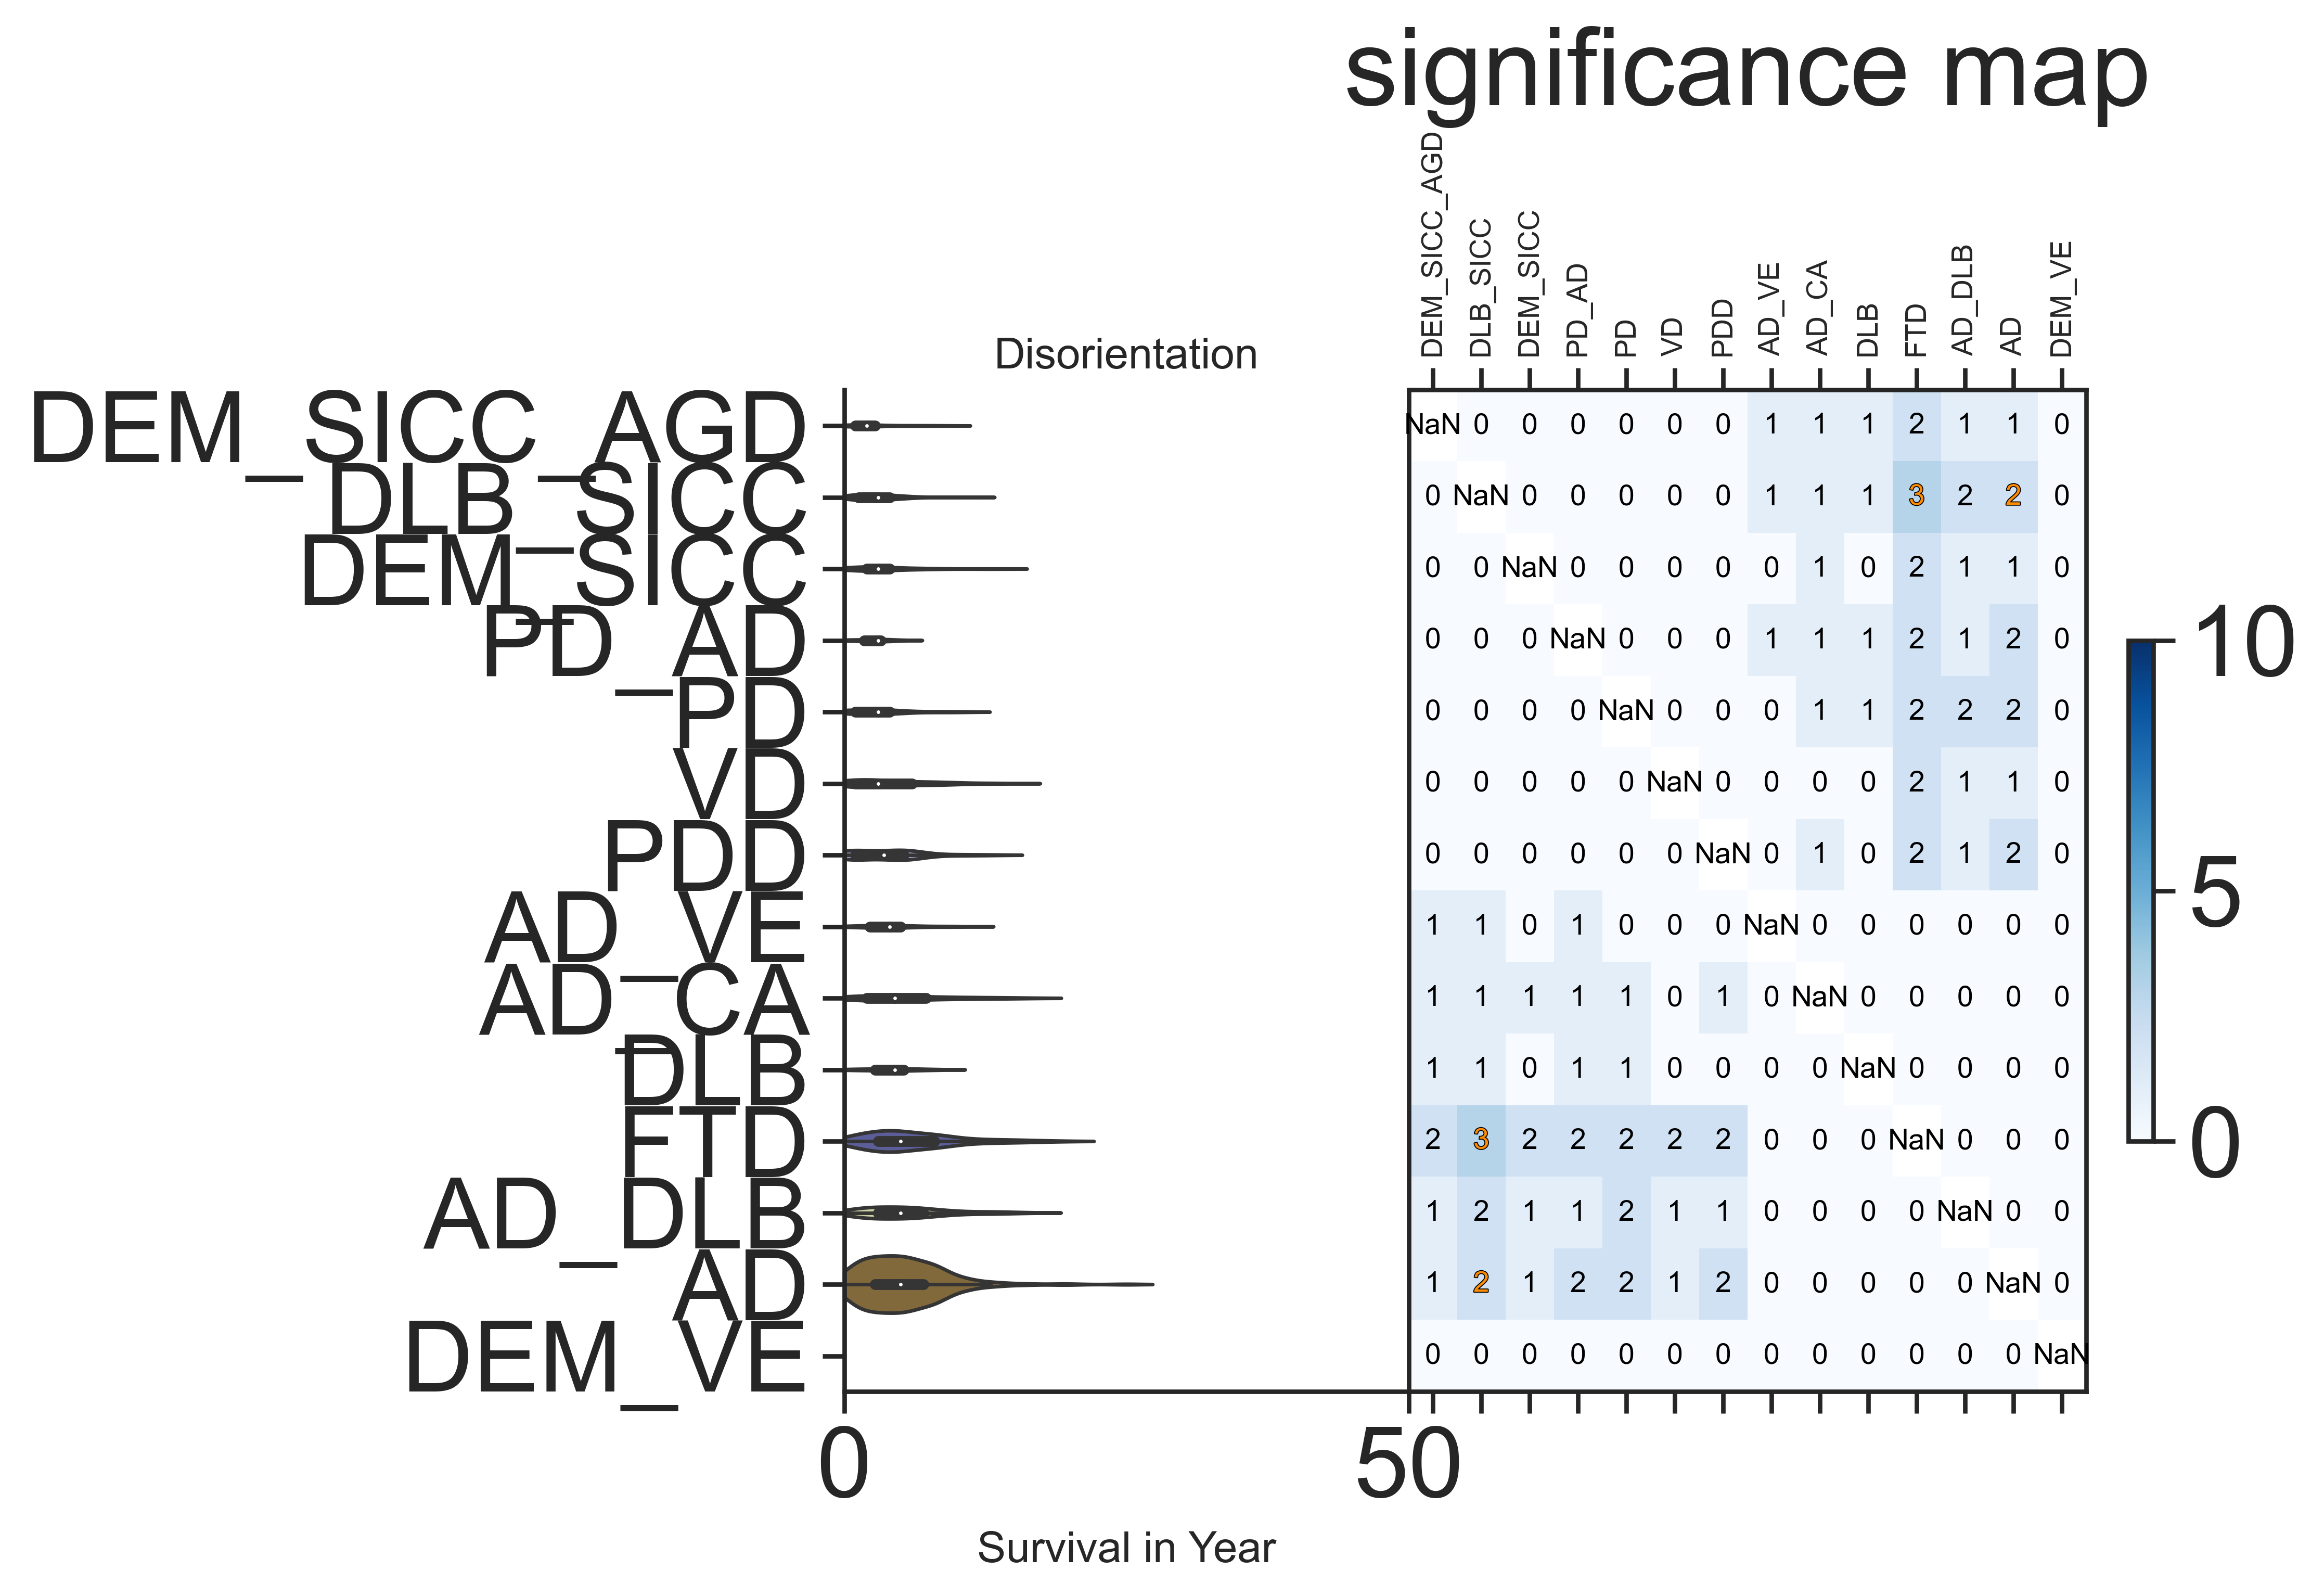

Memory_impairment
After selecting for ['PD' 'FTD' 'DEM_SICC' 'AD' 'AD_DLB' 'AD_CA' 'DLB_SICC' 'DEM_SICC_AGD'
 'VD' 'DEM_VE' 'PDD' 'AD_VE' 'DLB' 'PD_AD'], we have 1633  donors




























860 donors are used in the temporal plot
860 donors are used in the observations plot
FTD
AD_CA
AD_DLB
AD_VE
AD
DEM_SICC_AGD
DLB_SICC
DLB
DEM_SICC
DEM_VE
PD_AD
PDD
PD
VD


FTD  AD_CA  AD_DLB  AD_VE  AD  DEM_SICC_AGD  DLB_SICC  DLB  \
NBB 1992-019   4.0    NaN     NaN    NaN NaN           NaN       NaN  NaN   
NBB 1994-033   5.0    NaN     NaN    NaN NaN           NaN       NaN  NaN   
NBB 1994-075  16.0    NaN     NaN    NaN NaN           NaN       NaN  NaN   
NBB 1994-111   7.0    NaN     NaN    NaN NaN           NaN       NaN  NaN   
NBB 1996-099   7.0    NaN     NaN    NaN NaN           NaN       NaN  NaN   
...            ...    ...     ...    ...  ..           ...       ...  ...   
NBB 2010-098   NaN    NaN     NaN    NaN NaN           NaN       NaN  NaN   
NBB 2011-011   NaN    NaN     NaN    NaN NaN           NaN       NaN  NaN   
NBB 2012-058   NaN    NaN     NaN    NaN NaN           NaN       NaN  NaN   
NBB 2016-095   NaN    NaN     NaN    NaN NaN           NaN       NaN  NaN   
NBB 2018-059   NaN    NaN     NaN    NaN NaN           NaN       NaN  NaN   

              DEM_SICC  DEM_VE  PD_AD  PDD  PD    VD  
NBB 1992-019       NaN     NaN    NaN  NaN NaN   NaN  
NBB 1994-033       NaN     NaN    NaN  NaN NaN   NaN  
NBB 1994-075       NaN     NaN    NaN  NaN NaN   NaN  
NBB 1994-111       NaN     NaN    NaN  NaN NaN   NaN  
NBB 1996-099       NaN     NaN    NaN  NaN NaN   NaN  
...                ...     ...    ...  ...  ..   ...  
NBB 2010-098       NaN     NaN    NaN  NaN NaN  20.0  
NBB 2011-011       NaN     NaN    NaN  NaN NaN   4.0  
NBB 2012-058       NaN     NaN    NaN  NaN NaN   7.0  
NBB 2016-095       NaN     NaN    NaN  NaN NaN   1.0  
NBB 2018-059       NaN     NaN    NaN  NaN NaN  12.0  

[860 rows x 14 columns]

/home/jupyter-n.mekkes@gmail.com-f6d87/.conda/envs/clinical_history/lib/python3.11/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/tmp/ipykernel_10217/2577994954.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hm_df = hm_df.append(mirror, ignore_index=True)


<Figure size 3500x2500 with 0 Axes>

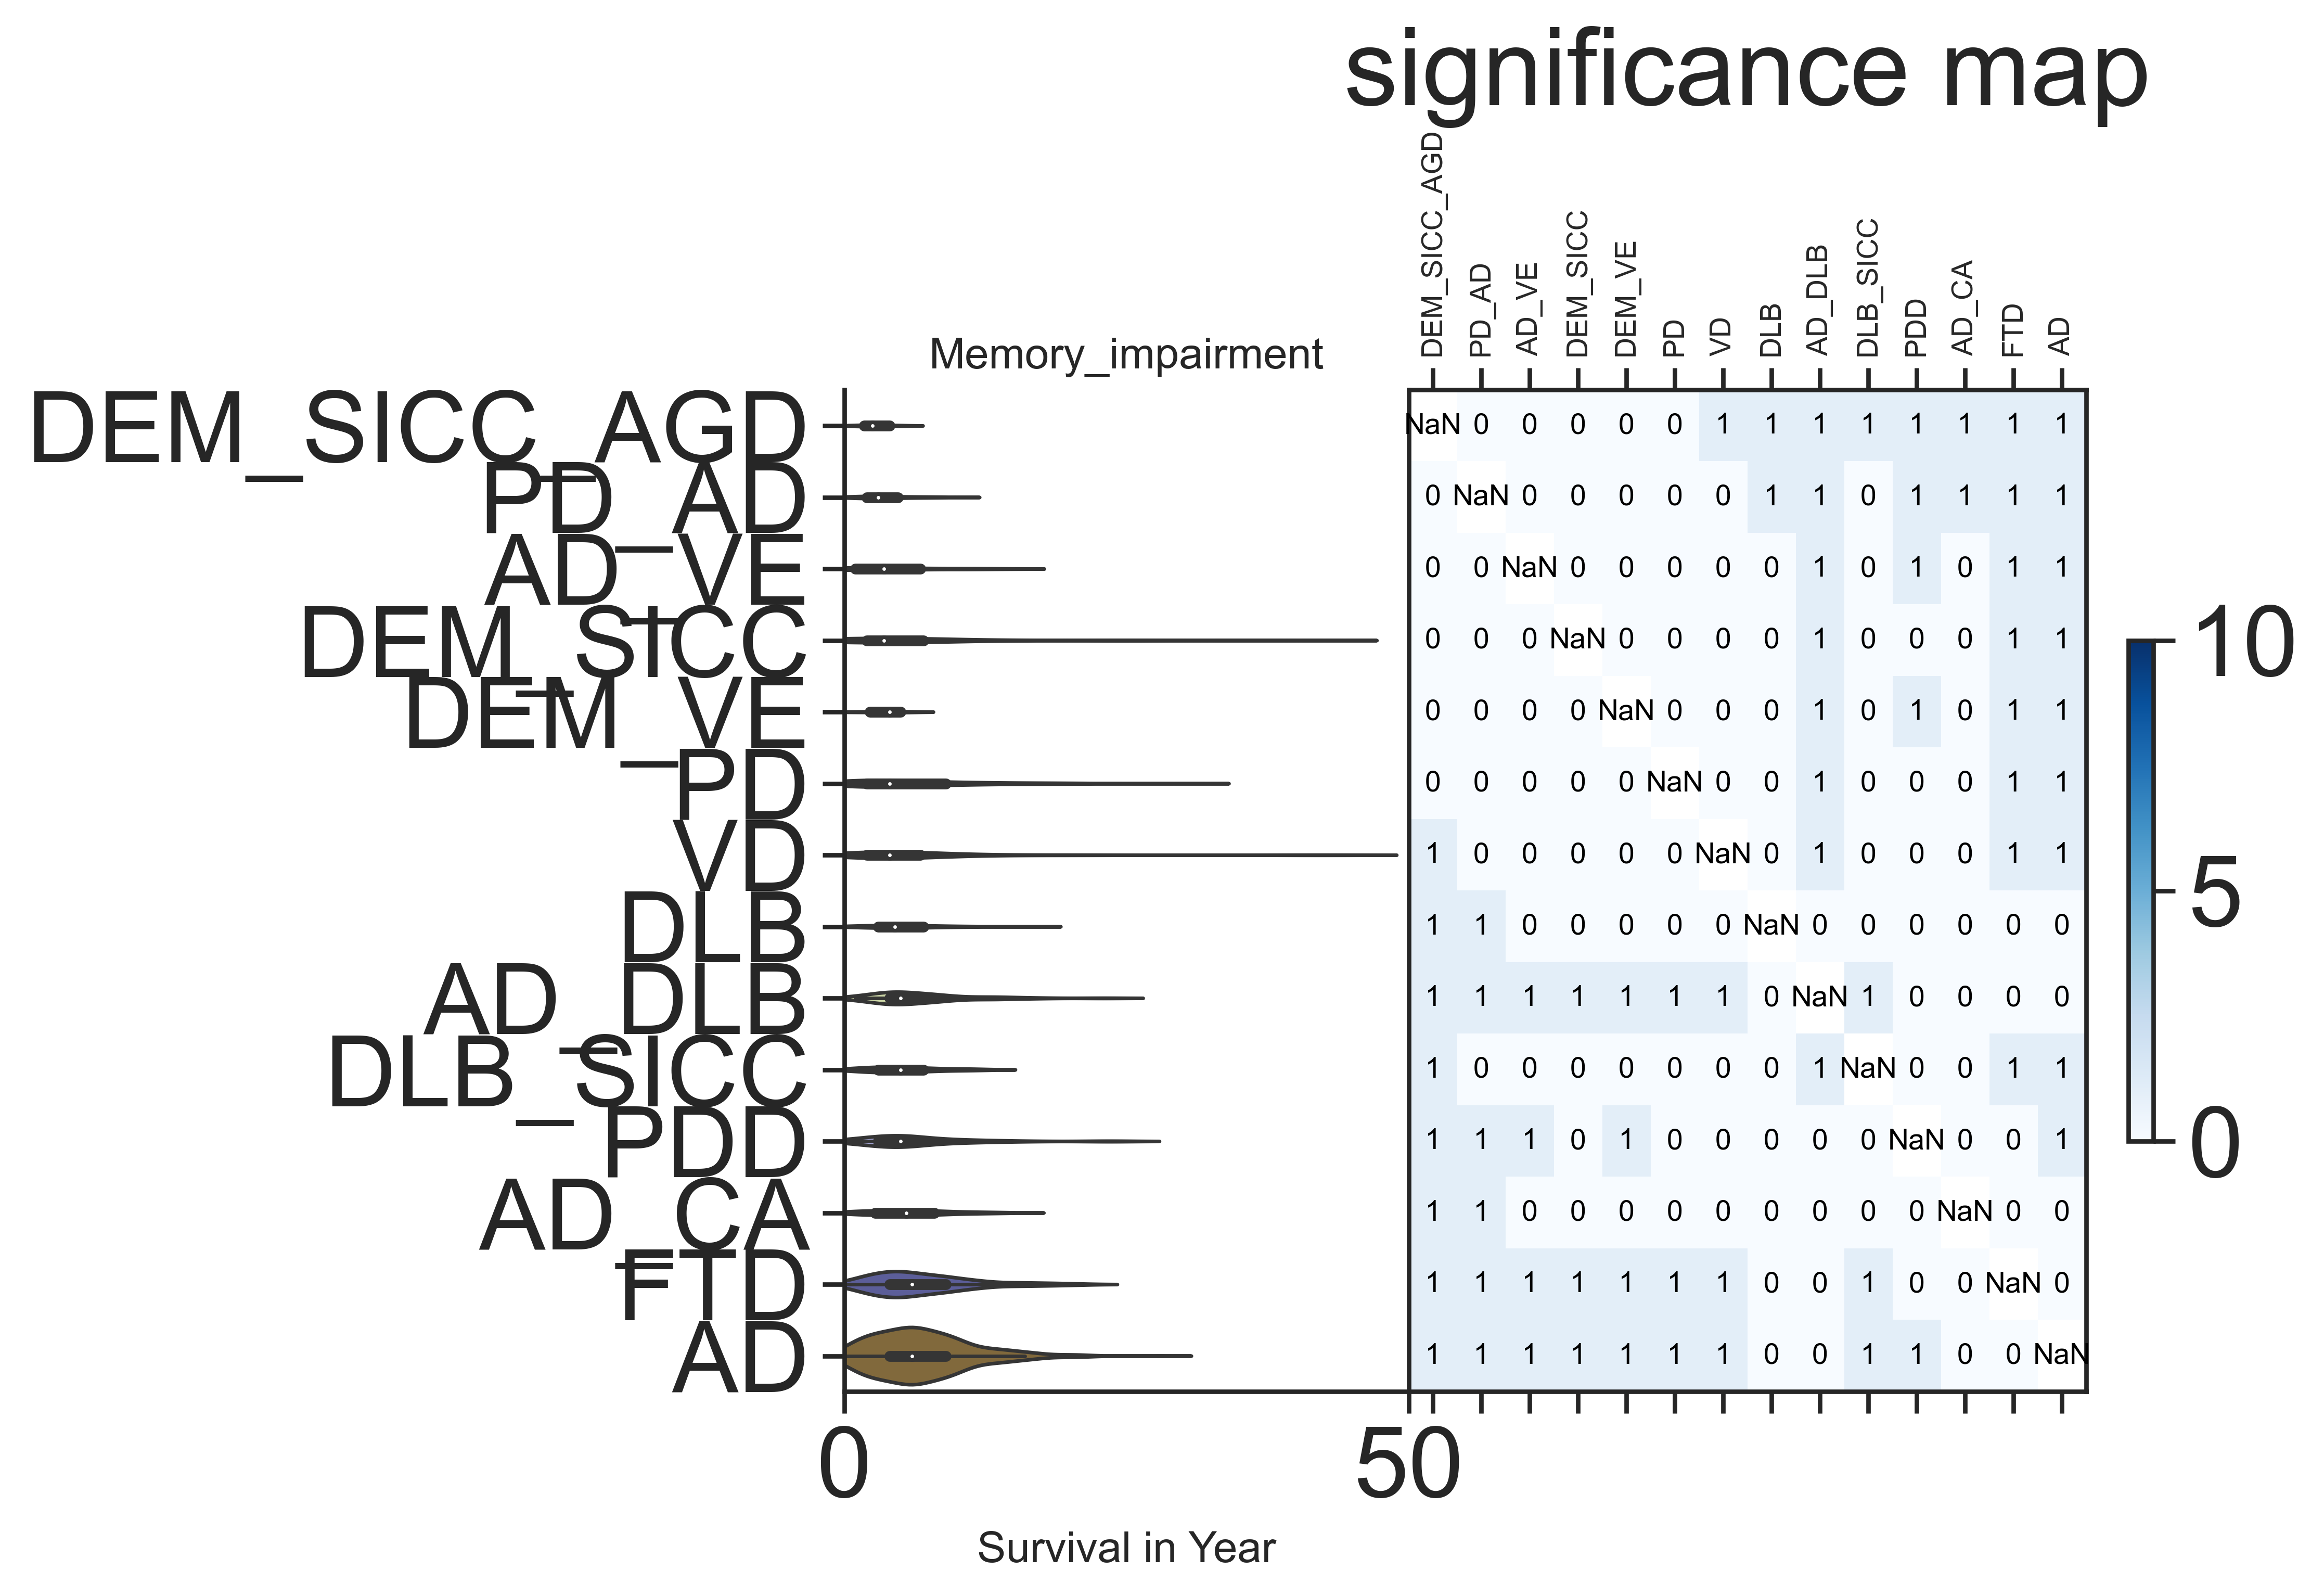

In [115]:
make_labeled_violinplots_horizontal(trait_attribute_dictionary,
                                    selected_donors,
                                    table_diagnosis_colors_dic,
                                    50,
                                   'survival',
                                   'ext_3_rare_dem_survival',
                                    heatmap=True,
#                                    printvalues=True,
                                   fixsex=True,
                                   remove_zero_donors = True,
                                   w=7,
                                   h=5                                   )

The plot type is temporal
Dementia
After selecting for ['PID' 'PSP' 'FTD-TAU' 'FTD_MND' 'FTD-TDP-C' 'FTD-TDP-B' 'FTD-TDP' 'CBD'
 'FTD-TDP-A'], we have 321  donors
Before removing zero donors


neuropathological_diagnosis sex  observations_Dementia  donors
0                          CBD   F                     11       6
1                          CBD   M                      4       9
2                      FTD-TAU   F                     30      20
3                      FTD-TAU   M                     36      23
4                      FTD-TDP   F                     58      27
5                      FTD-TDP   M                     52      30
6                    FTD-TDP-A   F                     21      10
7                    FTD-TDP-A   M                     15      10
8                    FTD-TDP-B   F                     26      16
9                    FTD-TDP-B   M                     33      15
10                   FTD-TDP-C   F                     10       5
11                   FTD-TDP-C   M                     15       7
12                     FTD_MND   F                      2       3
13                     FTD_MND   M                     14       9
14                         PID   F                     20      14
15                         PID   M                     44      26
16                         PSP   F                     32      41
17                         PSP   M                     36      50

After removing zero donors


neuropathological_diagnosis sex  observations_Dementia  donors
0                          CBD   F                     11       6
1                          CBD   M                      4       3
2                      FTD-TAU   F                     30      18
3                      FTD-TAU   M                     36      17
4                      FTD-TDP   F                     58      26
5                      FTD-TDP   M                     52      28
6                    FTD-TDP-A   F                     21       9
7                    FTD-TDP-A   M                     15      10
8                    FTD-TDP-B   F                     26      13
9                    FTD-TDP-B   M                     33      14
10                   FTD-TDP-C   F                     10       5
11                   FTD-TDP-C   M                     15       7
12                     FTD_MND   F                      2       2
13                     FTD_MND   M                     14       7
14                         PID   F                     20      12
15                         PID   M                     44      22
16                         PSP   F                     32      21
17                         PSP   M                     36      22



















After subsampling sexes


neuropathological_diagnosis sex  observations_Dementia  donors
0                          CBD   F                      6       3
1                          CBD   M                      4       3
2                      FTD-TAU   F                     29      17
3                      FTD-TAU   M                     36      17
4                      FTD-TDP   F                     58      26
5                      FTD-TDP   M                     48      26
6                    FTD-TDP-A   F                     21       9
7                    FTD-TDP-A   M                     13       9
8                    FTD-TDP-B   F                     26      13
9                    FTD-TDP-B   M                     30      13
10                   FTD-TDP-C   F                     10       5
11                   FTD-TDP-C   M                     12       5
12                     FTD_MND   F                      2       2
13                     FTD_MND   M                      2       2
14                         PID   F                     20      12
15                         PID   M                     23      12
16                         PSP   F                     32      21
17                         PSP   M                     35      21

216 donors are used in the temporal plot
216 donors are used in the observations plot
CBD
FTD-TAU
FTD-TDP-A
FTD-TDP-B
FTD-TDP-C
FTD_MND
FTD-TDP
PID
PSP


/home/jupyter-n.mekkes@gmail.com-f6d87/.conda/envs/clinical_history/lib/python3.11/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/home/jupyter-n.mekkes@gmail.com-f6d87/.conda/envs/clinical_history/lib/python3.11/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/home/jupyter-n.mekkes@gmail.com-f6d87/.conda/envs/clinical_history/lib/python3.11/site-packages/statannotations/Annotator.py:805: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "


p-value annotation legend:
       *: p <= 1.00e-02
      **: 1.00e-06 < p <= 1.00e-04
     ***: 1.00e-08 < p <= 1.00e-06
    ****: 1.00e-10 < p <= 1.00e-08
   *****: p <= 1.00e-10

FTD-TAU vs. PID: Custom statistical test, P_val:4.905e-03
FTD-TDP vs. PSP: Custom statistical test, P_val:1.165e-05
FTD-TAU vs. FTD-TDP-B: Custom statistical test, P_val:2.830e-03
FTD-TDP-C vs. PSP: Custom statistical test, P_val:5.886e-05
FTD-TAU vs. FTD-TDP-A: Custom statistical test, P_val:1.674e-03
FTD-TDP-A vs. PSP: Custom statistical test, P_val:5.886e-05
FTD-TAU vs. FTD-TDP-C: Custom statistical test, P_val:1.656e-03
FTD-TDP-B vs. PSP: Custom statistical test, P_val:1.978e-05
FTD-TAU vs. FTD-TDP: Custom statistical test, P_val:6.637e-05
PID vs. PSP: Custom statistical test, P_val:6.637e-05
CBD vs. PSP: Custom statistical test, P_val:4.735e-03
FTD-TAU vs. PSP: Custom statistical test, P_val:9.607e-14


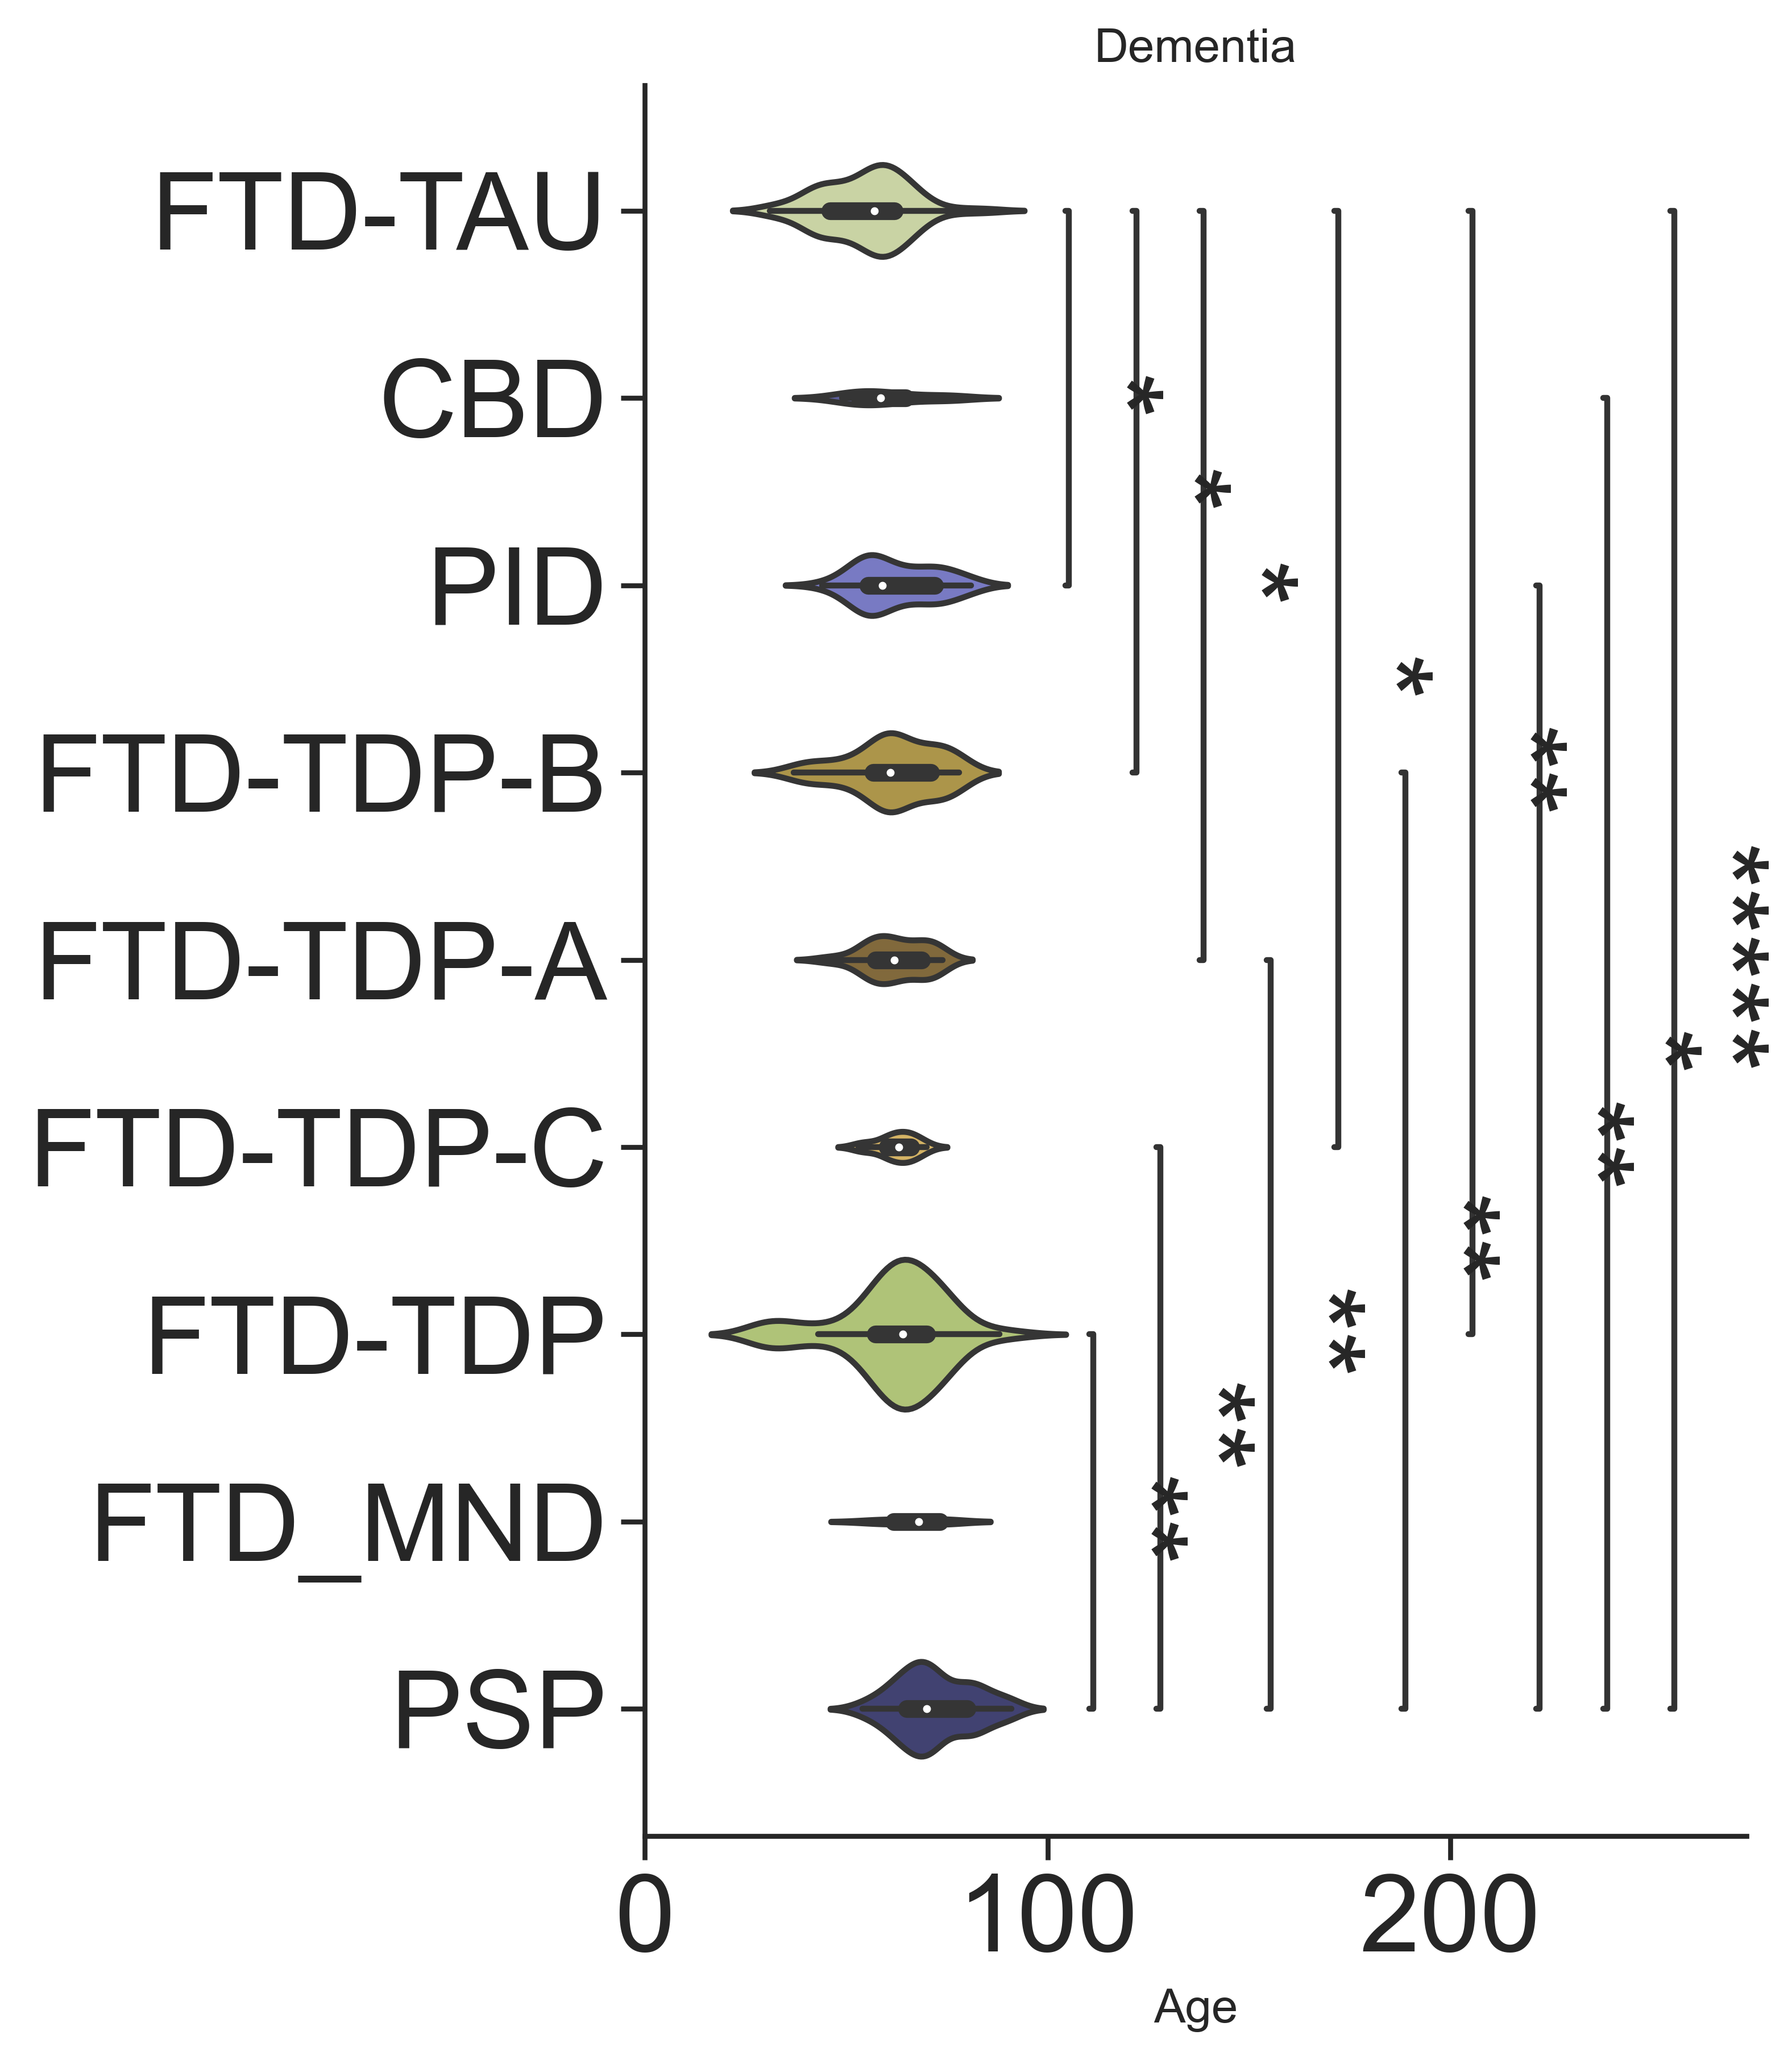

Memory_impairment
After selecting for ['PID' 'PSP' 'FTD-TAU' 'FTD_MND' 'FTD-TDP-C' 'FTD-TDP-B' 'FTD-TDP' 'CBD'
 'FTD-TDP-A'], we have 321  donors
Before removing zero donors


neuropathological_diagnosis sex  observations_Memory_impairment  donors
0                          CBD   F                              13       6
1                          CBD   M                               7       9
2                      FTD-TAU   F                              30      20
3                      FTD-TAU   M                              35      23
4                      FTD-TDP   F                              46      27
5                      FTD-TDP   M                              52      30
6                    FTD-TDP-A   F                              19      10
7                    FTD-TDP-A   M                              11      10
8                    FTD-TDP-B   F                              21      16
9                    FTD-TDP-B   M                              33      15
10                   FTD-TDP-C   F                               8       5
11                   FTD-TDP-C   M                              15       7
12                     FTD_MND   F                               2       3
13                     FTD_MND   M                               7       9
14                         PID   F                              12      14
15                         PID   M                              33      26
16                         PSP   F                              56      41
17                         PSP   M                              59      50

After removing zero donors


neuropathological_diagnosis sex  observations_Memory_impairment  donors
0                          CBD   F                              13       6
1                          CBD   M                               7       5
2                      FTD-TAU   F                              30      18
3                      FTD-TAU   M                              35      20
4                      FTD-TDP   F                              46      20
5                      FTD-TDP   M                              52      26
6                    FTD-TDP-A   F                              19       8
7                    FTD-TDP-A   M                              11       8
8                    FTD-TDP-B   F                              21      13
9                    FTD-TDP-B   M                              33      14
10                   FTD-TDP-C   F                               8       5
11                   FTD-TDP-C   M                              15       6
12                     FTD_MND   F                               2       2
13                     FTD_MND   M                               7       6
14                         PID   F                              12       8
15                         PID   M                              33      19
16                         PSP   F                              56      30
17                         PSP   M                              59      28



















After subsampling sexes


neuropathological_diagnosis sex  observations_Memory_impairment  donors
0                          CBD   F                              12       5
1                          CBD   M                               7       5
2                      FTD-TAU   F                              30      18
3                      FTD-TAU   M                              31      18
4                      FTD-TDP   F                              46      20
5                      FTD-TDP   M                              38      20
6                    FTD-TDP-A   F                              19       8
7                    FTD-TDP-A   M                              11       8
8                    FTD-TDP-B   F                              21      13
9                    FTD-TDP-B   M                              31      13
10                   FTD-TDP-C   F                               8       5
11                   FTD-TDP-C   M                              11       5
12                     FTD_MND   F                               2       2
13                     FTD_MND   M                               2       2
14                         PID   F                              12       8
15                         PID   M                              14       8
16                         PSP   F                              53      28
17                         PSP   M                              59      28

214 donors are used in the temporal plot
214 donors are used in the observations plot
CBD
FTD-TAU
FTD-TDP-A
FTD-TDP-B
FTD-TDP-C
FTD_MND
FTD-TDP
PID
PSP


/home/jupyter-n.mekkes@gmail.com-f6d87/.conda/envs/clinical_history/lib/python3.11/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/home/jupyter-n.mekkes@gmail.com-f6d87/.conda/envs/clinical_history/lib/python3.11/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/home/jupyter-n.mekkes@gmail.com-f6d87/.conda/envs/clinical_history/lib/python3.11/site-packages/statannotations/Annotator.py:805: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "


p-value annotation legend:
       *: p <= 1.00e-02
      **: 1.00e-06 < p <= 1.00e-04
     ***: 1.00e-08 < p <= 1.00e-06
    ****: 1.00e-10 < p <= 1.00e-08
   *****: p <= 1.00e-10

FTD-TDP vs. PSP: Custom statistical test, P_val:4.853e-03
FTD-TAU vs. FTD-TDP-A: Custom statistical test, P_val:1.124e-03
FTD-TDP-A vs. PSP: Custom statistical test, P_val:2.756e-03
FTD-TAU vs. PID: Custom statistical test, P_val:5.932e-03
FTD-TDP-C vs. FTD-TDP: Custom statistical test, P_val:5.247e-03
FTD-TDP-B vs. PSP: Custom statistical test, P_val:1.344e-06
FTD-TAU vs. FTD-TDP: Custom statistical test, P_val:5.620e-07
FTD-TDP-C vs. PSP: Custom statistical test, P_val:7.577e-06
FTD-TAU vs. PSP: Custom statistical test, P_val:7.253e-13


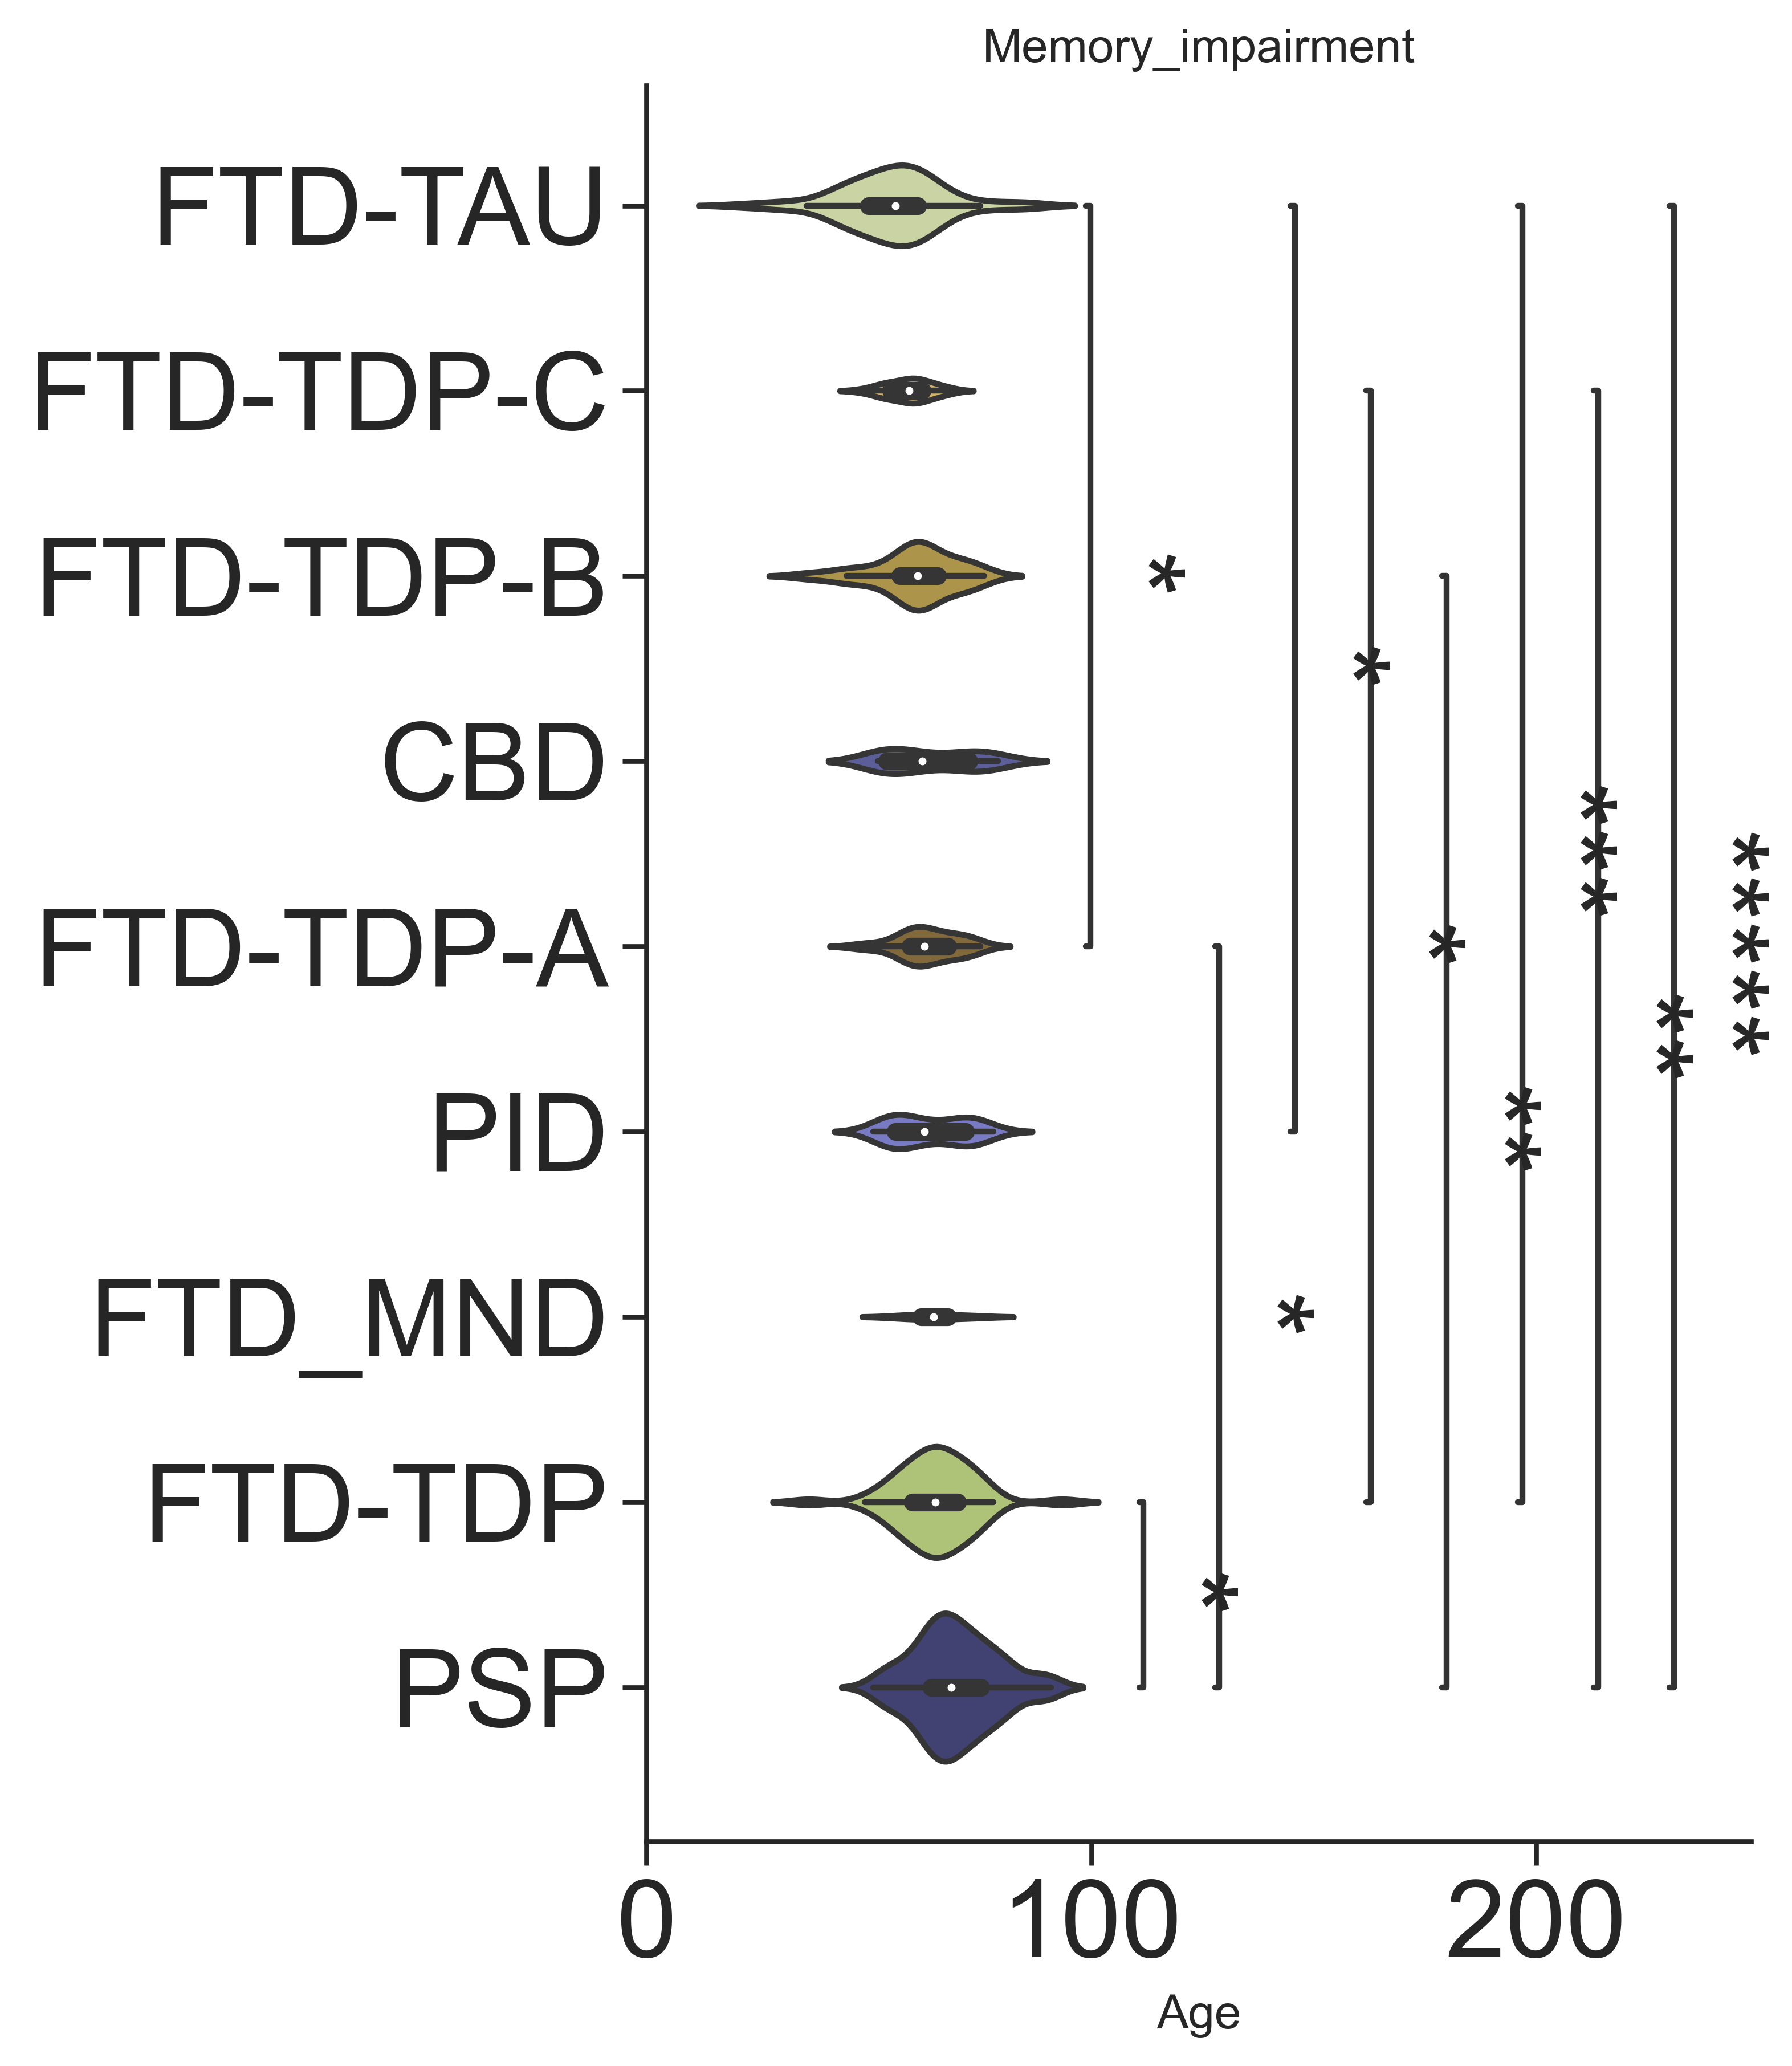

Compulsive_behavior
After selecting for ['PID' 'PSP' 'FTD-TAU' 'FTD_MND' 'FTD-TDP-C' 'FTD-TDP-B' 'FTD-TDP' 'CBD'
 'FTD-TDP-A'], we have 321  donors
Before removing zero donors


neuropathological_diagnosis sex  observations_Compulsive_behavior  donors
0                          CBD   F                                 3       6
1                          CBD   M                                 4       9
2                      FTD-TAU   F                                21      20
3                      FTD-TAU   M                                26      23
4                      FTD-TDP   F                                50      27
5                      FTD-TDP   M                                33      30
6                    FTD-TDP-A   F                                 7      10
7                    FTD-TDP-A   M                                 4      10
8                    FTD-TDP-B   F                                22      16
9                    FTD-TDP-B   M                                34      15
10                   FTD-TDP-C   F                                11       5
11                   FTD-TDP-C   M                                14       7
12                     FTD_MND   F                                 4       3
13                     FTD_MND   M                                 5       9
14                         PID   F                                12      14
15                         PID   M                                38      26
16                         PSP   F                                18      41
17                         PSP   M                                31      50

After removing zero donors


neuropathological_diagnosis sex  observations_Compulsive_behavior  donors
0                          CBD   F                                 3       2
1                          CBD   M                                 4       3
2                      FTD-TAU   F                                21      10
3                      FTD-TAU   M                                26      14
4                      FTD-TDP   F                                50      15
5                      FTD-TDP   M                                33      16
6                    FTD-TDP-A   F                                 7       4
7                    FTD-TDP-A   M                                 4       4
8                    FTD-TDP-B   F                                22      10
9                    FTD-TDP-B   M                                34      14
10                   FTD-TDP-C   F                                11       5
11                   FTD-TDP-C   M                                14       5
12                     FTD_MND   F                                 4       3
13                     FTD_MND   M                                 5       4
14                         PID   F                                12       5
15                         PID   M                                38      19
16                         PSP   F                                18      14
17                         PSP   M                                31      21



















After subsampling sexes


neuropathological_diagnosis sex  observations_Compulsive_behavior  donors
0                          CBD   F                                 3       2
1                          CBD   M                                 3       2
2                      FTD-TAU   F                                21      10
3                      FTD-TAU   M                                17      10
4                      FTD-TDP   F                                50      15
5                      FTD-TDP   M                                31      15
6                    FTD-TDP-A   F                                 7       4
7                    FTD-TDP-A   M                                 4       4
8                    FTD-TDP-B   F                                22      10
9                    FTD-TDP-B   M                                19      10
10                   FTD-TDP-C   F                                11       5
11                   FTD-TDP-C   M                                14       5
12                     FTD_MND   F                                 4       3
13                     FTD_MND   M                                 3       3
14                         PID   F                                12       5
15                         PID   M                                12       5
16                         PSP   F                                18      14
17                         PSP   M                                18      14

136 donors are used in the temporal plot
136 donors are used in the observations plot
CBD
FTD-TAU
FTD-TDP-A
FTD-TDP-B
FTD-TDP-C
FTD_MND
FTD-TDP
PID
PSP


/home/jupyter-n.mekkes@gmail.com-f6d87/.conda/envs/clinical_history/lib/python3.11/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/home/jupyter-n.mekkes@gmail.com-f6d87/.conda/envs/clinical_history/lib/python3.11/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/home/jupyter-n.mekkes@gmail.com-f6d87/.conda/envs/clinical_history/lib/python3.11/site-packages/statannotations/Annotator.py:805: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "


p-value annotation legend:
       *: p <= 1.00e-02
      **: 1.00e-06 < p <= 1.00e-04
     ***: 1.00e-08 < p <= 1.00e-06
    ****: 1.00e-10 < p <= 1.00e-08
   *****: p <= 1.00e-10

FTD-TDP-B vs. PSP: Custom statistical test, P_val:1.002e-04
FTD-TDP vs. PSP: Custom statistical test, P_val:3.548e-07
FTD-TDP-C vs. PSP: Custom statistical test, P_val:1.002e-04
FTD-TAU vs. FTD-TDP-C: Custom statistical test, P_val:3.169e-03
PID vs. PSP: Custom statistical test, P_val:1.334e-05
FTD-TAU vs. FTD-TDP-B: Custom statistical test, P_val:3.772e-03
FTD_MND vs. PSP: Custom statistical test, P_val:1.641e-03
FTD-TAU vs. PSP: Custom statistical test, P_val:7.112e-08


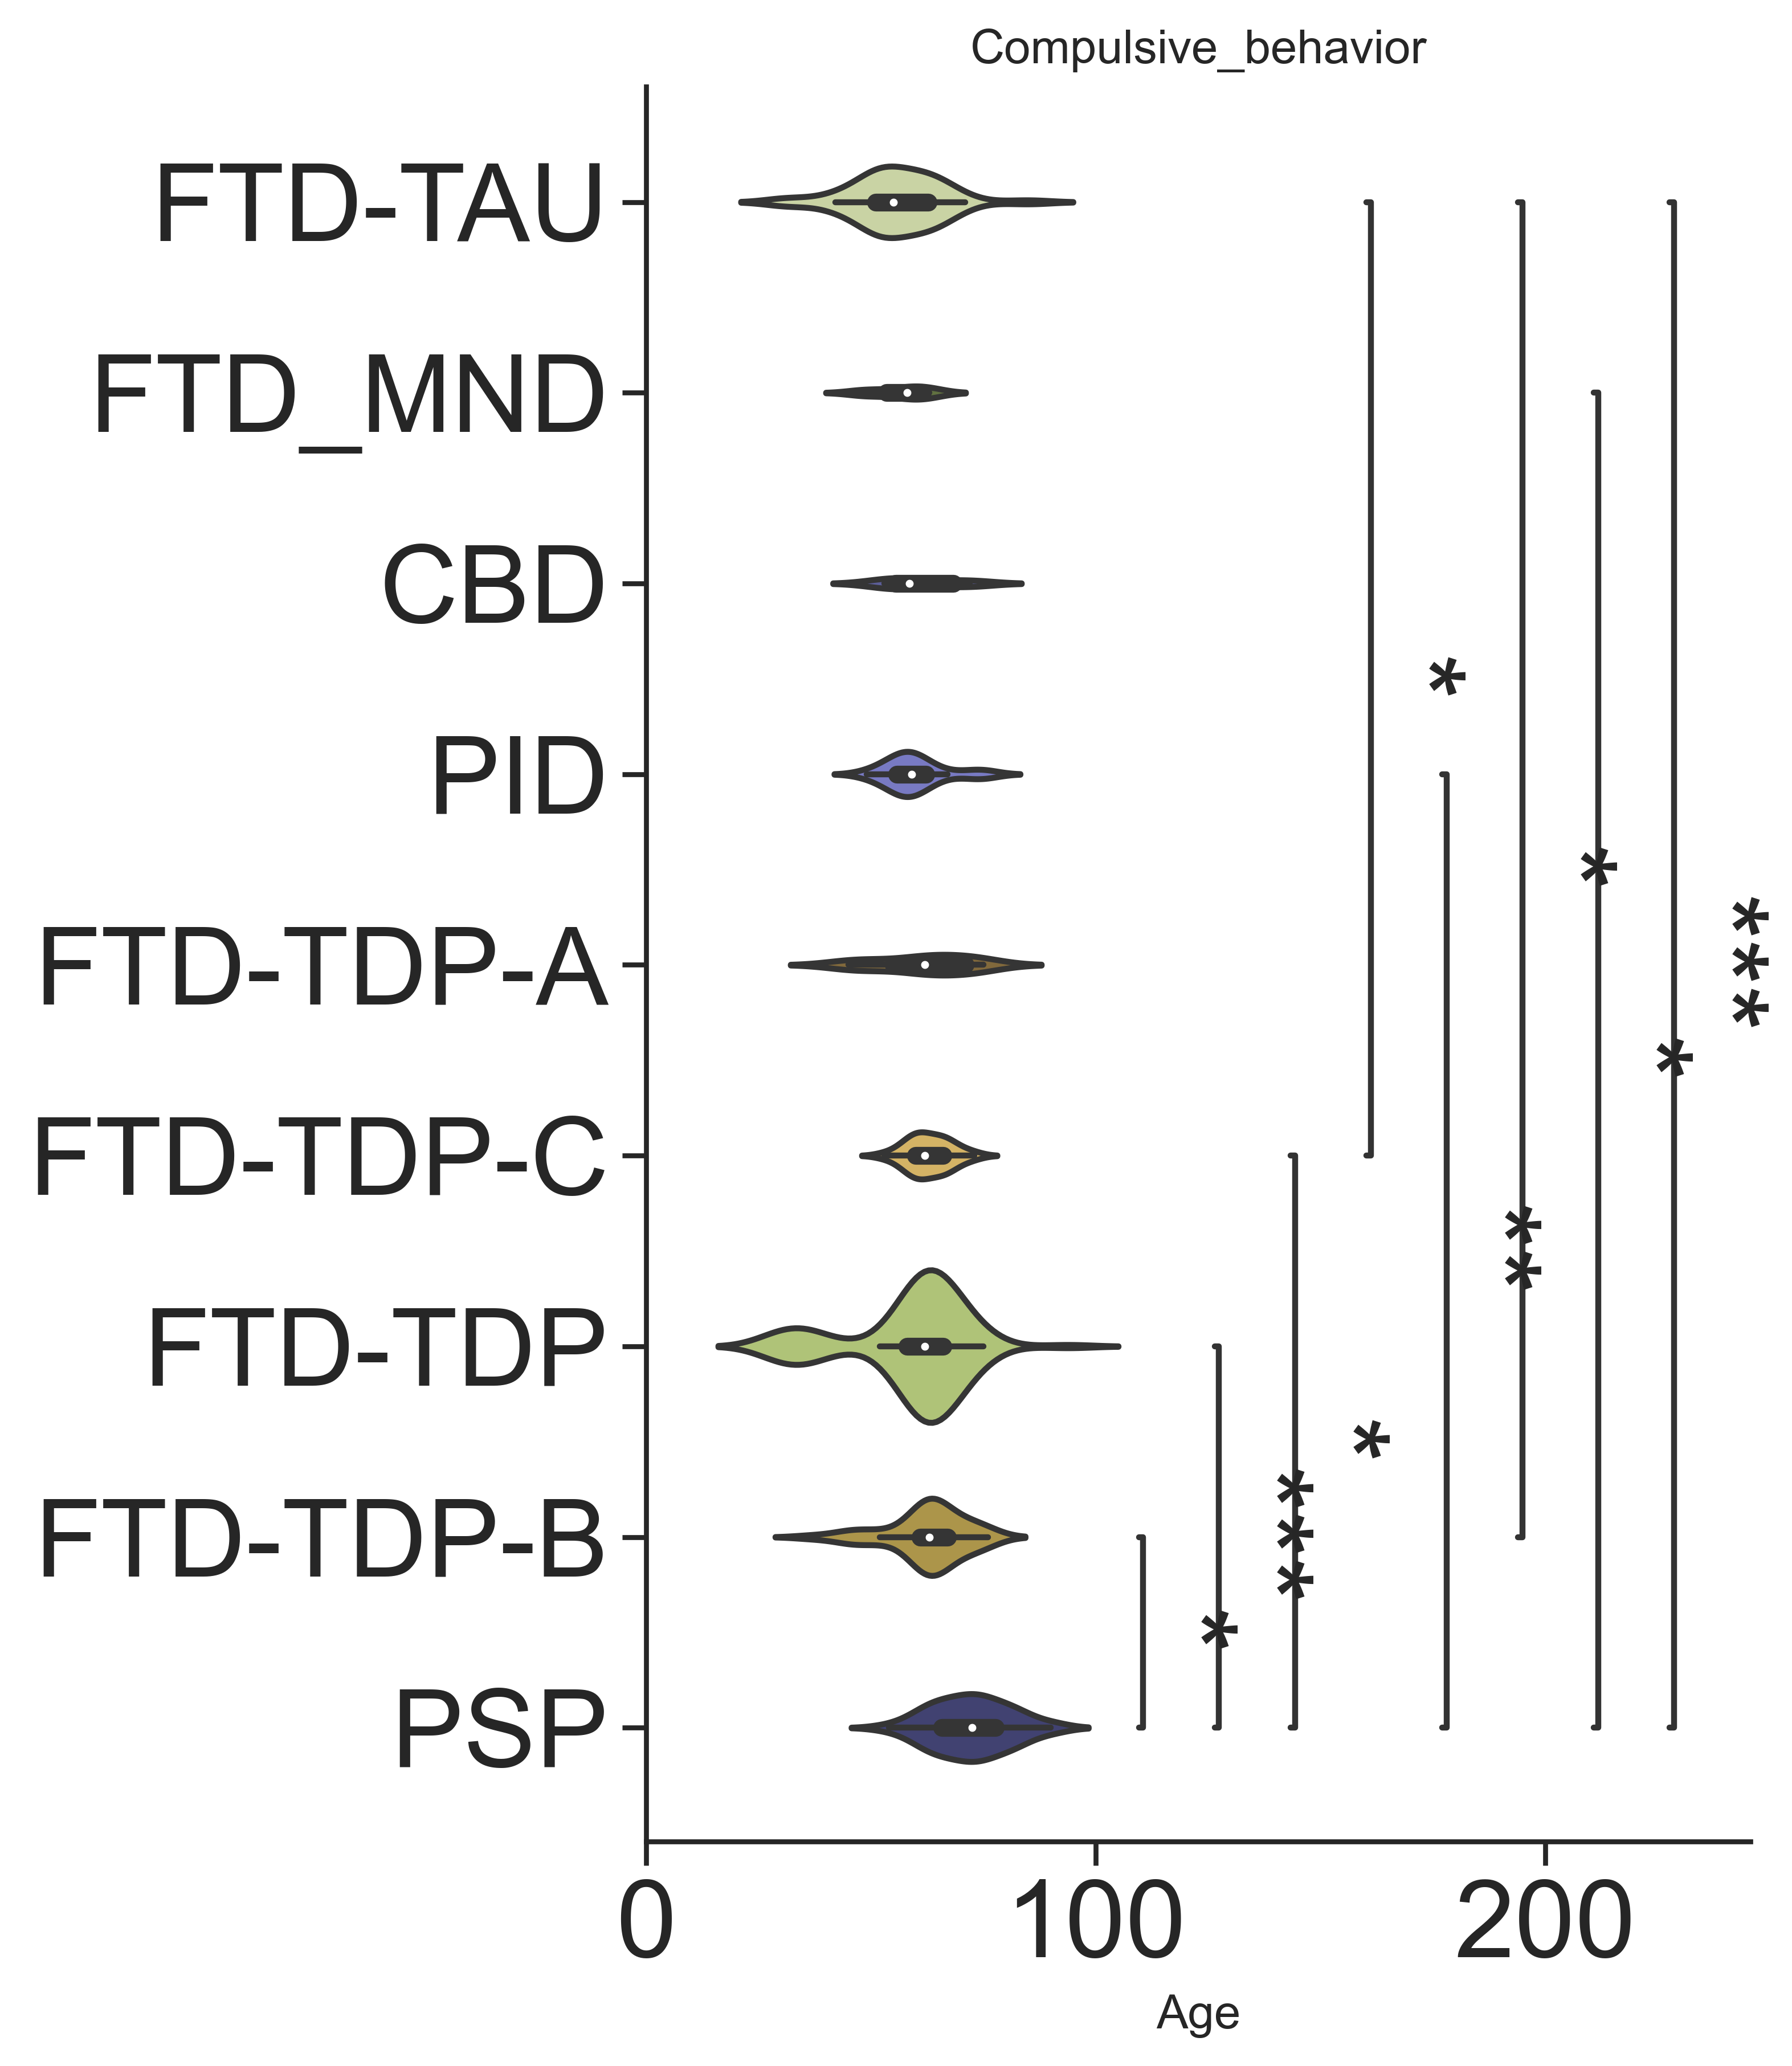

In [118]:
# ## temporal, 4b
table_of_choice = 'table3_p'
# display(sorted(predictions_df_temporal['neuropathological_diagnosis'].unique()))
selected_donors,diagnoses = table_selector(table_of_choice, predictions_df_temporal)
color_palette = sns.color_palette("tab20b")[0:21]
table_diagnosis_colors_dic = {} 
counter = 0 
for diagnosis in diagnoses:
    table_diagnosis_colors_dic[diagnosis] = color_palette[counter]
    counter+=1
    
trait_attribute_dictionary = {} 
trait_attribute_dictionary['Dementia'] =   ['CBD', 'FTD-TAU', 'FTD-TDP-A', 'FTD-TDP-B', 'FTD-TDP-C','FTD_MND', 'FTD-TDP', 'PID', 'PSP']
trait_attribute_dictionary['Memory_impairment'] = ['CBD', 'FTD-TAU', 'FTD-TDP-A', 'FTD-TDP-B', 'FTD-TDP-C','FTD_MND', 'FTD-TDP', 'PID', 'PSP']
trait_attribute_dictionary['Compulsive_behavior'] = ['CBD', 'FTD-TAU', 'FTD-TDP-A', 'FTD-TDP-B', 'FTD-TDP-C','FTD_MND', 'FTD-TDP', 'PID', 'PSP']

make_labeled_violinplots_horizontal(trait_attribute_dictionary,
                                    selected_donors,
                                    table_diagnosis_colors_dic,
                                    110,
                                    'temporal',
                                    'ext_4_ftd_subtypes_temporal',
                                   heatmap=False,
                                   printvalues=True,
                                   fixsex=True,
                                   remove_zero_donors = True,
                                   w=5,
                                   h=8)

In [117]:
# make_labeled_violinplots_horizontal(trait_attribute_dictionary,
#                                     selected_donors,
#                                     table_diagnosis_colors_dic,
#                                     50,
#                                     'survival',
#                                     'ext_4_ftd_subtypes_survival',
#                                    heatmap=True,
#                                    printvalues=True,
#                                    fixsex=True,
#                                    remove_zero_donors = True,
#                                    w=5,
#                                    h=8                                   )

The plot type is counts
Dementia
After selecting for ['CON' 'PID' 'PSP' 'FTD-TDP' 'FTD-TAU' 'FTD_MND' 'FTD-TDP-C' 'FTD-TDP-B'
 'CBD' 'FTD-TDP-A'], we have 770  donors
Before removing zero donors


neuropathological_diagnosis sex  observations_Dementia  donors
0                          CBD   F                     11       6
1                          CBD   M                      4       9
2                          CON   F                      9     234
3                          CON   M                      5     211
4                      FTD-TAU   F                     30      20
5                      FTD-TAU   M                     37      23
6                      FTD-TDP   F                     59      28
7                      FTD-TDP   M                     52      31
8                    FTD-TDP-A   F                     21      11
9                    FTD-TDP-A   M                     15      10
10                   FTD-TDP-B   F                     27      16
11                   FTD-TDP-B   M                     33      15
12                   FTD-TDP-C   F                     11       5
13                   FTD-TDP-C   M                     15       7
14                     FTD_MND   F                      2       3
15                     FTD_MND   M                     14       9
16                         PID   F                     21      15
17                         PID   M                     44      26
18                         PSP   F                     33      41
19                         PSP   M                     37      50





















After subsampling sexes


neuropathological_diagnosis sex  observations_Dementia  donors
0                          CBD   F                     11       6
1                          CBD   M                      2       6
2                          CON   F                      9     211
3                          CON   M                      5     211
4                      FTD-TAU   F                     30      20
5                      FTD-TAU   M                     33      20
6                      FTD-TDP   F                     59      28
7                      FTD-TDP   M                     48      28
8                    FTD-TDP-A   F                     19      10
9                    FTD-TDP-A   M                     15      10
10                   FTD-TDP-B   F                     24      15
11                   FTD-TDP-B   M                     33      15
12                   FTD-TDP-C   F                     11       5
13                   FTD-TDP-C   M                     12       5
14                     FTD_MND   F                      2       3
15                     FTD_MND   M                      5       3
16                         PID   F                     21      15
17                         PID   M                     21      15
18                         PSP   F                     33      41
19                         PSP   M                     30      41

228 donors are used in the temporal plot
708 donors are used in the observations plot
CON


/tmp/ipykernel_10217/3446875031.py:83: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df.groupby(['DonorID']).sum() ## sums all observations of symptom for donor. note, many donors have 0 (e.g. control)


'422 donors in the counts df'

CBD


/tmp/ipykernel_10217/3446875031.py:83: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df.groupby(['DonorID']).sum() ## sums all observations of symptom for donor. note, many donors have 0 (e.g. control)


'12 donors in the counts df'

FTD_MND


/tmp/ipykernel_10217/3446875031.py:83: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df.groupby(['DonorID']).sum() ## sums all observations of symptom for donor. note, many donors have 0 (e.g. control)


'6 donors in the counts df'

PID


/tmp/ipykernel_10217/3446875031.py:83: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df.groupby(['DonorID']).sum() ## sums all observations of symptom for donor. note, many donors have 0 (e.g. control)


'30 donors in the counts df'

PSP


/tmp/ipykernel_10217/3446875031.py:83: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df.groupby(['DonorID']).sum() ## sums all observations of symptom for donor. note, many donors have 0 (e.g. control)


'82 donors in the counts df'

FTD-TDP-A


/tmp/ipykernel_10217/3446875031.py:83: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df.groupby(['DonorID']).sum() ## sums all observations of symptom for donor. note, many donors have 0 (e.g. control)


'20 donors in the counts df'

FTD-TAU


/tmp/ipykernel_10217/3446875031.py:83: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df.groupby(['DonorID']).sum() ## sums all observations of symptom for donor. note, many donors have 0 (e.g. control)


'40 donors in the counts df'

FTD-TDP


/tmp/ipykernel_10217/3446875031.py:83: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df.groupby(['DonorID']).sum() ## sums all observations of symptom for donor. note, many donors have 0 (e.g. control)


'56 donors in the counts df'

FTD-TDP-B


/tmp/ipykernel_10217/3446875031.py:83: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df.groupby(['DonorID']).sum() ## sums all observations of symptom for donor. note, many donors have 0 (e.g. control)


'30 donors in the counts df'

FTD-TDP-C


/tmp/ipykernel_10217/3446875031.py:83: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df.groupby(['DonorID']).sum() ## sums all observations of symptom for donor. note, many donors have 0 (e.g. control)


'10 donors in the counts df'

/home/jupyter-n.mekkes@gmail.com-f6d87/.conda/envs/clinical_history/lib/python3.11/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/home/jupyter-n.mekkes@gmail.com-f6d87/.conda/envs/clinical_history/lib/python3.11/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/home/jupyter-n.mekkes@gmail.com-f6d87/.conda/envs/clinical_history/lib/python3.11/site-packages/statannotations/Annotator.py:805: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "


p-value annotation legend:
       *: p <= 1.00e-02
      **: 1.00e-06 < p <= 1.00e-04
     ***: 1.00e-08 < p <= 1.00e-06
    ****: 1.00e-10 < p <= 1.00e-08
   *****: p <= 1.00e-10

CON vs. PSP: Custom statistical test, P_val:4.414e-35
CON vs. CBD: Custom statistical test, P_val:4.308e-26
CON vs. FTD_MND: Custom statistical test, P_val:1.260e-16
PSP vs. PID: Custom statistical test, P_val:3.183e-03
CON vs. PID: Custom statistical test, P_val:1.152e-55
PSP vs. FTD-TAU: Custom statistical test, P_val:3.374e-04
CON vs. FTD-TAU: Custom statistical test, P_val:1.115e-62
PSP vs. FTD-TDP-A: Custom statistical test, P_val:1.309e-03
CON vs. FTD-TDP-A: Custom statistical test, P_val:1.766e-53
PSP vs. FTD-TDP: Custom statistical test, P_val:2.396e-07
CON vs. FTD-TDP: Custom statistical test, P_val:9.426e-78
PSP vs. FTD-TDP-B: Custom statistical test, P_val:1.558e-05
CON vs. FTD-TDP-B: Custom statistical test, P_val:1.701e-62
PSP vs. FTD-TDP-C: Custom statistical test, P_val:5.233e-04
CON vs. FTD-T

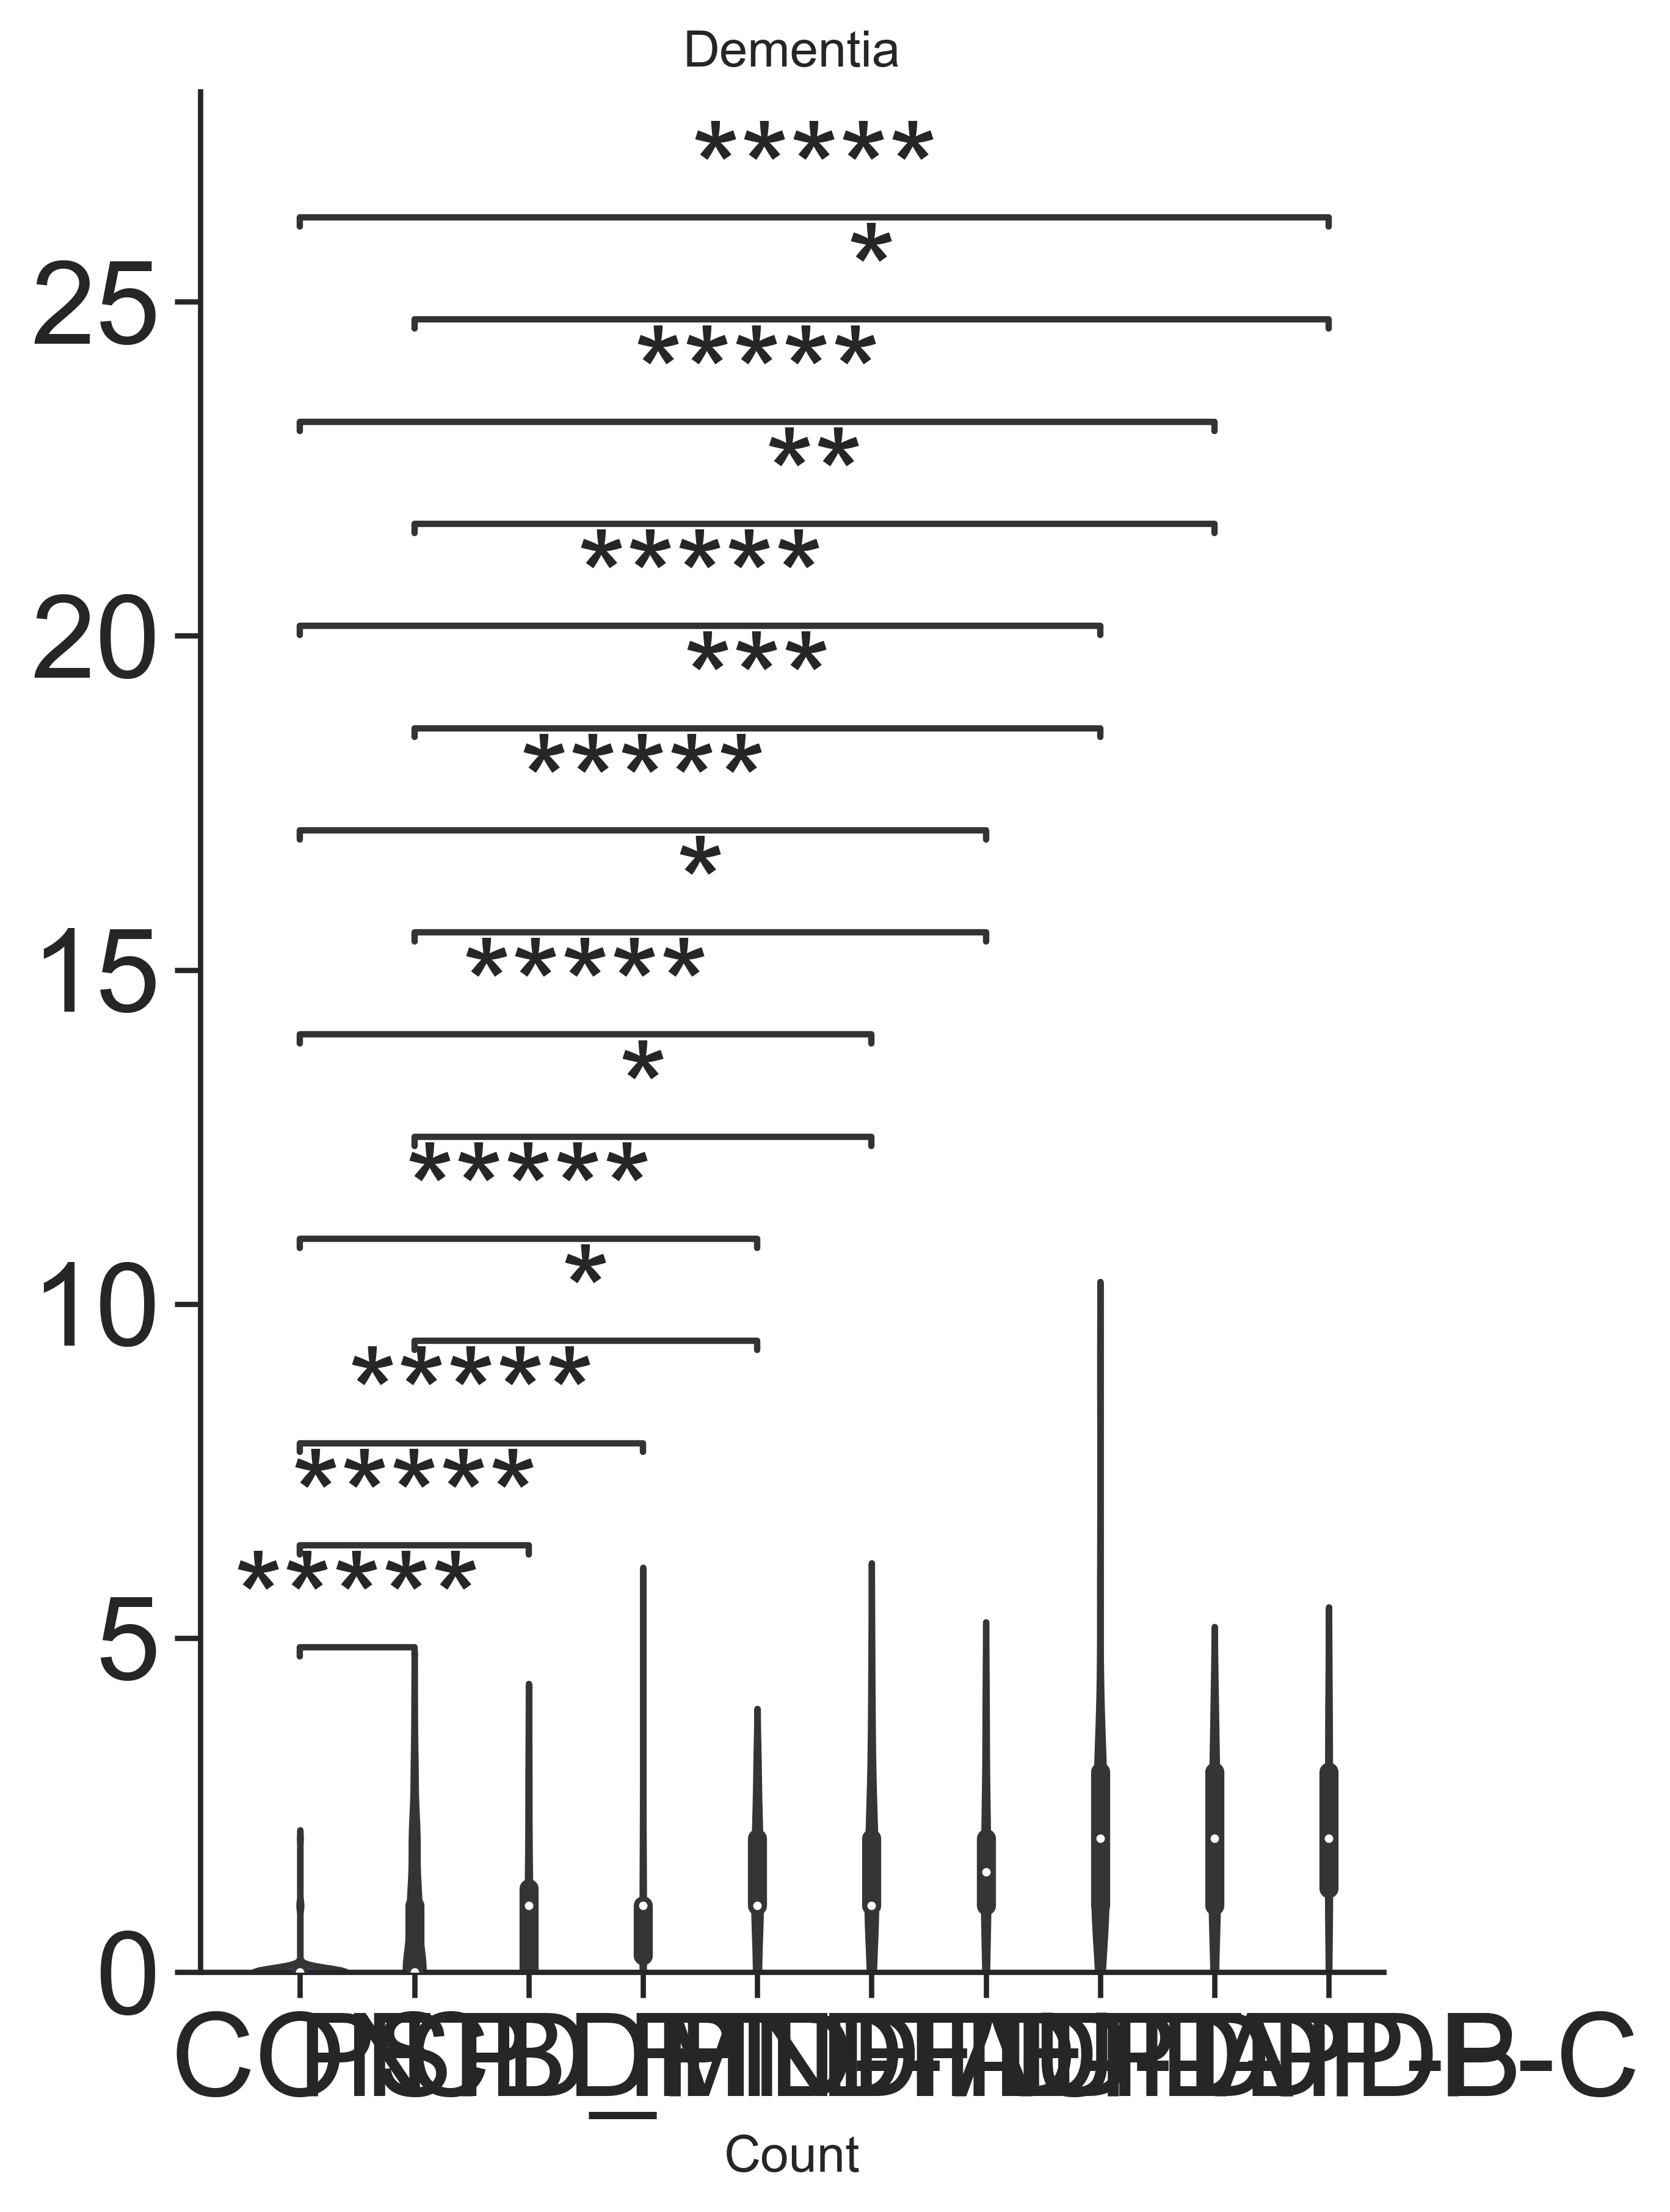

Memory_impairment
After selecting for ['CON' 'PID' 'PSP' 'FTD-TDP' 'FTD-TAU' 'FTD_MND' 'FTD-TDP-C' 'FTD-TDP-B'
 'CBD' 'FTD-TDP-A'], we have 770  donors
Before removing zero donors


neuropathological_diagnosis sex  observations_Memory_impairment  donors
0                          CBD   F                              13       6
1                          CBD   M                               7       9
2                          CON   F                              31     234
3                          CON   M                              22     211
4                      FTD-TAU   F                              30      20
5                      FTD-TAU   M                              36      23
6                      FTD-TDP   F                              46      28
7                      FTD-TDP   M                              52      31
8                    FTD-TDP-A   F                              19      11
9                    FTD-TDP-A   M                              11      10
10                   FTD-TDP-B   F                              22      16
11                   FTD-TDP-B   M                              33      15
12                   FTD-TDP-C   F                               9       5
13                   FTD-TDP-C   M                              15       7
14                     FTD_MND   F                               2       3
15                     FTD_MND   M                               7       9
16                         PID   F                              12      15
17                         PID   M                              33      26
18                         PSP   F                              56      41
19                         PSP   M                              60      50





















After subsampling sexes


neuropathological_diagnosis sex  observations_Memory_impairment  donors
0                          CBD   F                              13       6
1                          CBD   M                               4       6
2                          CON   F                              26     211
3                          CON   M                              22     211
4                      FTD-TAU   F                              30      20
5                      FTD-TAU   M                              30      20
6                      FTD-TDP   F                              46      28
7                      FTD-TDP   M                              47      28
8                    FTD-TDP-A   F                              18      10
9                    FTD-TDP-A   M                              11      10
10                   FTD-TDP-B   F                              20      15
11                   FTD-TDP-B   M                              33      15
12                   FTD-TDP-C   F                               9       5
13                   FTD-TDP-C   M                              14       5
14                     FTD_MND   F                               2       3
15                     FTD_MND   M                               1       3
16                         PID   F                              12      15
17                         PID   M                              18      15
18                         PSP   F                              56      41
19                         PSP   M                              48      41

245 donors are used in the temporal plot
708 donors are used in the observations plot
CON


/tmp/ipykernel_10217/3446875031.py:83: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df.groupby(['DonorID']).sum() ## sums all observations of symptom for donor. note, many donors have 0 (e.g. control)


'422 donors in the counts df'

CBD


/tmp/ipykernel_10217/3446875031.py:83: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df.groupby(['DonorID']).sum() ## sums all observations of symptom for donor. note, many donors have 0 (e.g. control)


'12 donors in the counts df'

FTD_MND


/tmp/ipykernel_10217/3446875031.py:83: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df.groupby(['DonorID']).sum() ## sums all observations of symptom for donor. note, many donors have 0 (e.g. control)


'6 donors in the counts df'

PID


/tmp/ipykernel_10217/3446875031.py:83: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df.groupby(['DonorID']).sum() ## sums all observations of symptom for donor. note, many donors have 0 (e.g. control)


'30 donors in the counts df'

PSP


/tmp/ipykernel_10217/3446875031.py:83: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df.groupby(['DonorID']).sum() ## sums all observations of symptom for donor. note, many donors have 0 (e.g. control)


'82 donors in the counts df'

FTD-TDP-A


/tmp/ipykernel_10217/3446875031.py:83: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df.groupby(['DonorID']).sum() ## sums all observations of symptom for donor. note, many donors have 0 (e.g. control)


'20 donors in the counts df'

FTD-TAU


/tmp/ipykernel_10217/3446875031.py:83: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df.groupby(['DonorID']).sum() ## sums all observations of symptom for donor. note, many donors have 0 (e.g. control)


'40 donors in the counts df'

FTD-TDP


/tmp/ipykernel_10217/3446875031.py:83: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df.groupby(['DonorID']).sum() ## sums all observations of symptom for donor. note, many donors have 0 (e.g. control)


'56 donors in the counts df'

FTD-TDP-B


/tmp/ipykernel_10217/3446875031.py:83: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df.groupby(['DonorID']).sum() ## sums all observations of symptom for donor. note, many donors have 0 (e.g. control)


'30 donors in the counts df'

FTD-TDP-C


/tmp/ipykernel_10217/3446875031.py:83: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df.groupby(['DonorID']).sum() ## sums all observations of symptom for donor. note, many donors have 0 (e.g. control)


'10 donors in the counts df'

/home/jupyter-n.mekkes@gmail.com-f6d87/.conda/envs/clinical_history/lib/python3.11/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/home/jupyter-n.mekkes@gmail.com-f6d87/.conda/envs/clinical_history/lib/python3.11/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/home/jupyter-n.mekkes@gmail.com-f6d87/.conda/envs/clinical_history/lib/python3.11/site-packages/statannotations/Annotator.py:805: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "


p-value annotation legend:
       *: p <= 1.00e-02
      **: 1.00e-06 < p <= 1.00e-04
     ***: 1.00e-08 < p <= 1.00e-06
    ****: 1.00e-10 < p <= 1.00e-08
   *****: p <= 1.00e-10

CON vs. FTD_MND: Custom statistical test, P_val:1.637e-03
CON vs. CBD: Custom statistical test, P_val:1.253e-14
CON vs. PID: Custom statistical test, P_val:3.957e-18
CON vs. PSP: Custom statistical test, P_val:1.400e-34
CON vs. FTD-TDP-A: Custom statistical test, P_val:5.246e-21
CON vs. FTD-TAU: Custom statistical test, P_val:2.185e-43
CON vs. FTD-TDP: Custom statistical test, P_val:6.479e-41
CON vs. FTD-TDP-B: Custom statistical test, P_val:4.179e-38
CON vs. FTD-TDP-C: Custom statistical test, P_val:1.965e-22


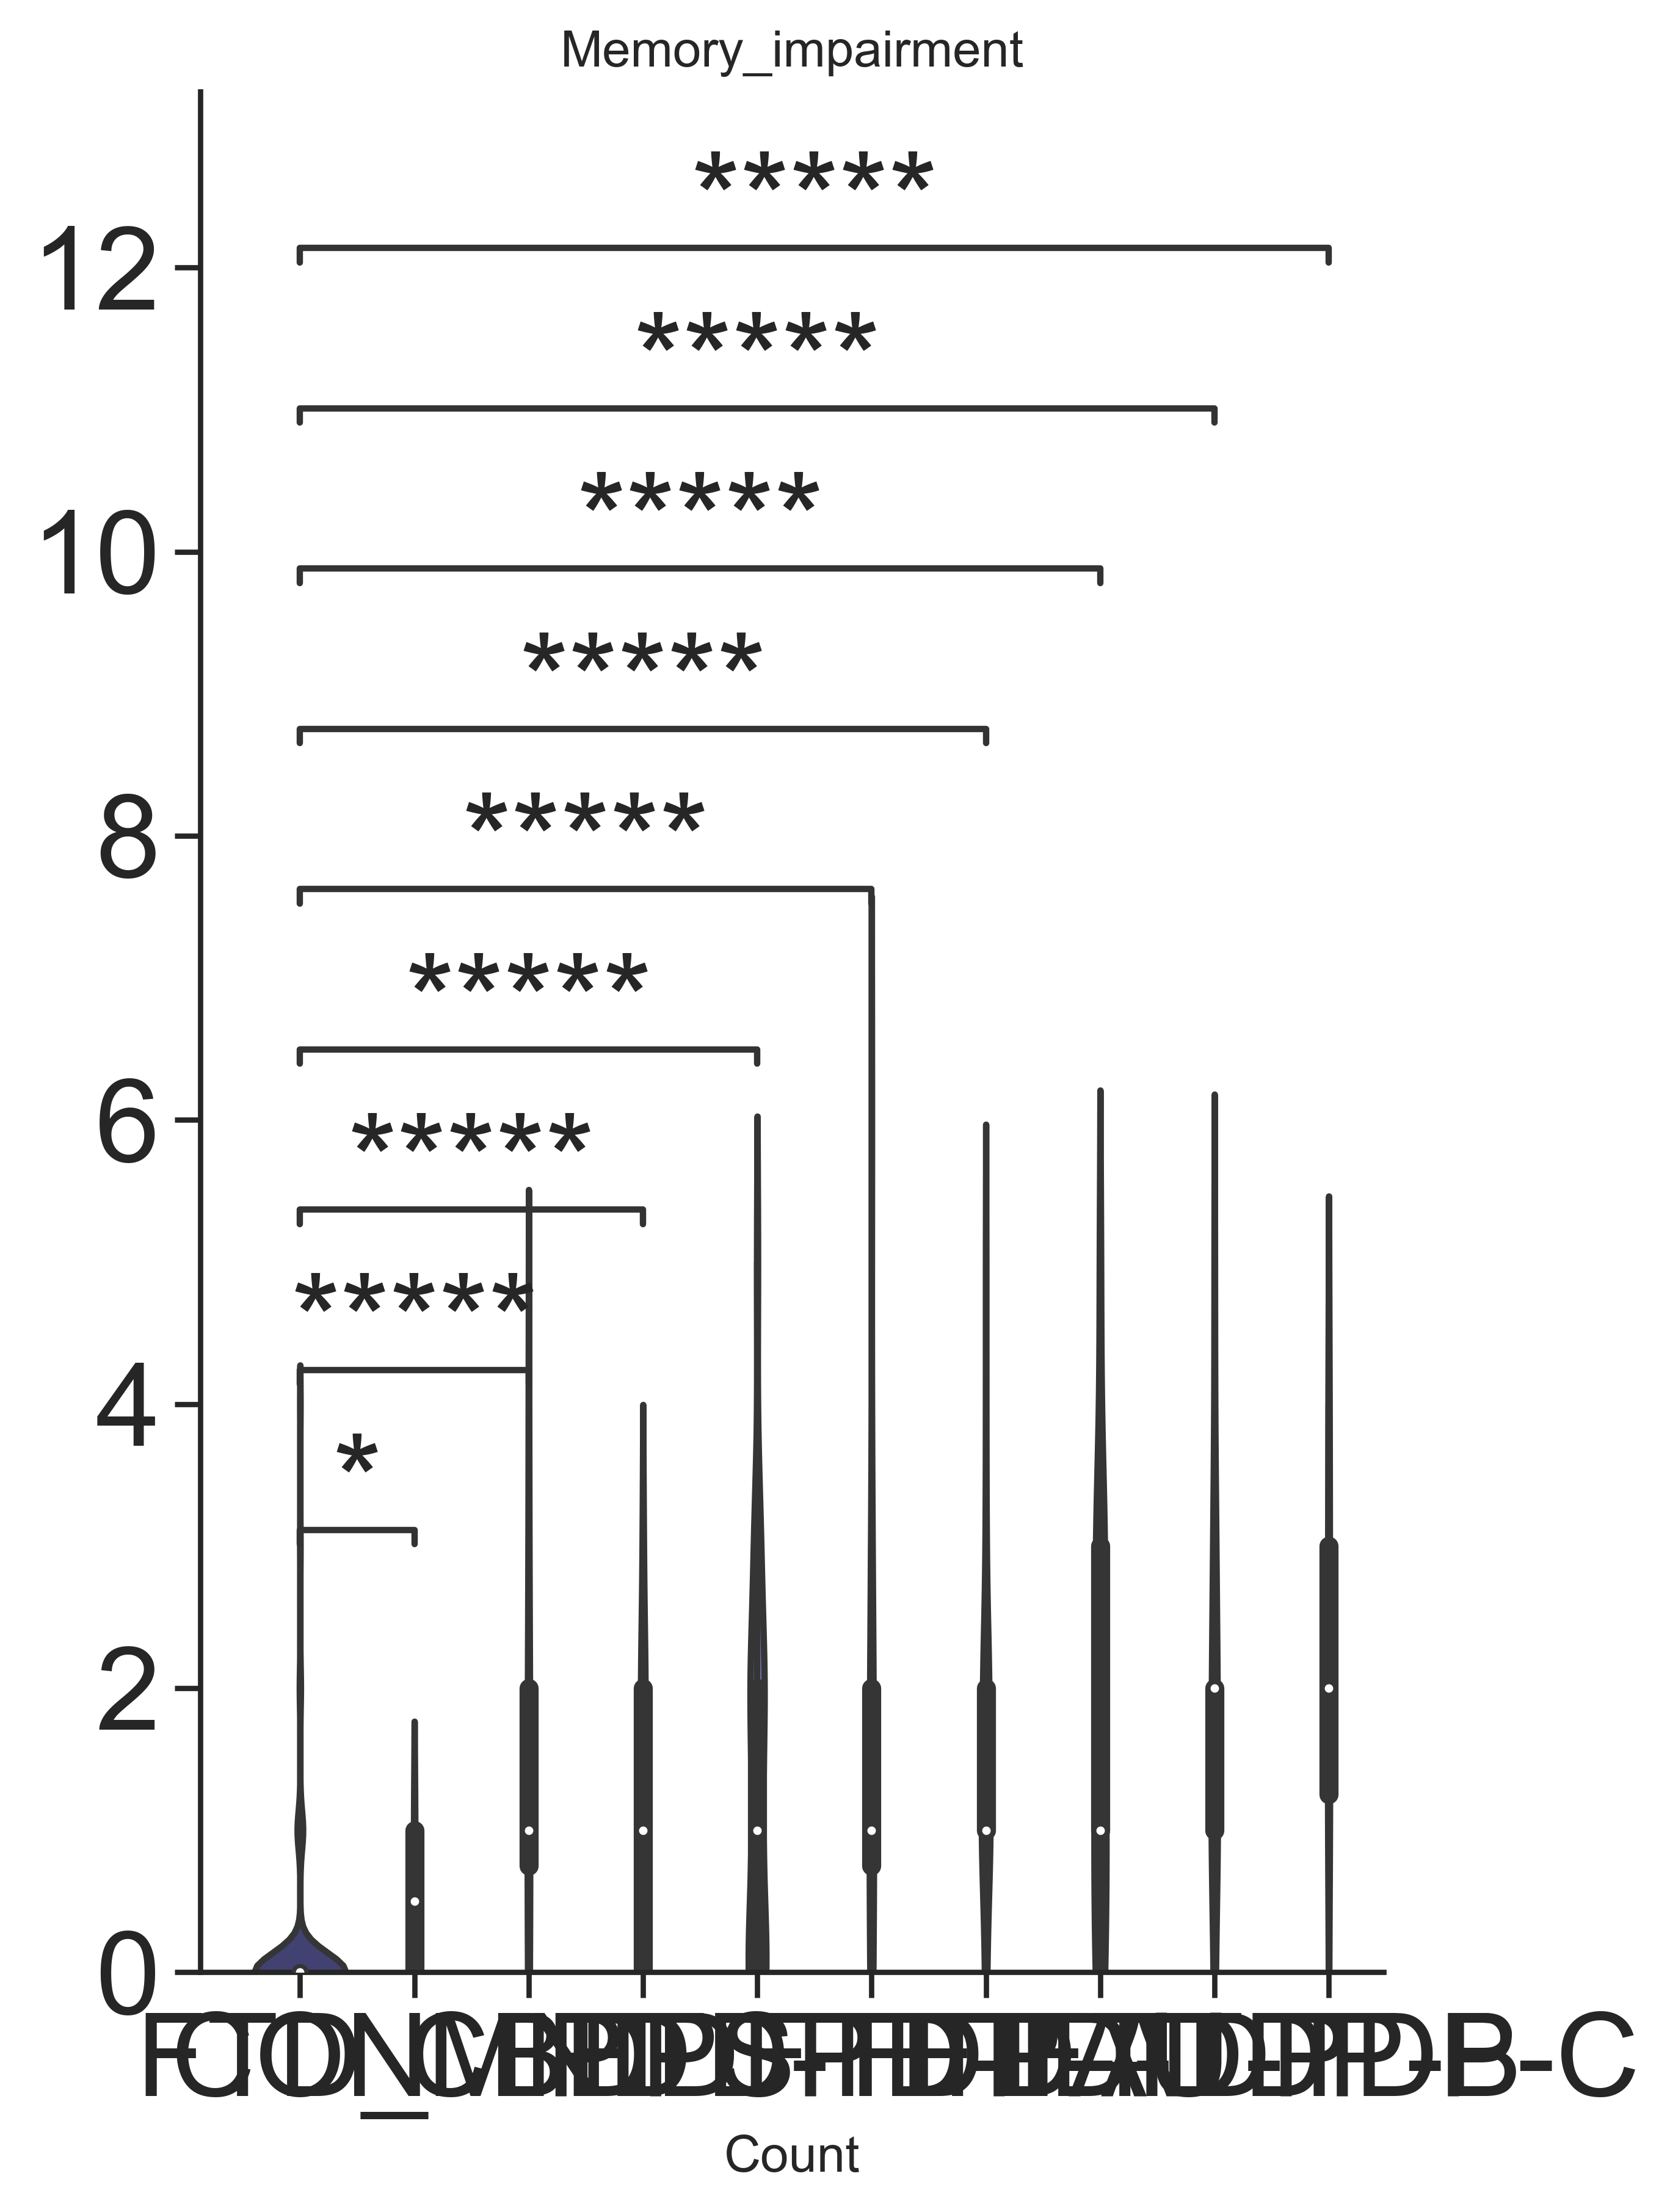

Compulsive_behavior
After selecting for ['CON' 'PID' 'PSP' 'FTD-TDP' 'FTD-TAU' 'FTD_MND' 'FTD-TDP-C' 'FTD-TDP-B'
 'CBD' 'FTD-TDP-A'], we have 770  donors
Before removing zero donors


neuropathological_diagnosis sex  observations_Compulsive_behavior  donors
0                          CBD   F                                 3       6
1                          CBD   M                                 4       9
2                          CON   F                                 8     234
3                          CON   M                                 4     211
4                      FTD-TAU   F                                21      20
5                      FTD-TAU   M                                27      23
6                      FTD-TDP   F                                50      28
7                      FTD-TDP   M                                33      31
8                    FTD-TDP-A   F                                 7      11
9                    FTD-TDP-A   M                                 4      10
10                   FTD-TDP-B   F                                23      16
11                   FTD-TDP-B   M                                34      15
12                   FTD-TDP-C   F                                11       5
13                   FTD-TDP-C   M                                14       7
14                     FTD_MND   F                                 4       3
15                     FTD_MND   M                                 5       9
16                         PID   F                                12      15
17                         PID   M                                38      26
18                         PSP   F                                18      41
19                         PSP   M                                31      50





















After subsampling sexes


neuropathological_diagnosis sex  observations_Compulsive_behavior  donors
0                          CBD   F                                 3       6
1                          CBD   M                                 2       6
2                          CON   F                                 8     211
3                          CON   M                                 4     211
4                      FTD-TAU   F                                21      20
5                      FTD-TAU   M                                23      20
6                      FTD-TDP   F                                50      28
7                      FTD-TDP   M                                32      28
8                    FTD-TDP-A   F                                 7      10
9                    FTD-TDP-A   M                                 4      10
10                   FTD-TDP-B   F                                22      15
11                   FTD-TDP-B   M                                34      15
12                   FTD-TDP-C   F                                11       5
13                   FTD-TDP-C   M                                12       5
14                     FTD_MND   F                                 4       3
15                     FTD_MND   M                                 1       3
16                         PID   F                                12      15
17                         PID   M                                18      15
18                         PSP   F                                18      41
19                         PSP   M                                27      41

160 donors are used in the temporal plot
708 donors are used in the observations plot
CON


/tmp/ipykernel_10217/3446875031.py:83: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df.groupby(['DonorID']).sum() ## sums all observations of symptom for donor. note, many donors have 0 (e.g. control)


'422 donors in the counts df'

CBD


/tmp/ipykernel_10217/3446875031.py:83: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df.groupby(['DonorID']).sum() ## sums all observations of symptom for donor. note, many donors have 0 (e.g. control)


'12 donors in the counts df'

FTD_MND


/tmp/ipykernel_10217/3446875031.py:83: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df.groupby(['DonorID']).sum() ## sums all observations of symptom for donor. note, many donors have 0 (e.g. control)


'6 donors in the counts df'

PID


/tmp/ipykernel_10217/3446875031.py:83: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df.groupby(['DonorID']).sum() ## sums all observations of symptom for donor. note, many donors have 0 (e.g. control)


'30 donors in the counts df'

PSP


/tmp/ipykernel_10217/3446875031.py:83: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df.groupby(['DonorID']).sum() ## sums all observations of symptom for donor. note, many donors have 0 (e.g. control)


'82 donors in the counts df'

FTD-TDP-A


/tmp/ipykernel_10217/3446875031.py:83: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df.groupby(['DonorID']).sum() ## sums all observations of symptom for donor. note, many donors have 0 (e.g. control)


'20 donors in the counts df'

FTD-TAU


/tmp/ipykernel_10217/3446875031.py:83: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df.groupby(['DonorID']).sum() ## sums all observations of symptom for donor. note, many donors have 0 (e.g. control)


'40 donors in the counts df'

FTD-TDP


/tmp/ipykernel_10217/3446875031.py:83: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df.groupby(['DonorID']).sum() ## sums all observations of symptom for donor. note, many donors have 0 (e.g. control)


'56 donors in the counts df'

FTD-TDP-B


/tmp/ipykernel_10217/3446875031.py:83: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df.groupby(['DonorID']).sum() ## sums all observations of symptom for donor. note, many donors have 0 (e.g. control)


'30 donors in the counts df'

FTD-TDP-C


/tmp/ipykernel_10217/3446875031.py:83: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df.groupby(['DonorID']).sum() ## sums all observations of symptom for donor. note, many donors have 0 (e.g. control)


'10 donors in the counts df'

/home/jupyter-n.mekkes@gmail.com-f6d87/.conda/envs/clinical_history/lib/python3.11/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/home/jupyter-n.mekkes@gmail.com-f6d87/.conda/envs/clinical_history/lib/python3.11/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/home/jupyter-n.mekkes@gmail.com-f6d87/.conda/envs/clinical_history/lib/python3.11/site-packages/statannotations/Annotator.py:805: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "


p-value annotation legend:
       *: p <= 1.00e-02
      **: 1.00e-06 < p <= 1.00e-04
     ***: 1.00e-08 < p <= 1.00e-06
    ****: 1.00e-10 < p <= 1.00e-08
   *****: p <= 1.00e-10

CON vs. CBD: Custom statistical test, P_val:4.182e-08
CON vs. PSP: Custom statistical test, P_val:1.621e-26
CON vs. FTD-TDP-A: Custom statistical test, P_val:3.592e-15
CON vs. PID: Custom statistical test, P_val:7.501e-27
CON vs. FTD_MND: Custom statistical test, P_val:1.290e-16
FTD-TDP-A vs. FTD-TDP-B: Custom statistical test, P_val:3.519e-03
CON vs. FTD-TAU: Custom statistical test, P_val:9.028e-37
PSP vs. FTD-TDP-B: Custom statistical test, P_val:1.100e-05
FTD-TDP-A vs. FTD-TDP-C: Custom statistical test, P_val:4.628e-03
CON vs. FTD-TDP: Custom statistical test, P_val:2.396e-37
CBD vs. FTD-TDP-B: Custom statistical test, P_val:6.500e-03
PSP vs. FTD-TDP-C: Custom statistical test, P_val:2.780e-04
CON vs. FTD-TDP-B: Custom statistical test, P_val:1.010e-52
CBD vs. FTD-TDP-C: Custom statistical test, P_val:6

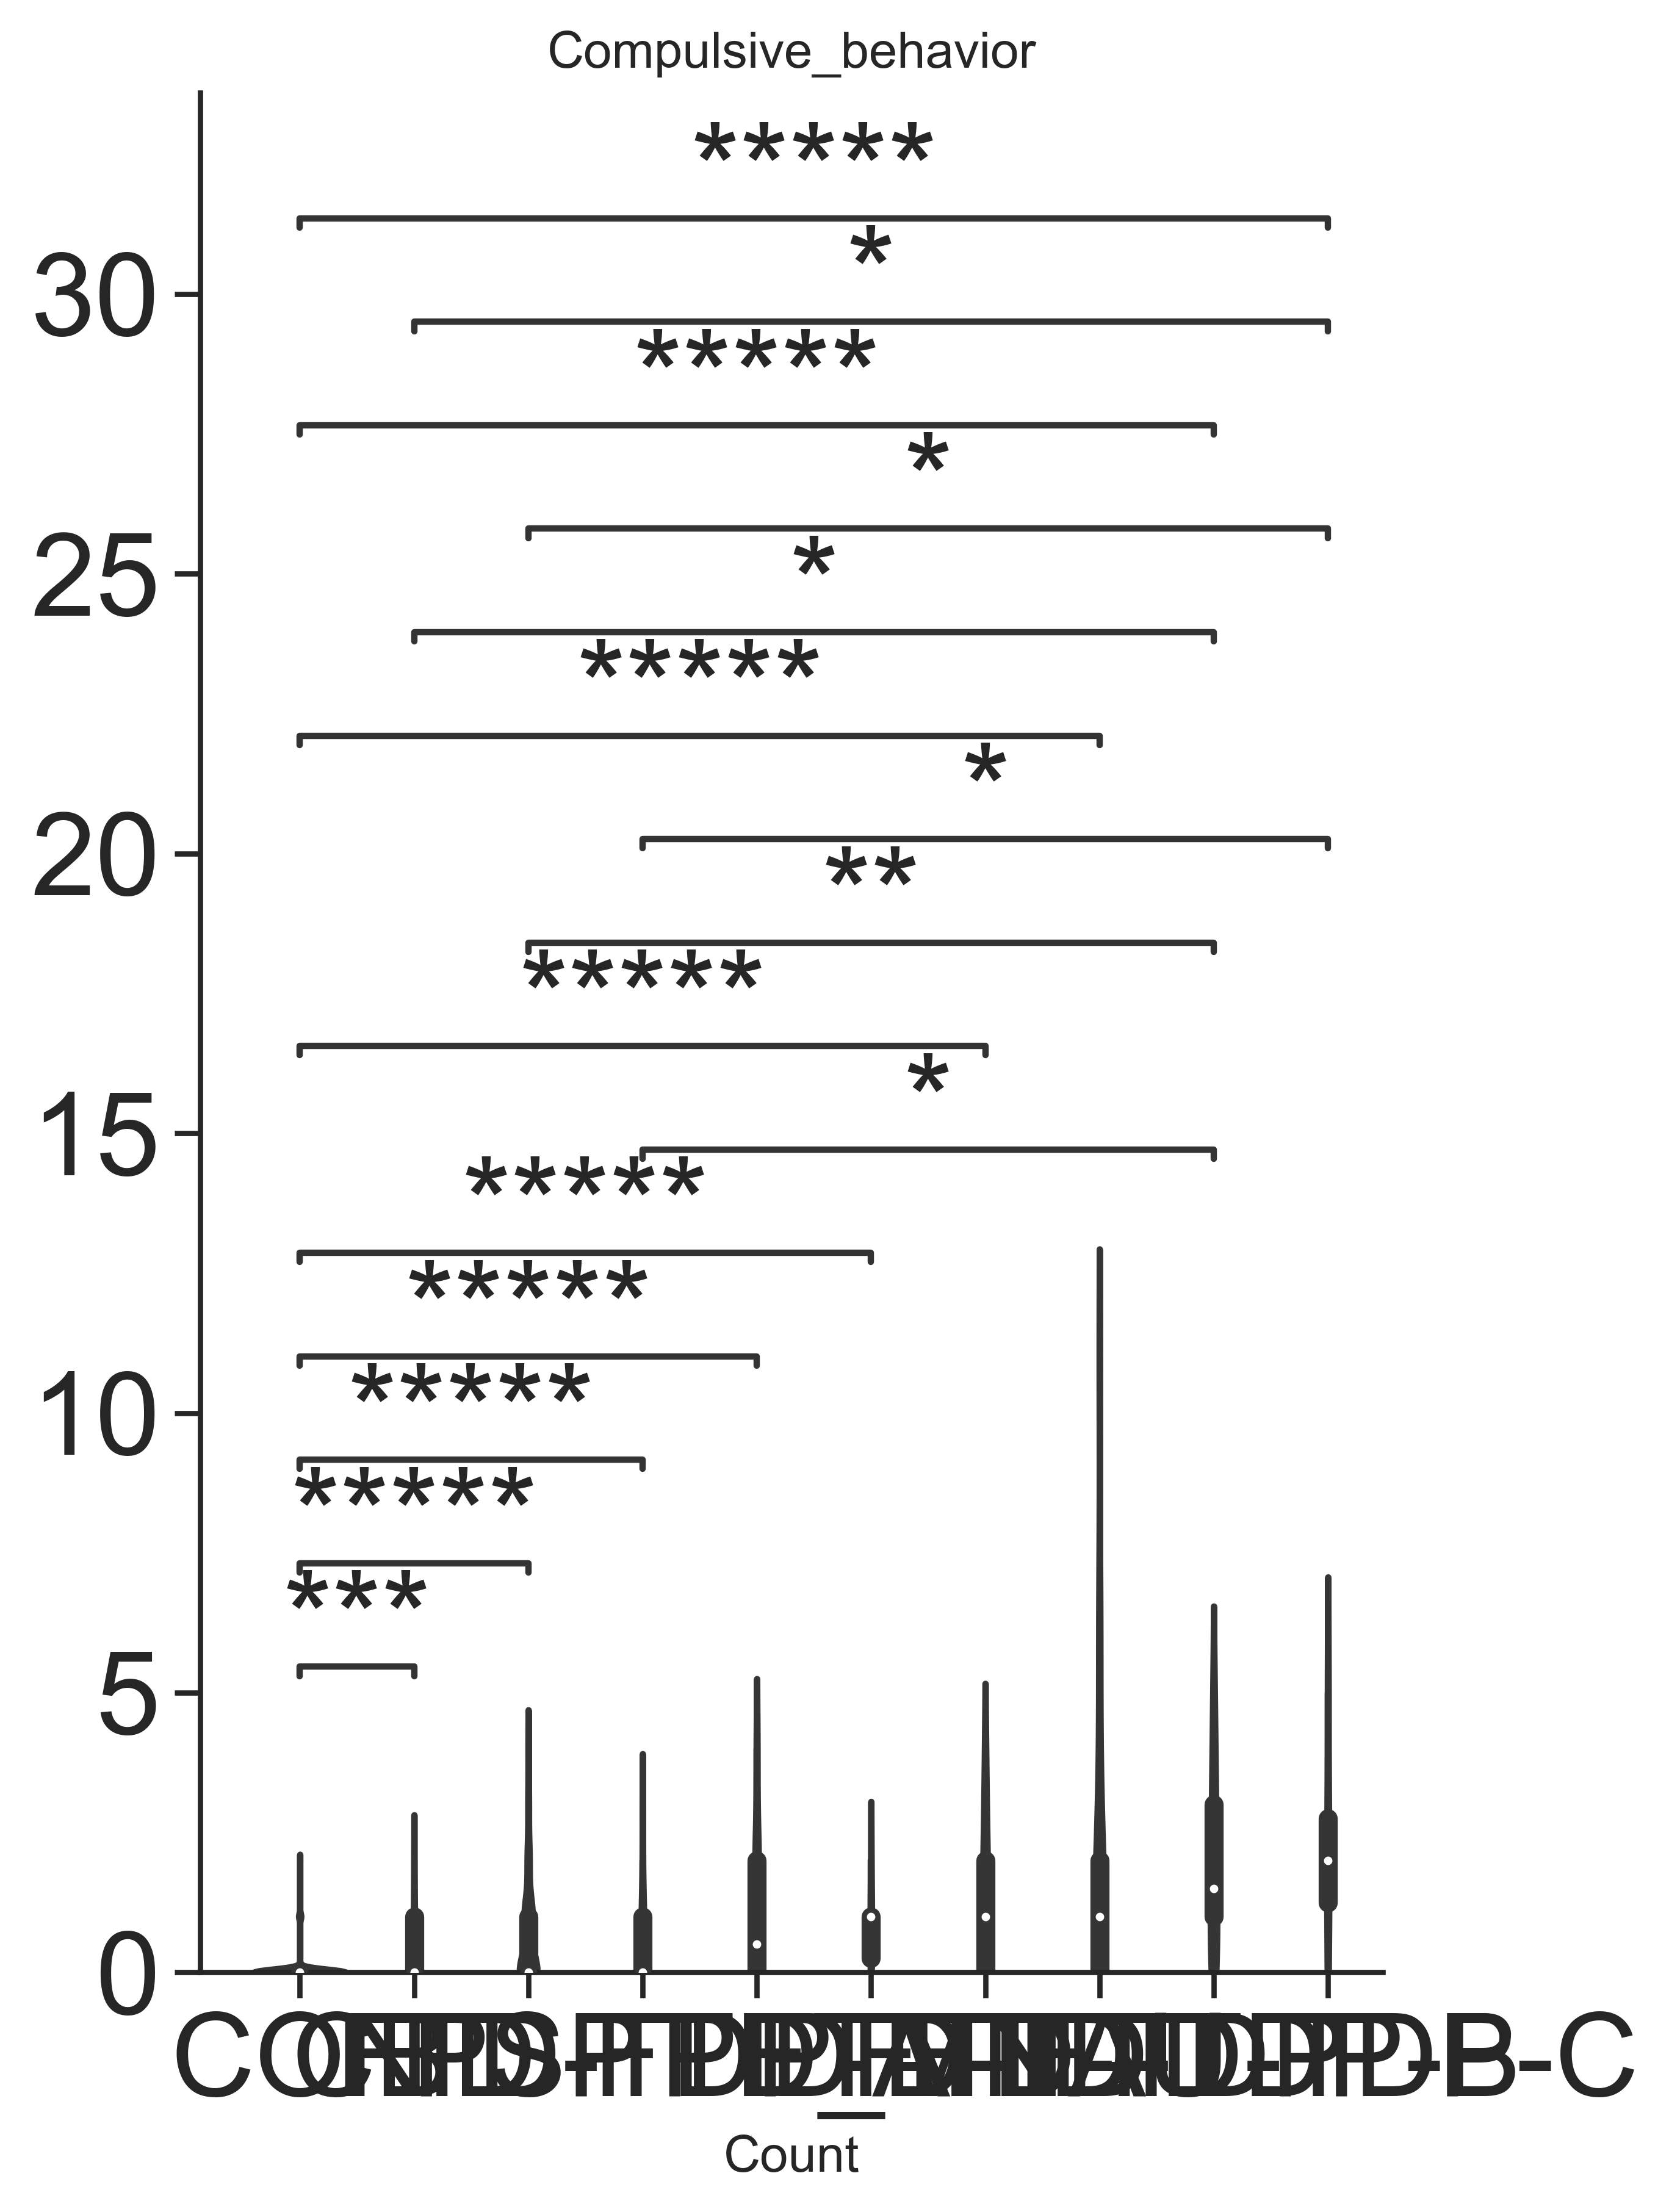

In [119]:
table_of_choice = 'table3_with_con_p'
selected_donors,diagnoses = table_selector(table_of_choice,predictions_df)
trait_attribute_dictionary = {} 
trait_attribute_dictionary['Dementia'] =              ['CON','CBD','FTD_MND', 'PID','PSP','FTD-TDP-A','FTD-TAU','FTD-TDP','FTD-TDP-B','FTD-TDP-C']
trait_attribute_dictionary['Memory_impairment'] =     ['CON','CBD','FTD_MND', 'PID','PSP','FTD-TDP-A','FTD-TAU','FTD-TDP','FTD-TDP-B','FTD-TDP-C']
trait_attribute_dictionary['Compulsive_behavior'] =   ['CON','CBD','FTD_MND', 'PID','PSP','FTD-TDP-A','FTD-TAU','FTD-TDP','FTD-TDP-B','FTD-TDP-C']

color_palette = sns.color_palette("tab20b")[0:21]

# set random colors
table_diagnosis_colors_dic = {} 
counter = 0 

for diagnosis in diagnoses:
    table_diagnosis_colors_dic[diagnosis] = color_palette[counter]
    counter+=1
    
    
# counts, 4b 
make_labeled_violinplots_horizontal(trait_attribute_dictionary,
                                    selected_donors,
                                    table_diagnosis_colors_dic,
                                    15,
                                    'counts',
                                   'ext_4_ftd_subtypes_counts',
                                  heatmap=False,
                                   printvalues=True,
                                   fixsex=True,
                                   remove_zero_donors = False,
                                   w=5,
                                   h=8
                                   )